In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import networkx as nx
import pandas as pd
import re
import time
import copy
import pickle
import warnings
import matplotlib.cm as cm
import seaborn as sns
from numpy.linalg import svd, matrix_rank, qr
from scipy import stats
from scipy.linalg import norm
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

from netdyn import *

In [2]:
def initialize_adjacency_matrix(matrix, seed=None):
    """
    1 to [0.5, 1.5], 0 remaining
    """
    if seed is not None:
        np.random.seed(seed)
        
    matrix = np.array(matrix, dtype=float)
    mask = (matrix == 1)
    matrix[mask] = np.random.uniform(0.5, 1.5, size=mask.sum())
    return matrix

<font color = black size = 5>Reconstruct surrogate network and simulate dynamics</font>

In [3]:
def compute_rmse(X_true, X_pred):
    """
    Compute RMSE between predicted and true trajectories.
    """
    min_len = min(len(X_true), len(X_pred))
    err = X_true[:min_len] - X_pred[:min_len]
    return np.sqrt(np.mean(err**2))

In [24]:
# def reconstruct_network_generic(X, model, rho=None, val_ratio=0.2, n_alphas=20, threshold=0.01):
#     """
#     通用的网络重构函数 (升级版：支持手动指定 rho)。

#     参数:
#     -------
#     X : np.array, shape (T, N)
#         节点状态的时间序列。
#     model : NetworkDynamics object
#         动力学模型对象 (提供 f 和 get_interaction_matrix)。
#     rho : float or None, default=None
#         [新增参数] LASSO 的正则化强度 (sklearn 中的 alpha)。
#         - 如果为 None: 使用启发式算法 + 交叉验证自动为每个节点寻找最佳 rho。
#         - 如果为 float: 强制所有节点使用该 rho 值 (用于敏感性分析)。
#     val_ratio : float
#         验证集比例 (仅在 rho=None 时有效)。
#     n_alphas : int
#         交叉验证搜索的超参数数量 (仅在 rho=None 时有效)。
#     threshold : float
#         硬阈值，小于此值的权重将被置为 0。

#     返回:
#     -------
#     A_hat : np.array, shape (N, N)
#         重构的邻接矩阵。
#     """
    
#     T, N = X.shape
#     dt = model.dt
    
#     if T <= 1:
#         raise ValueError("Time series X must have at least 2 steps.")

#     # 1. 准备数据 (构建回归目标 Y 和 特征 Phi)
#     X_t = X[:-1]
#     X_tp1 = X[1:]
#     t_len = len(X_t)

#     deriv_approx = (X_tp1 - X_t) / dt
    
#     # 打印提示信息
#     if rho is None:
#         print(f"Reconstruction begins (Auto-mode): CV search for each node (n_alphas={n_alphas})...")
#     else:
#         print(f"Reconstruction begins (Manual-mode): Use certain rho = {rho} ...")

#     # 利用模型接口计算项
#     f_term = model.f(X_t)
#     Y_target = deriv_approx - f_term
#     Phi_features = model.get_interaction_matrix(X_t)

#     # 2. 数据划分 (仅在自动模式下用于 CV，但为了代码统一，总是切分)
#     n_train = int(t_len * (1 - val_ratio))
#     Y_train, Y_val = Y_target[:n_train], Y_target[n_train:]
#     Phi_train, Phi_val = Phi_features[:n_train], Phi_features[n_train:]

#     A_hat = np.zeros((N, N))
    
#     # 用于记录实际使用的 rho 值 (分析用)
#     used_rhos = []

#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
        
#         for i in range(N):
#             # 准备数据
#             Phi_train_i = Phi_train[:, i, :]
#             y_train_i = Y_train[:, i]
            
#             Phi_val_i = Phi_val[:, i, :]
#             y_val_i = Y_val[:, i]
            
#             # ---------------------------------------------------
#             # 分支 A: 自动模式 (Heuristic Search)
#             # ---------------------------------------------------
#             if rho is None:
#                 # 1. 启发式确定搜索范围
#                 dot_prod = Phi_train_i.T @ y_train_i
#                 rho_max = np.max(np.abs(dot_prod)) / n_train if n_train > 0 else 1.0
#                 if rho_max < 1e-9: rho_max = 1e-3
                
#                 rho_min = 1e-4 * rho_max
#                 alphas = np.logspace(np.log10(rho_min), np.log10(rho_max), n_alphas)
                
#                 best_mse = np.inf
#                 best_alpha = alphas[0]
                
#                 # 2. 交叉验证循环
#                 for alpha_val in alphas:
#                     lasso = Lasso(alpha=alpha_val, fit_intercept=False, positive=True, 
#                                   max_iter=2000, tol=1e-4)
#                     lasso.fit(Phi_train_i, y_train_i)
                    
#                     # 临时阈值处理用于验证
#                     coef = lasso.coef_.copy()
#                     coef[np.abs(coef) < threshold] = 0
                    
#                     if np.sum(np.abs(coef)) == 0:
#                         mse = np.mean(y_val_i**2)
#                     else:
#                         y_pred = Phi_val_i @ coef
#                         mse = mean_squared_error(y_val_i, y_pred)
                    
#                     if mse < best_mse:
#                         best_mse = mse
#                         best_alpha = alpha_val
                
#                 final_rho = best_alpha
                
#             # ---------------------------------------------------
#             # 分支 B: 手动模式 (Fixed Rho)
#             # ---------------------------------------------------
#             else:
#                 final_rho = rho
            
#             # 记录此节点使用的 rho
#             used_rhos.append(final_rho)

#             # ---------------------------------------------------
#             # 最终拟合 (Final Fit on Full Data)
#             # ---------------------------------------------------
#             y_target_i_full = Y_target[:, i]
#             Phi_features_i_full = Phi_features[:, i, :]
            
#             lasso_final = Lasso(alpha=final_rho, fit_intercept=False, positive=True,
#                                 max_iter=10000, tol=1e-4)
#             lasso_final.fit(Phi_features_i_full, y_target_i_full)
            
#             final_coef = lasso_final.coef_
#             final_coef[np.abs(final_coef) < threshold] = 0
            
#             A_hat[i, :] = final_coef

#     # 3. 结果打印
#     if rho is None:
#         mean_rho = np.mean(used_rhos)
#         print(f"Reconstruction finish. Auto-chosen rho(mean): {mean_rho:.4e} (Range: {np.min(used_rhos):.2e} ~ {np.max(used_rhos):.2e})")
#     else:
#         print(f"Reconstruction finish. Use certain rho: {rho}")

#     return A_hat, used_rhos

In [4]:
def reconstruct_network_generic(X, model, rho=None, val_ratio=0.2, n_alphas=20, threshold=0.01):
    """
    通用的网络重构函数 (v3: 支持异质 rho 列表输入)。

    参数:
    -------
    X : np.array, shape (T, N)
        节点状态的时间序列。
    model : NetworkDynamics object
        动力学模型对象。
    rho : float, list/array or None, default=None
        [升级参数] LASSO 的正则化强度。
        - None: 对每个节点自动进行 CV 搜索。
        - float: 所有节点使用相同的固定值。
        - list/array (长度 N): 第 i 个节点使用 rho[i]。
    val_ratio : float
        验证集比例 (仅在 rho=None 时有效)。
    n_alphas : int
        交叉验证搜索的超参数数量 (仅在 rho=None 时有效)。
    threshold : float
        硬阈值，小于此值的权重将被置为 0。

    返回:
    -------
    A_hat : np.array, shape (N, N)
        重构的邻接矩阵。
    """
    
    T, N = X.shape
    dt = model.dt
    
    if T <= 1:
        raise ValueError("Time series X must have at least 2 steps.")

    # ==========================================
    # 0. 解析 rho 参数类型
    # ==========================================
    rho_mode = 'auto'
    rho_vector = None
    
    if rho is not None:
        # 检查是否为标量 (float/int)
        if np.isscalar(rho):
            rho_mode = 'scalar'
            print(f"Reconstructino (Scalar-mode): all nodes with the same rho = {rho} ...")
        # 检查是否为列表/数组
        else:
            rho_vector = np.array(rho)
            if rho_vector.shape != (N,):
                raise ValueError(f"rho list ({len(rho_vector)}) must equal N ({N})")
            rho_mode = 'vector'
            print(f"Reconstruction (Vector-mode): Use heterogeneous rho list ...")
            print(f"  - Min rho: {np.min(rho_vector):.2e}")
            print(f"  - Max rho: {np.max(rho_vector):.2e}")
            print(f"  - Mean rho: {np.mean(rho_vector):.2e}")
    else:
        print(f"Reconstruction (Auto-mode): CV search for each node (n_alphas={n_alphas})...")

    # ==========================================
    # 1. 准备数据
    # ==========================================
    X_t = X[:-1]
    X_tp1 = X[1:]
    t_len = len(X_t)
    deriv_approx = (X_tp1 - X_t) / dt

    f_term = model.f(X_t)
    Y_target = deriv_approx - f_term
    Phi_features = model.get_interaction_matrix(X_t)

    # 数据划分
    n_train = int(t_len * (1 - val_ratio))
    Y_train, Y_val = Y_target[:n_train], Y_target[n_train:]
    Phi_train, Phi_val = Phi_features[:n_train], Phi_features[n_train:]

    A_hat = np.zeros((N, N))
    used_rhos = [] # 记录实际使用的 rho

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        for i in range(N):
            # 准备单个节点的数据
            Phi_train_i = Phi_train[:, i, :]
            y_train_i = Y_train[:, i]
            
            Phi_val_i = Phi_val[:, i, :]
            y_val_i = Y_val[:, i]
            
            # ==========================================
            # 确定当前节点的 final_rho
            # ==========================================
            if rho_mode == 'auto':
                # --- 自动 CV 搜索 ---
                dot_prod = Phi_train_i.T @ y_train_i
                rho_max = np.max(np.abs(dot_prod)) / n_train if n_train > 0 else 1.0
                if rho_max < 1e-9: rho_max = 1e-3
                
                rho_min = 1e-4 * rho_max
                alphas = np.logspace(np.log10(rho_min), np.log10(rho_max), n_alphas)
                
                best_mse = np.inf
                best_alpha = alphas[0]
                
                for alpha_val in alphas:
                    lasso = Lasso(alpha=alpha_val, fit_intercept=False, positive=True, 
                                  max_iter=2000, tol=1e-4)
                    lasso.fit(Phi_train_i, y_train_i)
                    coef = lasso.coef_.copy()
                    coef[np.abs(coef) < threshold] = 0
                    
                    if np.sum(np.abs(coef)) == 0:
                        mse = np.mean(y_val_i**2)
                    else:
                        y_pred = Phi_val_i @ coef
                        mse = mean_squared_error(y_val_i, y_pred)
                    
                    if mse < best_mse:
                        best_mse = mse
                        best_alpha = alpha_val
                
                final_rho = best_alpha
                
            elif rho_mode == 'scalar':
                # --- 固定标量 ---
                final_rho = rho
                
            elif rho_mode == 'vector':
                # --- [新增] 异质列表 ---
                final_rho = rho_vector[i]
            
            used_rhos.append(final_rho)

            # ==========================================
            # 最终拟合 (Final Fit)
            # ==========================================
            y_target_i_full = Y_target[:, i]
            Phi_features_i_full = Phi_features[:, i, :]
            
            lasso_final = Lasso(alpha=final_rho, fit_intercept=False, positive=True,
                                max_iter=10000, tol=1e-4)
            lasso_final.fit(Phi_features_i_full, y_target_i_full)
            
            final_coef = lasso_final.coef_
            final_coef[np.abs(final_coef) < threshold] = 0
            
            A_hat[i, :] = final_coef

    # 结果摘要
    if rho_mode == 'auto':
        print(f"Reconstuction finish. Automatic chosen rho (mean): {np.mean(used_rhos):.4e}")
        
    return A_hat, np.array(used_rhos)

In [30]:
# def reconstruct_network_generic(X, model, rho=None, val_ratio=0.2, n_alphas=20, threshold=0.01):
#     """
#     通用的网络重构函数 (v4 Stable: 增加随机种子和收敛性保障)。
#     """
    
#     T, N = X.shape
#     dt = model.dt
    
#     if T <= 1:
#         raise ValueError("Time series X must have at least 2 steps.")

#     # ==========================================
#     # 0. 解析 rho 参数类型
#     # ==========================================
#     rho_mode = 'auto'
#     rho_vector = None
    
#     if rho is not None:
#         if np.isscalar(rho):
#             rho_mode = 'scalar'
#             print(f"模式: Scalar (rho={rho})")
#         else:
#             rho_vector = np.array(rho)
#             if rho_vector.shape != (N,):
#                 raise ValueError(f"rho vector shape mismatch: expected ({N},), got {rho_vector.shape}")
#             rho_mode = 'vector'
#             print(f"模式: Vector (Min={np.min(rho_vector):.2e}, Max={np.max(rho_vector):.2e})")
#             # 调试：打印第一个节点的 rho 以供核对
#             print(f"  -> Node 0 rho: {rho_vector[0]:.6e}")
#     else:
#         print(f"模式: Auto-CV (n_alphas={n_alphas})")

#     # ==========================================
#     # 1. 准备数据
#     # ==========================================
#     X_t = X[:-1]
#     X_tp1 = X[1:]
#     t_len = len(X_t)
#     deriv_approx = (X_tp1 - X_t) / dt

#     f_term = model.f(X_t)
#     Y_target = deriv_approx - f_term
#     Phi_features = model.get_interaction_matrix(X_t)

#     n_train = int(t_len * (1 - val_ratio))
#     Y_train, Y_val = Y_target[:n_train], Y_target[n_train:]
#     Phi_train, Phi_val = Phi_features[:n_train], Phi_features[n_train:]

#     A_hat = np.zeros((N, N))
#     used_rhos = [] 

#     # ==========================================
#     # 2. 逐节点回归
#     # ==========================================
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore")
        
#         for i in range(N):
#             Phi_train_i = Phi_train[:, i, :]
#             y_train_i = Y_train[:, i]
            
#             Phi_val_i = Phi_val[:, i, :]
#             y_val_i = Y_val[:, i]
            
#             # --- 确定 final_rho ---
#             if rho_mode == 'auto':
#                 # 自动寻找
#                 dot_prod = Phi_train_i.T @ y_train_i
#                 rho_max = np.max(np.abs(dot_prod)) / n_train if n_train > 0 else 1.0
#                 if rho_max < 1e-9: rho_max = 1e-3
                
#                 rho_min = 1e-4 * rho_max
#                 alphas = np.logspace(np.log10(rho_min), np.log10(rho_max), n_alphas)
                
#                 best_mse = np.inf
#                 best_alpha = alphas[0]
                
#                 for alpha_val in alphas:
#                     # 加入 random_state=42 确保验证集结果稳定
#                     lasso = Lasso(alpha=alpha_val, fit_intercept=False, positive=True, 
#                                   max_iter=5000, tol=1e-4, random_state=42)
#                     lasso.fit(Phi_train_i, y_train_i)
                    
#                     coef = lasso.coef_.copy()
#                     coef[np.abs(coef) < threshold] = 0
                    
#                     if np.sum(np.abs(coef)) == 0:
#                         mse = np.mean(y_val_i**2)
#                     else:
#                         y_pred = Phi_val_i @ coef
#                         mse = mean_squared_error(y_val_i, y_pred)
                    
#                     if mse < best_mse:
#                         best_mse = mse
#                         best_alpha = alpha_val
                
#                 final_rho = best_alpha
                
#             elif rho_mode == 'scalar':
#                 final_rho = rho
                
#             elif rho_mode == 'vector':
#                 final_rho = rho_vector[i]
            
#             used_rhos.append(final_rho)

#             # --- 最终拟合 (Final Fit) ---
#             y_target_i_full = Y_target[:, i]
#             Phi_features_i_full = Phi_features[:, i, :]
            
#             # [关键修改] 增加 max_iter, 固定 random_state
#             lasso_final = Lasso(alpha=final_rho, fit_intercept=False, positive=True,
#                                 max_iter=20000, tol=1e-5, random_state=42)
            
#             lasso_final.fit(Phi_features_i_full, y_target_i_full)
            
#             final_coef = lasso_final.coef_
            
#             # [调试检查] 
#             # 如果在 vector 模式下，结果和预期差异巨大，可以在这里打印 coef 对比
            
#             final_coef[np.abs(final_coef) < threshold] = 0
#             A_hat[i, :] = final_coef

#     final_rho_vector = np.array(used_rhos)
    
#     if rho_mode == 'auto':
#         print(f"Auto-mode 完成。Mean rho: {np.mean(final_rho_vector):.4e}")
    
#     # 总是返回两个值，保持接口一致
#     return A_hat, final_rho_vector

In [5]:
def evaluate_prediction_accuracy(X_true, X_pred, t_split):
    # evaluate t > t_obs 
    X_true_future = X_true[t_split:]
    X_pred_future = X_pred[t_split:]
    
    if len(X_true_future) == 0:
        print("Error：No prediction data in (t_split >= Total)")
        return None, None

    # 2. 计算绝对误差矩阵 |x - x_hat|
    abs_error_matrix = np.abs(X_true_future - X_pred_future)
    
    # 3. 计算指标
    # (a) Time depend MAE (Eq. 30 in SI)
    epsilon_t = np.mean(abs_error_matrix, axis=1)
    
    # (b) Global MAE (epsilon_bar in SI) 
    epsilon_bar = np.mean(abs_error_matrix)
    
    return epsilon_t, epsilon_bar

In [10]:
# # 读取并修复XML文件
# with open('C:/Users/liu.xuanc/Desktop/Papers/Dataset/foodweb_little_rock.xml', 'r', encoding='utf-8') as f:
#     content = f.read()

# # 替换非标准类型
# content = content.replace('attr.type="vector_float"', 'attr.type="string"')
# content = content.replace('attr.type="vector_string"', 'attr.type="string"')

# # 保存修复后的文件
# with open('C:/Users/liu.xuanc/Desktop/Papers/Dataset/foodweb_little_rock_fixed.xml', 'w', encoding='utf-8') as f:
#     f.write(content)

# print("XML文件已修复，保存为 foodweb_little_rock_fixed.xml")

# G = nx.read_graphml('C:/Users/liu.xuanc/Desktop/Papers/Dataset/foodweb_little_rock_fixed.xml')
# A_lrl = nx.to_numpy_array(G)

In [6]:
# with open('C:/Users/liu.xuanc/Desktop/Papers/Dataset/foodweb_little_rock_lake.pkl', 'wb') as f:
#     pickle.dump(A_lrl, f)

with open('C:/Users/liu.xuanc/Desktop/Papers/Dataset/foodweb_little_rock_lake.pkl', 'rb') as f:
    A_lrl = pickle.load(f)

In [7]:
N = A_lrl.shape[0]
seed = 42
np.random.seed(42)
alpha_vals = np.random.uniform(0.5, 1.5, N)
theta_vals = np.random.uniform(0.5, 1.5, N)
initial_state_vals = np.random.uniform(0, 1.0, N)

A_true = copy.deepcopy(A_lrl)

In [8]:
# 2. 定义动力学模型 (只需在这里修改参数)
'''
LVDynamics(N, alpha, theta, dt=0.1)
MPDynamics(N, alpha, theta, dt=0.1)
MMDynamics(N, h, dt=0.1)
SISDynamics(N, beta, delta, dt=0.1)
KuramotoDynamics(N, omega, dt=0.05)
WCDynamics(N, tau, mu, dt=0.1)
'''
model = LVDynamics(N, alpha=alpha_vals, theta=theta_vals, dt=0.1)

In [9]:
T_total_steps = 100
T_train_steps = 20

In [10]:
print(f"Running Ground Truth simulation on A_true (Total steps: {T_total_steps})...")
X_obs = model.simulate(A_true, T_steps=T_total_steps, init_state=initial_state_vals, seed=42)
print("A_true simulation finish")

Running Ground Truth simulation on A_true (Total steps: 100)...
A_true simulation finish


In [11]:
X_train = X_obs[:T_train_steps] 
x0_pred = X_obs[T_train_steps]
X_future_true = X_obs[T_train_steps:] 

print(f"Reconstructing surrogate network using first {T_train_steps} steps...")
A_hat, rho_hat = reconstruct_network_generic(X_train, model, rho=None, val_ratio=0.2, n_alphas=20, threshold=0.01)
print(f"Reconstructing surrogate network finish")

Reconstructing surrogate network using first 20 steps...
Reconstruction (Auto-mode): CV search for each node (n_alphas=20)...
Reconstuction finish. Automatic chosen rho (mean): 3.0116e-02
Reconstructing surrogate network finish


In [12]:
rho_hat

array([4.86889813e-02, 1.83170081e-02, 9.39188953e-05, 8.42272186e-06,
       8.68529189e-06, 2.10624699e-06, 4.45470609e-06, 3.64801769e-04,
       1.95594980e-04, 5.76770667e-06, 1.37593740e-03, 2.58765063e-08,
       1.45349225e-04, 3.65759671e-05, 7.18196524e-06, 1.03194298e-03,
       3.79032253e-04, 7.59467469e-04, 1.05462704e-04, 1.70508191e-04,
       4.33826343e-06, 1.52777275e-05, 6.27850065e-05, 1.87940209e-04,
       2.23572710e-03, 7.39202812e-03, 1.58636656e-05, 6.63470361e-04,
       1.00131147e-05, 2.30381140e-01, 1.88845215e-03, 5.36562127e-02,
       6.64346359e-04, 4.81013120e-05, 3.95520357e-03, 1.03907309e-04,
       7.42274838e-02, 5.95192809e-06, 3.63332900e-04, 8.42034924e-04,
       4.49184528e-02, 3.81268501e-05, 2.29862703e-01, 6.36012321e-05,
       6.66989054e-05, 4.11611272e-05, 2.71144570e-04, 3.28276823e-04,
       8.39595142e-05, 5.90296101e-02, 1.02574794e-03, 2.46500781e-05,
       3.72187752e-05, 2.00989610e-03, 1.24244711e-03, 8.22373793e-05,
      

In [13]:
def plot_rho_degree_relation(rho_vector, A_true, title=None):
    """
    分析自动选择的 rho 值与节点度 (Degree) 之间的关系。
    
    参数:
    -------
    rho_vector : np.array, shape (N,)
        每个节点自动选择的最佳 rho 值。
    A_true : np.array, shape (N, N)
        真实网络矩阵 (用于计算真实的度)。
    """
    
    # 1. 计算拓扑属性
    # 二值化度 (In-Degree: 有多少人影响我)
    # 注意：根据动力学公式 dx_i/dt = ... + sum(A_ij * g(x_i, x_j))
    # A_ij 代表 j -> i，所以对行求和 (axis=1) 是入度
    degrees = np.sum(np.abs(A_true) > 1e-10, axis=1)
    
    # 加权强度 (In-Strength)
    strengths = np.sum(np.abs(A_true), axis=1)
    
    # 2. 绘图
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- 图 1: Rho vs Degree (二值度) ---
    ax1 = axes[0]
    
    # 散点
    sns.scatterplot(x=degrees, y=rho_vector, ax=ax1, 
                    s=80, color='navy', alpha=0.6, edgecolor='w')
    
    # 趋势线 (Log-Linear Regression: log(rho) ~ degree)
    # 因为 rho 是指数变化的，取对数做回归更合理
    valid_mask = rho_vector > 0
    if np.sum(valid_mask) > 1:
        x_val = degrees[valid_mask]
        y_val = np.log10(rho_vector[valid_mask])
        slope, intercept, r_val, p_val, _ = stats.linregress(x_val, y_val)
        
        # 绘制拟合线
        x_fit = np.linspace(min(x_val), max(x_val), 100)
        y_fit = 10**(slope * x_fit + intercept)
        ax1.plot(x_fit, y_fit, 'r--', lw=2, label=f'Fit: $R={r_val:.2f}$')
        ax1.legend()

    ax1.set_yscale('log')
    ax1.set_xlabel("Node In-Degree ($k_{in}$)")
    ax1.set_ylabel(r"Optimal Regularization $\rho_i$ (Log Scale)")
    ax1.set_title("Does Algorithm trust Hubs more?\n(Rho vs Degree)")
    ax1.grid(True, which="both", ls="--", alpha=0.4)

    # --- 图 2: Rho vs Strength (加权强度) ---
    ax2 = axes[1]
    
    # 使用强度 (颜色映射度的大小)
    sc = ax2.scatter(strengths, rho_vector, c=degrees, cmap='viridis', 
                     s=80, alpha=0.7, edgecolors='k', label='Nodes')
    plt.colorbar(sc, ax=ax2, label="Node Degree")
    
    ax2.set_yscale('log')
    ax2.set_xscale('log') # 强度通常也是重尾分布，双对数更好看
    ax2.set_xlabel("Node In-Strength ($s_{in}$) (Log Scale)")
    ax2.set_ylabel(r"Optimal $\rho_i$")
    ax2.set_title("Rho vs Interaction Strength")
    ax2.grid(True, which="both", ls="--", alpha=0.4)

    if title:
        plt.suptitle(title, fontsize=16)
        
    plt.tight_layout()
    plt.show()
    
    # 打印统计
    print(f"Correlation (Degree vs log(Rho)): {r_val:.4f}")
    if r_val < -0.3:
        print(">> 观察到负相关：度越大的节点，rho 越小。")
        print("   (解释：Hub 节点信号强，LASSO 敢于保留更多边，因此惩罚较小)")
    elif r_val > 0.3:
        print(">> 观察到正相关：度越大的节点，rho 越大。")
        print("   (解释：可能是为了抑制 Hub 节点的过度过拟合？)")
    else:
        print(">> 无明显相关性：rho 的选择主要取决于局部动力学的信噪比，而非单纯的度。")

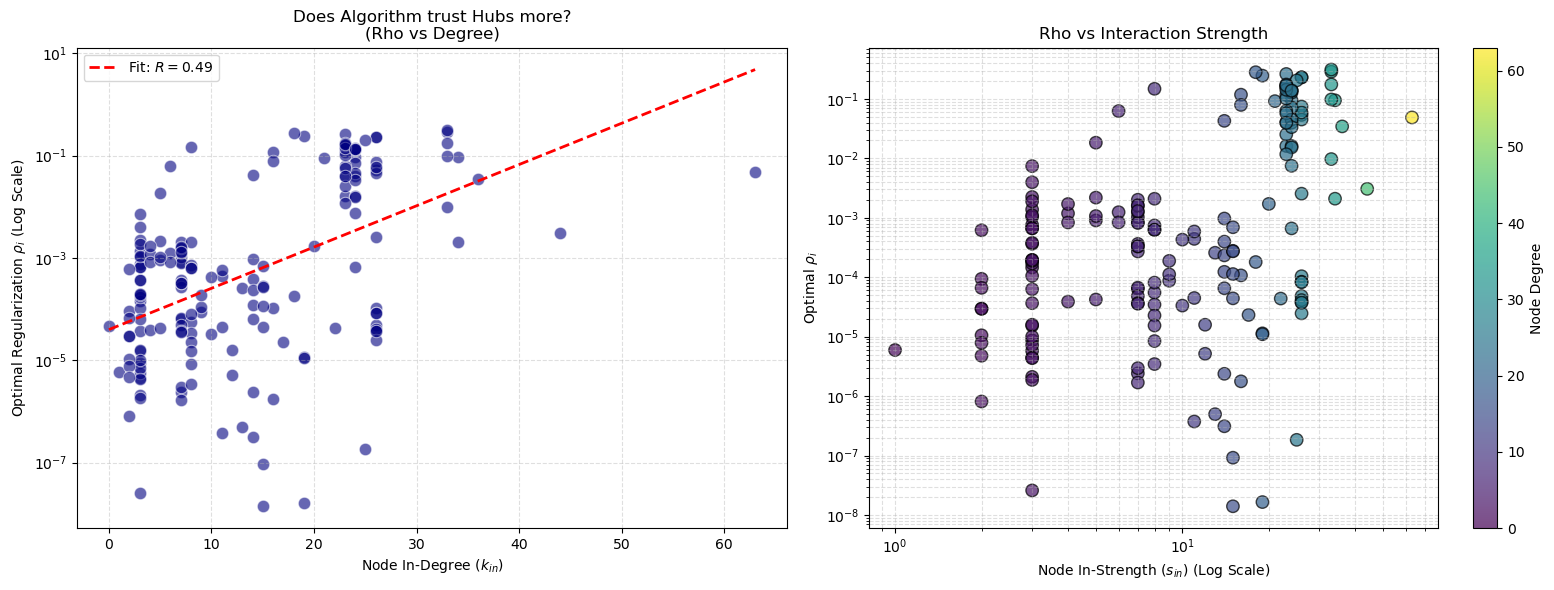

Correlation (Degree vs log(Rho)): 0.4948
>> 观察到正相关：度越大的节点，rho 越大。
   (解释：可能是为了抑制 Hub 节点的过度过拟合？)


In [14]:
plot_rho_degree_relation(rho_hat, A_true)

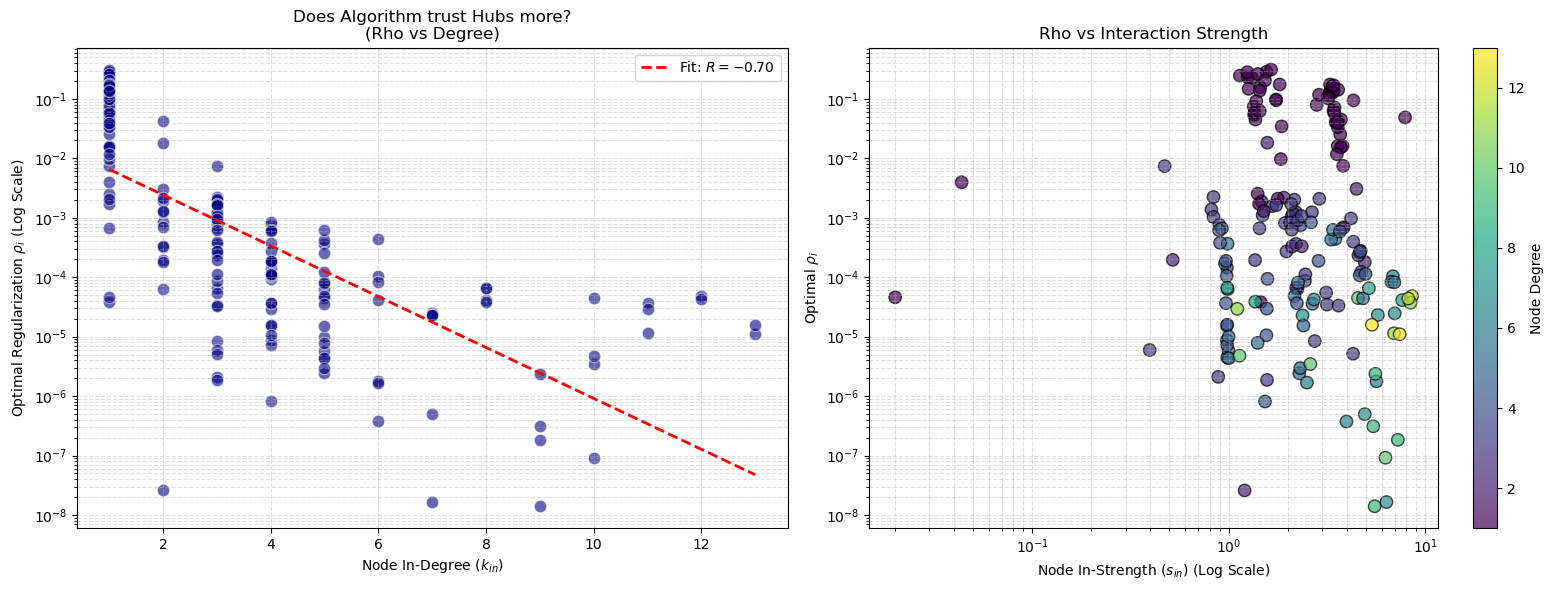

Correlation (Degree vs log(Rho)): -0.7048
>> 观察到负相关：度越大的节点，rho 越小。
   (解释：Hub 节点信号强，LASSO 敢于保留更多边，因此惩罚较小)


In [15]:
plot_rho_degree_relation(rho_hat, A_hat)

In [16]:
rho_best_train = copy.deepcopy(rho_hat)
scales = [0.001, 0.01, 0.1, 0.5, 0.8, 1.0, 1.2, 2.0, 5.0, 10.0]

A_hat_list = []
X_full_pred_list = []
labels = []

for s in scales:
    current_rho = rho_best_train * s
    
    A_temp, _ = reconstruct_network_generic(
        X_train, model, rho=current_rho, threshold=0.01
    )
    
    x0_pred = X_train[-1] 
    steps_to_predict = len(X_obs) - T_train_steps
    
    X_future = model.simulate(A_temp, T_steps=steps_to_predict, init_state=x0_pred)
    
    X_combined = np.vstack([X_train, X_future])
    
    A_hat_list.append(A_temp)
    X_full_pred_list.append(X_combined)
    labels.append(f"Scale {s}x")

Reconstruction (Vector-mode): Use heterogeneous rho list ...
  - Min rho: 1.40e-11
  - Max rho: 3.11e-04
  - Mean rho: 3.01e-05
Reconstruction (Vector-mode): Use heterogeneous rho list ...
  - Min rho: 1.40e-10
  - Max rho: 3.11e-03
  - Mean rho: 3.01e-04
Reconstruction (Vector-mode): Use heterogeneous rho list ...
  - Min rho: 1.40e-09
  - Max rho: 3.11e-02
  - Mean rho: 3.01e-03
Reconstruction (Vector-mode): Use heterogeneous rho list ...
  - Min rho: 7.00e-09
  - Max rho: 1.56e-01
  - Mean rho: 1.51e-02
Reconstruction (Vector-mode): Use heterogeneous rho list ...
  - Min rho: 1.12e-08
  - Max rho: 2.49e-01
  - Mean rho: 2.41e-02
Reconstruction (Vector-mode): Use heterogeneous rho list ...
  - Min rho: 1.40e-08
  - Max rho: 3.11e-01
  - Mean rho: 3.01e-02
Reconstruction (Vector-mode): Use heterogeneous rho list ...
  - Min rho: 1.68e-08
  - Max rho: 3.73e-01
  - Mean rho: 3.61e-02
Reconstruction (Vector-mode): Use heterogeneous rho list ...
  - Min rho: 2.80e-08
  - Max rho: 6.22e-01

In [17]:
def plot_network_and_dynamics_comparison(A_true, A_compare, 
                                         X_true, X_compare, 
                                         T_train_steps, 
                                         num_plot_nodes=20, 
                                         scatter_interval=3,
                                         name_compare="Surrogate"):
    """
    对比两个网络及其动力学轨迹的通用绘图函数。
    包含：
    1. 两个网络的邻接矩阵热图 (Top Row)。
    2. 两个网络的动力学轨迹对比 (Bottom Row, Line vs Scatter)。

    参数:
    -------
    A_true        : np.array, 真实网络矩阵 (Ground Truth)
    A_compare     : np.array, 待比较的网络矩阵 (如 A_hat, A_rdpg 等)
    X_true        : np.array, 真实动力学轨迹
    X_compare     : np.array, 待比较的动力学轨迹
    T_train_steps : int, 训练/预测的分界时间步
    num_plot_nodes: int, 绘制多少个节点 (均匀采样)
    scatter_interval: int, 散点绘制的间隔 (防止点太密)
    name_compare  : str, 待比较对象的名称 (用于图标题和图例，如 "A_hat", "RDPG")
    """
    
    # 1. 基础数据准备
    N = A_true.shape[0]
    T_total_steps = X_true.shape[0]
    time_steps = np.arange(T_total_steps)

    # 2. 确定要绘制的节点
    if num_plot_nodes > N: 
        num_plot_nodes = N
    # 均匀选择节点索引
    nodes_to_plot = np.linspace(0, N-1, num_plot_nodes, dtype=int)
    
    # 3. 生成颜色映射 (沿用你喜欢的 tab10)
    # 如果节点数少于10，直接取色；多于10则插值
    if num_plot_nodes <= 10:
        colors = [plt.cm.tab10(i) for i in range(num_plot_nodes)]
    else:
        colors = plt.cm.tab10(np.linspace(0, 1, num_plot_nodes))

    # ==========================================
    # 开始绘图
    # ==========================================
    fig = plt.figure(figsize=(14, 10))
    grid = plt.GridSpec(2, 2, height_ratios=[1, 1.5])

    # --- 图 1: 网络拓扑对比 (Top Left: True) ---
    ax1 = fig.add_subplot(grid[0, 0])
    cax1 = ax1.imshow(A_true, cmap='Blues', interpolation='nearest')
    ax1.set_title("True Network ($A_{true}$)")
    fig.colorbar(cax1, ax=ax1)

    # --- 图 2: 网络拓扑对比 (Top Right: Compare) ---
    ax2 = fig.add_subplot(grid[0, 1])
    cax2 = ax2.imshow(A_compare, cmap='Reds', interpolation='nearest')
    ax2.set_title(f"Comparison Network ({name_compare})")
    fig.colorbar(cax2, ax=ax2)

    # 计算拓扑相关性
    flatten_true = A_true.flatten()
    flatten_compare = A_compare.flatten()
    corr = np.corrcoef(flatten_true, flatten_compare)[0, 1]
    ax2.set_xlabel(f"Topology Correlation: {corr:.4f}")

    # --- 图 3: 动力学轨迹对比 (Bottom: Dynamics) ---
    ax3 = fig.add_subplot(grid[1, :])

    for idx, node_idx in enumerate(nodes_to_plot):
        color = colors[idx]
        
        # A. 绘制真实轨迹 (实线)
        ax3.plot(time_steps, X_true[:, node_idx], 
                 color=color, linestyle='-', linewidth=2, alpha=0.6,
                 label=f'Node {node_idx} (True)' if idx == 0 else None)
        
        # B. 绘制 对比轨迹 (散点 - 空心圆)
        sparse_indices = np.arange(0, T_total_steps, scatter_interval)
        
        # 确保索引不越界 (防止 X_compare 长度不够)
        sparse_indices = sparse_indices[sparse_indices < len(X_compare)]
        
        ax3.scatter(time_steps[sparse_indices], X_compare[sparse_indices, node_idx], 
                    edgecolors=color,    # 边框颜色
                    facecolors='none',   # 内部透明
                    marker='o',          # 圆圈
                    s=40,                # 大小
                    linewidth=1.5,       # 线宽
                    label=f'Node {node_idx} ({name_compare})' if idx == 0 else None)

    # 添加训练/预测分界线
    ax3.axvline(x=T_train_steps, color='k', linestyle=':', linewidth=2, alpha=0.8)
    
    # 动态调整标题和标签
    ax3.set_title(f"Dynamics: True (Line) vs {name_compare} (Scatter)\n(Showing {num_plot_nodes} nodes)", fontsize=14)
    ax3.set_xlabel("Time Steps", fontsize=12)
    ax3.set_ylabel("State $x_i(t)$", fontsize=12)

    # --- 优化图例 ---
    custom_lines = [
        Line2D([0], [0], color='gray', lw=2, linestyle='-'),
        Line2D([0], [0], color='gray', marker='o', linestyle='None', 
               markerfacecolor='none', markeredgewidth=1.5)
    ]
    ax3.legend(custom_lines, 
               ['True Dynamics (Ground Truth)', f'{name_compare} Simulation'], 
               loc='upper left', fontsize=10)

    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [18]:
scales

[0.001, 0.01, 0.1, 0.5, 0.8, 1.0, 1.2, 2.0, 5.0, 10.0]

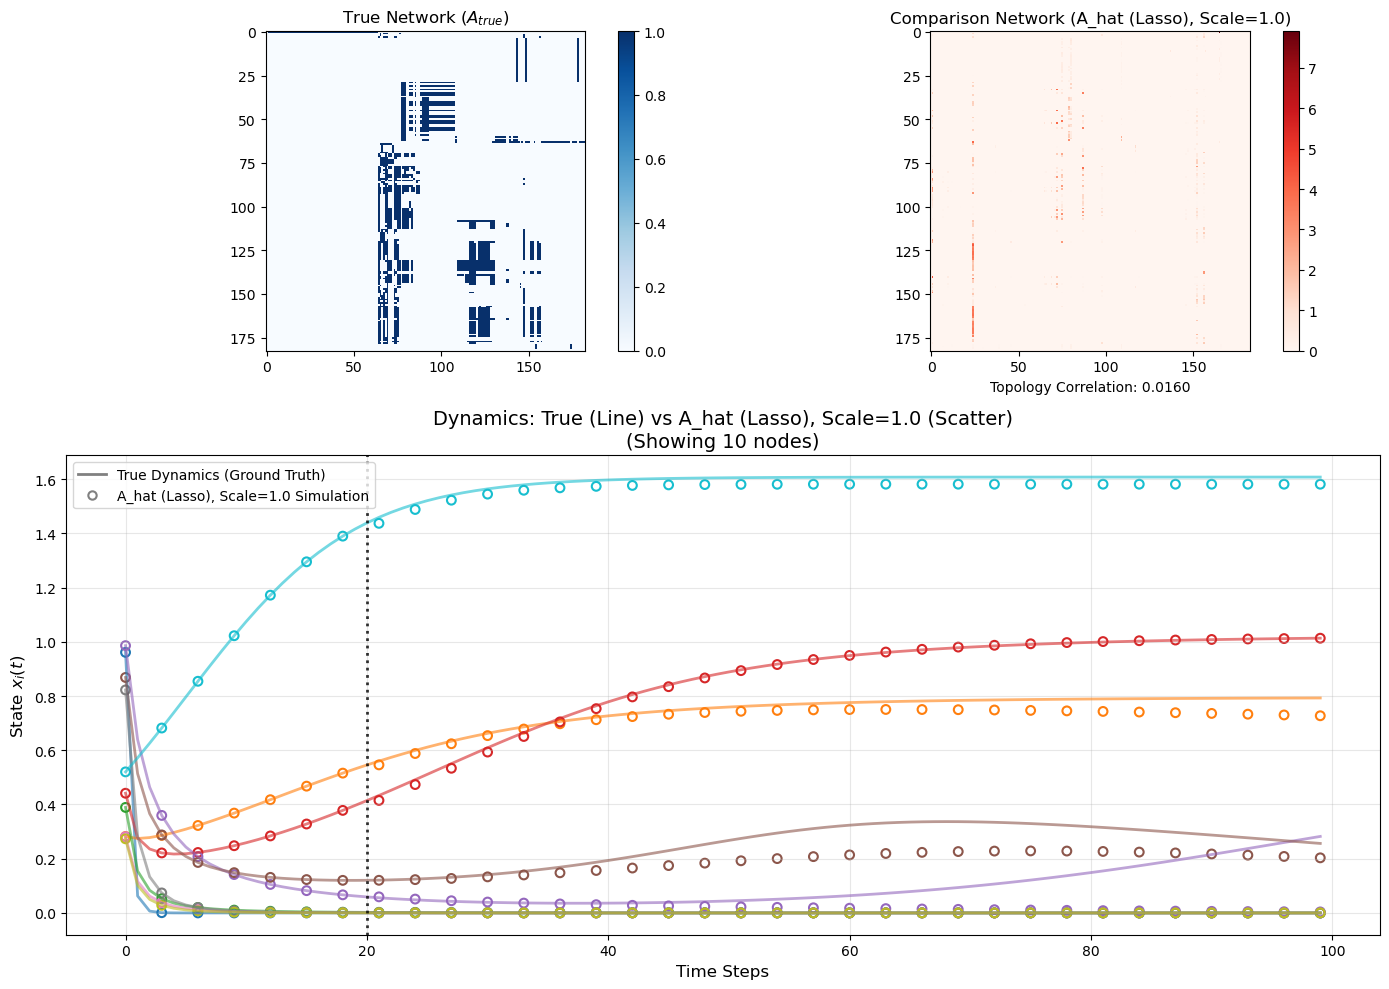

In [21]:
prediction_index = 5
plot_network_and_dynamics_comparison(
    A_true=A_true, 
    A_compare=A_hat, 
    X_true=X_obs, 
    X_compare=X_full_pred_list[prediction_index], 
    T_train_steps=T_train_steps,
    num_plot_nodes=10, 
    name_compare=f"A_hat (Lasso), Scale={scales[prediction_index]}"
)

In [22]:
def compare_prediction_errors_recorder(X_true, pred_dict, t_split, dt=0.1, title=None):
    """
    升级版误差对比图 (Recorder 版)：
    1. 绘图功能与 v6 完全一致 (Scale 适配 / 色谱取色 / Auto 高亮)。
    2. 【新增功能】返回一个列表，包含每条曲线的 label, value (scale/rho), mean_mae, final_mae。
    
    返回:
    -------
    error_records : list of dict
        [{'label': str, 'value': float, 'mean_mae': float, 'final_mae': float}, ...]
        按 value 从小到大排序。
    """
    
    # 1. 准备真值
    X_ref = X_true[t_split:]
    if len(X_ref) == 0: return []
    T_future = len(X_ref)
    time_horizon = np.arange(T_future) * dt
    
    # 2. 解析并排序数据
    sorted_items = []
    all_values = []
    
    for label, X_pred in pred_dict.items():
        # 正则解析 Scale 或 Rho
        match_scale = re.search(r"Scale\s*([\d\.eE\-\+]+)x?", label, re.IGNORECASE)
        match_rho = re.search(r"rho=([\d\.eE\-\+]+)", label, re.IGNORECASE)
        
        if match_scale:
            val = float(match_scale.group(1))
            val_type = 'Scale'
        elif match_rho:
            val = float(match_rho.group(1))
            val_type = 'Rho'
        else:
            val = 0.0
            val_type = 'Unknown'
            
        # 判定是否为 Auto/Base
        is_auto = "auto" in label.lower() or (val_type == 'Scale' and abs(val - 1.0) < 1e-6)
        
        sorted_items.append({
            'val': val,
            'label': label,
            'data': X_pred,
            'is_auto': is_auto
        })
        
        if val > 0:
            all_values.append(val)
    
    # 按数值从小到大排序
    sorted_items.sort(key=lambda x: x['val'])
    
    # 3. 颜色映射
    if len(all_values) > 0:
        min_v, max_v = min(all_values), max(all_values)
        norm = mcolors.LogNorm(vmin=min_v, vmax=max_v)
        cmap = plt.get_cmap('jet')
    else:
        norm = None
        cmap = None

    # 4. 绘图与记录
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # 用于存储返回结果的列表
    error_records = []
    
    print("-" * 80)
    print(f"{'Label':<40} | {'Mean MAE':<10} | {'Final MAE':<10} | {'Style'}")
    print("-" * 80)
    
    for item in sorted_items:
        X_pred = item['data']
        label = item['label']
        is_auto = item['is_auto']
        val = item['val']
        
        # 数据对齐
        X_p = X_pred[t_split:]
        if len(X_p) < T_future:
            curr_X_ref = X_ref[:len(X_p)]
            curr_time = time_horizon[:len(X_p)]
        else:
            curr_X_ref = X_ref
            X_p = X_p[:T_future]
            curr_time = time_horizon
            
        # 计算误差
        abs_diff = np.abs(curr_X_ref - X_p)
        epsilon_t = np.mean(abs_diff, axis=1) # 随时间变化的 MAE
        
        # 统计指标
        epsilon_bar = np.mean(epsilon_t)      # 全局平均
        final_error = epsilon_t[-1] if len(epsilon_t) > 0 else 0.0 # 最终时刻误差
        
        # --- 存入记录列表 ---
        error_records.append({
            'label': label,
            'value': val,       # Scale 或 Rho 的数值
            'mean_mae': epsilon_bar,
            'final_mae': final_error,
            'is_auto': is_auto
        })
        
        # --- 样式逻辑 ---
        if cmap and norm and val > 0:
            c = cmap(norm(val))
        else:
            c = 'gray'
            
        if is_auto:
            ls = '-.'
            lw = 2.0
            zorder = 100
            plot_label = f"★ {label}"
            style_desc = "Dash-dot (Auto)"
        else:
            ls = '-'
            lw = 1.5
            zorder = 10
            plot_label = label
            style_desc = "Solid"
            
        print(f"{label:<40} | {epsilon_bar:.6f}   | {final_error:.6f}   | {style_desc}")
            
        ax.plot(curr_time, epsilon_t, 
                color=c, linewidth=lw, linestyle=ls, alpha=0.8, zorder=zorder,
                label=f"{plot_label}")

    # 5. 装饰
    ax.set_xlabel(r"Prediction Time Horizon $\tilde{t}$", fontsize=12)
    ax.set_ylabel(r"MAE $\epsilon(\tilde{t})$", fontsize=12)
    
    title_str = title if title else "Prediction Error Evolution vs. Parameter Scale"
    ax.set_title(title_str, fontsize=14)
    
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=9)
    ax.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    return error_records

--------------------------------------------------------------------------------
Label                                    | Mean MAE   | Final MAE  | Style
--------------------------------------------------------------------------------
Scale 0.001x                             | 0.043256   | 0.074380   | Solid
Scale 0.01x                              | 0.046366   | 0.082577   | Solid
Scale 0.1x                               | 0.031091   | 0.051612   | Solid
Scale 0.5x                               | 0.038295   | 0.074107   | Solid
Scale 0.8x                               | 0.039620   | 0.075895   | Solid
Scale 1.0x                               | 0.037738   | 0.071443   | Dash-dot (Auto)
Scale 1.2x                               | 0.046476   | 0.093908   | Solid
Scale 2.0x                               | 0.075241   | 0.192612   | Solid
Scale 5.0x                               | 0.101547   | 0.258299   | Solid
Scale 10.0x                              | 0.141045   | 0.325030   | Solid


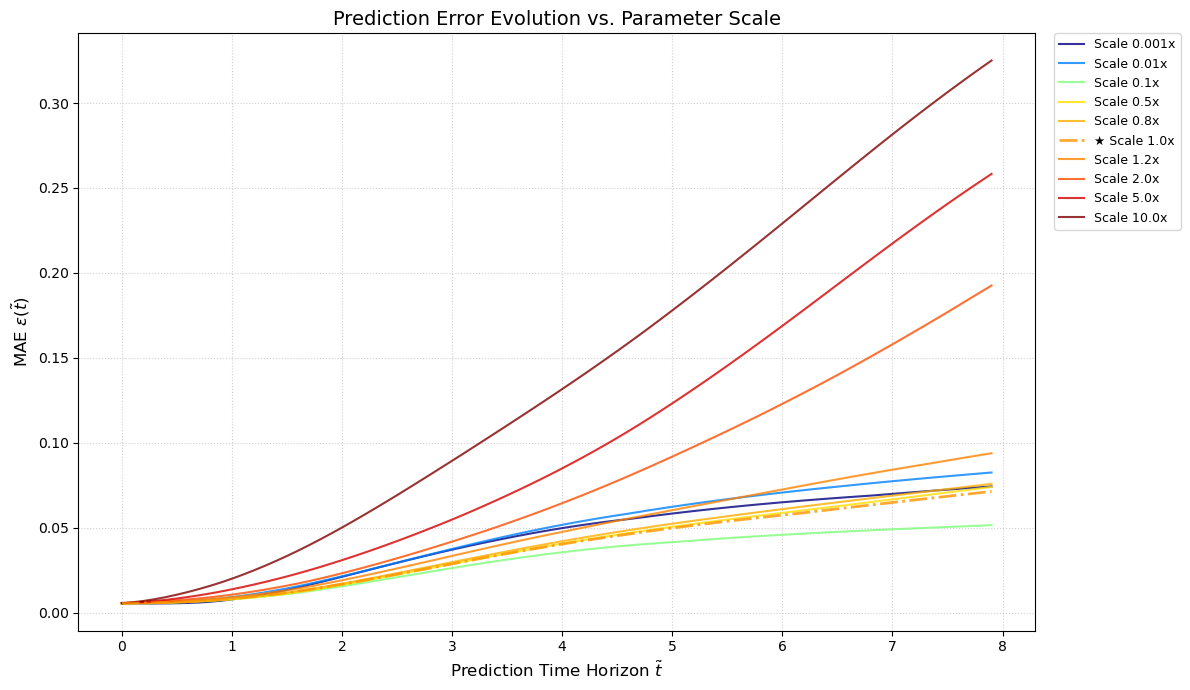

In [27]:
pred_results = dict(zip(labels, X_full_pred_list))
records = compare_prediction_errors_recorder(X_obs, pred_results, T_train_steps)

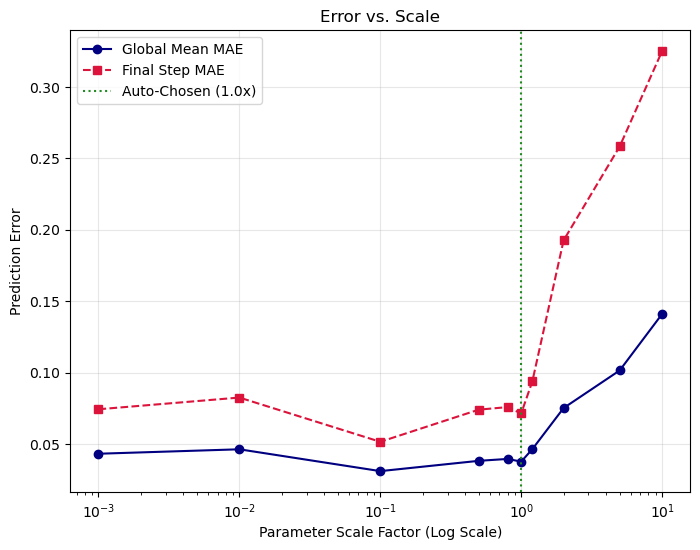

In [29]:
scales_val = [r['value'] for r in records]
mean_maes = [r['mean_mae'] for r in records]
final_maes = [r['final_mae'] for r in records]

plt.figure(figsize=(8, 6))

plt.plot(scales_val, mean_maes, 'o-', color='navy', label='Global Mean MAE')
plt.plot(scales_val, final_maes, 's--', color='crimson', label='Final Step MAE')

plt.axvline(1.0, color='forestgreen', linestyle=':', label='Auto-Chosen (1.0x)')

plt.xscale('log') # Scale 通常跨度大，用对数轴
plt.xlabel('Parameter Scale Factor (Log Scale)')
plt.ylabel('Prediction Error')
plt.title('Error vs. Scale')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<font color = black size = 5>Compare ranks, rank_true & rank_hat</font>

In [30]:
def get_comprehensive_metrics(A, name="Network", threshold=1e-5):
    """
    SVD, ranks, topology(degree distribution)
    """
    U, S, Vt = svd(A, full_matrices=False)
    
    # effective rank
    sigma_1 = S[0] if S[0] > 1e-12 else 1.0
    srank = np.sum(S**2) / (sigma_1**2)
    nrank = np.sum(S) / sigma_1
    p = S / np.sum(S)
    p = p[p > 1e-12]
    erank = np.exp(-np.sum(p * np.log(p)))
    
    binary_A = (np.abs(A) > threshold).astype(int)
    in_degrees = np.sum(binary_A, axis=1) 
    
    return {
        "name": name,
        "U": U, "S": S, "Vt": Vt,
        "ranks": {
            "Stable": srank, 
            "Nuclear": nrank, 
            "Entropy": erank
        },
        "topology": {
            "in_degrees": in_degrees,
            "num_edges": np.sum(binary_A),
            "binary_matrix": binary_A
        },
        "shape": A.shape
    }

In [31]:
all_metrics = []

N = A_true.shape[0]
print(f"Computing true network (N={N})...")

metrics_true = get_comprehensive_metrics(A_true, name="True Network")
all_metrics.append(metrics_true)

# 2. 计算代理网络列表 (Surrogates)
print(f"Computing {len(A_hat_list)} surrogate networks...")

# names = [f"Lasso (rho={r:.1e})" for r in rho_values]  # numbers
names = [f"Lasso (Scale {s}x)" for s in scales]  # scales

for A_h, name in zip(A_hat_list, names):
    m = get_comprehensive_metrics(A_h, name=name)
    all_metrics.append(m)

print("-" * 30)
print(f"Computing finish! {len(all_metrics)} sets data saved to 'all_metrics'")
print("Data structure keys:", all_metrics[0].keys())

Computing true network (N=183)...
Computing 10 surrogate networks...
------------------------------
Computing finish! 11 sets data saved to 'all_metrics'
Data structure keys: dict_keys(['name', 'U', 'S', 'Vt', 'ranks', 'topology', 'shape'])


In [32]:
# -----------------------------------------------------------
# 辅助函数：符号对齐 (保持不变，但至关重要)
# -----------------------------------------------------------
def align_svd_signs(U_ref, Vt_ref, U_target, Vt_target):
    U_new = U_target.copy()
    Vt_new = Vt_target.copy()
    
    k = min(U_ref.shape[1], U_target.shape[1])
    
    for i in range(k):
        # 检查 U 的每一列方向
        if np.dot(U_ref[:, i], U_target[:, i]) < 0:
            U_new[:, i] *= -1
            Vt_new[i, :] *= -1
            
    return U_new, Vt_new

# -----------------------------------------------------------
# 主函数：6-Panel 均衡对比 (S, U, V 全覆盖)
# -----------------------------------------------------------
def plot_balanced_svd_comparison(metrics_list, top_k_modes=10):
    """
    绘制 SVD 全维度对比图 (2x3 Layout)。
    修改点：图3 改为 U 向量相似度。
    """
    n_matrices = len(metrics_list)
    if n_matrices < 2:
        print("Error: Need at least 2 matrices.")
        return

    mt = metrics_list[0]      # Ground Truth
    m_hats = metrics_list[1:] # Surrogates
    
    # 颜色策略
    color_true = 'navy'
    colors = [color_true] + [cm.tab10(i + 1) for i in range(len(m_hats))]
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    # fig.suptitle(f"SVD Analysis: S (Energy), U (Nodes), V (Patterns)", fontsize=18, y=0.96)
    
    # ====================================================
    # 图 1: 有效秩 (Effective Ranks) - 保持不变
    # ====================================================
    ax1 = axes[0, 0]
    rank_keys = ['Stable', 'Nuclear', 'Entropy']
    total_width = 0.8
    bar_width = total_width / n_matrices
    x_base = np.arange(len(rank_keys))
    
    ax1.bar(x_base - (total_width-bar_width)/2, [mt['ranks'][k] for k in rank_keys], 
            width=bar_width, label=mt['name'], color=colors[0], alpha=0.9)
    
    for idx, mh in enumerate(m_hats):
        curr_x = x_base - (total_width-bar_width)/2 + (idx+1)*bar_width
        ax1.bar(curr_x, [mh['ranks'][k] for k in rank_keys], 
                width=bar_width, label=mh['name'], color=colors[idx+1], alpha=0.7)

    ax1.set_xticks(x_base)
    ax1.set_xticklabels(rank_keys)
    ax1.set_title("1. Effective Ranks Overview")
    ax1.legend(fontsize=9)
    ax1.grid(axis='y', alpha=0.3)

    # ====================================================
    # 图 2: 奇异值谱 (Spectrum) - 保持不变
    # ====================================================
    ax2 = axes[0, 1]
    ax2.plot(mt['S'], 'o-', color=colors[0], label=mt['name'], lw=2, markersize=4, alpha=0.8)
    for idx, mh in enumerate(m_hats):
        ax2.plot(mh['S'], '.--', color=colors[idx+1], label=mh['name'], lw=1.5, alpha=0.7)
    ax2.set_yscale('log')
    ax2.set_title("2. Singular Value Spectrum (Log Scale)")
    ax2.set_xlabel("Mode Index $k$")
    ax2.set_ylabel(r"$\sigma_k$")
    ax2.grid(True, alpha=0.3)

    # ====================================================
    # 图 3: [新] U 向量相似度 (Node Space Alignment)
    # ====================================================
    ax3 = axes[0, 2]
    modes = np.arange(1, top_k_modes + 1)
    
    for idx, mh in enumerate(m_hats):
        # 1. 符号对齐 (U 极其敏感，必须对齐)
        U_al, _ = align_svd_signs(mt['U'], mt['Vt'], mh['U'], mh['Vt'])
        
        sims = []
        for k in range(top_k_modes):
            # 确保不越界
            if k < mt['U'].shape[1] and k < U_al.shape[1]:
                u1 = mt['U'][:, k]
                u2 = U_al[:, k]
                # 计算余弦相似度 (因为已对齐符号，期望值为 1.0)
                sim = np.dot(u1, u2) / (np.linalg.norm(u1) * np.linalg.norm(u2))
                sims.append(sim)
            else:
                sims.append(0)
        
        ax3.plot(modes, sims, 'o-', color=colors[idx+1], label=f"{mh['name']} vs True", alpha=0.8)
    
    ax3.set_ylim(0, 1.1)
    ax3.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
    ax3.set_title(r"3. Node Space Match (Cosine Sim of $U_k$)")
    ax3.set_xlabel("Mode Index $k$")
    ax3.set_ylabel("Similarity")
    ax3.grid(True, alpha=0.3)

    # ====================================================
    # 图 4: 节点嵌入 (U Scatter) - 保持不变
    # ====================================================
    ax4 = axes[1, 0]
    ax4.scatter(mt['U'][:, 0], mt['U'][:, 1], c=colors[0], label=mt['name'], s=50, alpha=0.6)
    for idx, mh in enumerate(m_hats):
        U_al, _ = align_svd_signs(mt['U'], mt['Vt'], mh['U'], mh['Vt'])
        ax4.scatter(U_al[:, 0], U_al[:, 1], color=colors[idx+1], label=mh['name'], marker='+', s=60, alpha=0.8)
        # 连线
        if idx == 0:
            for i in range(len(mt['U'])):
                ax4.plot([mt['U'][i, 0], U_al[i, 0]], [mt['U'][i, 1], U_al[i, 1]], color='gray', alpha=0.1)

    ax4.set_title("4. Node Embedding (Top-2 U)")
    ax4.set_xlabel("Dim 1")
    ax4.set_ylabel("Dim 2")
    ax4.grid(True, alpha=0.3)

    # ====================================================
    # 图 5: V 向量相似度 (Pattern Alignment) - 保持不变
    # ====================================================
    ax5 = axes[1, 1]
    for idx, mh in enumerate(m_hats):
        _, Vt_al = align_svd_signs(mt['U'], mt['Vt'], mh['U'], mh['Vt'])
        sims = []
        for k in range(top_k_modes):
            if k < mt['Vt'].shape[0] and k < Vt_al.shape[0]:
                v1 = mt['Vt'][k]
                v2 = Vt_al[k]
                sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
                sims.append(sim)
            else:
                sims.append(0)
        ax5.plot(modes, sims, 'o-', color=colors[idx+1], label=mh['name'], alpha=0.8)
        
    ax5.set_ylim(0, 1.1)
    ax5.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
    ax5.set_title(r"5. Interaction Mode Match (Cosine Sim of $V^T_k$)")
    ax5.set_xlabel("Mode Index $k$")
    ax5.grid(True, alpha=0.3)

    # ====================================================
    # 图 6: 模式热图 (V Heatmap) - 保持不变
    # ====================================================
    ax6 = axes[1, 2]
    k_heat = 5
    stack_list = []
    ytick_labels = []
    curr_y = 0
    
    # True
    stack_list.append(mt['Vt'][:k_heat])
    stack_list.append(np.full((1, mt['Vt'].shape[1]), np.nan))
    ytick_labels.extend([f"T-{i+1}" for i in range(k_heat)])
    curr_y += k_heat + 1
    
    # Hats
    for idx, mh in enumerate(m_hats):
        _, Vt_al = align_svd_signs(mt['U'], mt['Vt'], mh['U'], mh['Vt'])
        stack_list.append(Vt_al[:k_heat])
        stack_list.append(np.full((1, mt['Vt'].shape[1]), np.nan))
        ytick_labels.extend([f"H{idx+1}-{i+1}" for i in range(k_heat)])
        curr_y += k_heat + 1
        
    full_mat = np.vstack(stack_list)
    cax = ax6.imshow(full_mat, aspect='auto', cmap='RdBu_r', vmin=-0.3, vmax=0.3)
    
    # 手动设置 Y 轴 Label 位置 (居中于每个条带)
    # 计算每个 block 的中心位置
    # True: 0~k -> k/2
    # Hat1: k+1 ~ 2k+1 -> k+1 + k/2
    label_locs = []
    for i in range(len(m_hats) + 1):
        start = i * (k_heat + 1)
        for j in range(k_heat):
            label_locs.append(start + j)
            
    ax6.set_yticks(label_locs)
    ax6.set_yticklabels(ytick_labels, fontsize=8)
    ax6.set_title(f"6. Interaction Modes Heatmap (Top {k_heat})")
    plt.colorbar(cax, ax=ax6)

    plt.tight_layout()
    plt.show()

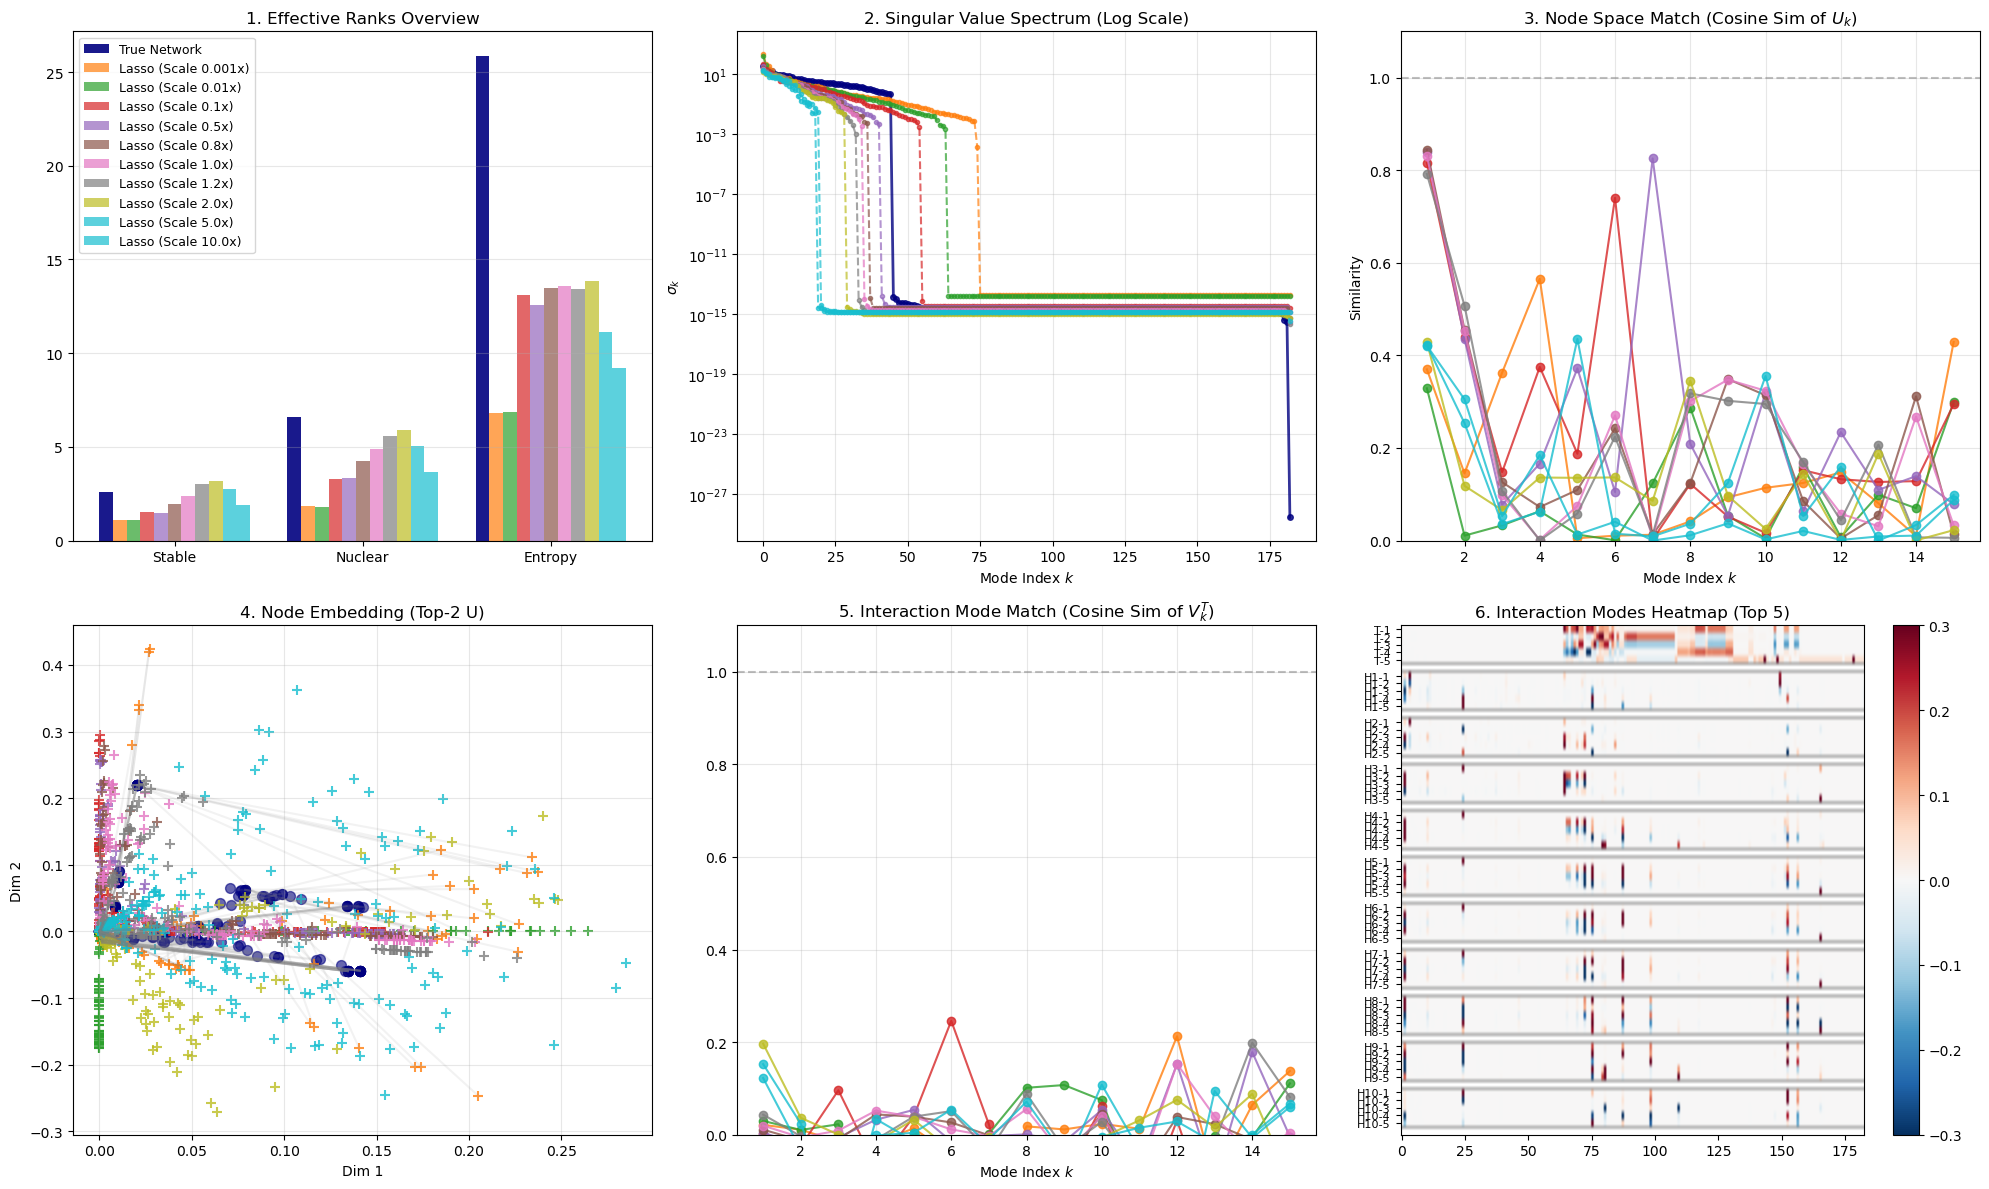

In [33]:
plot_balanced_svd_comparison(all_metrics, top_k_modes=15)

<font color = black size = 5>Compare projections in dynamic subspace, Core_true & Core_hat</font>

In [34]:
def extract_dynamical_basis(X_obs, energy_threshold=0.95, min_k=3):
    U, S, _ = svd(X_obs.T, full_matrices=False)
    
    energy = np.cumsum(S**2) / np.sum(S**2)
    k = np.searchsorted(energy, energy_threshold) + 1
    k = max(k, min_k)

    return U[:, :k]

In [35]:
def plot_core_analysis(core_true, core_hat_list, scales, max_cols=4, figsize_per_subplot=(3, 2.5)):
    """
    分析并可视化core矩阵。
    
    Parameters
    ----------
    core_true : ndarray
        真实的core矩阵
    core_hat_list : list of ndarray
        估计的core矩阵列表
    scales : list
        与core_hat_list一一对应的scale值
    max_cols : int
        热力图每行最多显示多少个子图
    figsize_per_subplot : tuple
        每个子图的大小
    """
    
    # ========== 1. 计算Pearson相关系数 ==========
    flat_true = core_true.flatten()
    correlations = []
    for core_hat in core_hat_list:
        corr = np.corrcoef(flat_true, core_hat.flatten())[0, 1]
        correlations.append(corr)
    
    # ========== 2. 绘制热力图 ==========
    n_plots = 1 + len(core_hat_list)  # core_true + 所有core_hat
    n_rows = int(np.ceil(n_plots / max_cols))
    n_cols = min(n_plots, max_cols)
    
    fig1, axes = plt.subplots(n_rows, n_cols, 
                               figsize=(figsize_per_subplot[0]*n_cols, figsize_per_subplot[1]*n_rows))
    axes = np.atleast_2d(axes)  # 确保axes是2D数组
    
    # 统一色彩范围
    all_cores = [core_true] + core_hat_list
    vmin = min(c.min() for c in all_cores)
    vmax = max(c.max() for c in all_cores)
    
    for idx in range(n_plots):
        row, col = idx // max_cols, idx % max_cols
        ax = axes[row, col]
        
        if idx == 0:
            # core_true
            im = ax.imshow(core_true, cmap='RdBu_r', aspect='auto', vmin=vmin, vmax=vmax)
            ax.set_title('core_true', fontsize=10)
        else:
            # core_hat
            core_hat = core_hat_list[idx - 1]
            scale = scales[idx - 1]
            corr = correlations[idx - 1]
            im = ax.imshow(core_hat, cmap='RdBu_r', aspect='auto', vmin=vmin, vmax=vmax)
            ax.set_title(f'scale={scale}\nr={corr:.3f}', fontsize=9)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    # 隐藏多余的子图
    for idx in range(n_plots, n_rows * n_cols):
        row, col = idx // max_cols, idx % max_cols
        axes[row, col].axis('off')
    
    # 调整布局，右侧留出空间给colorbar
    plt.tight_layout()
    fig1.subplots_adjust(right=0.88)
    
    # 添加colorbar到右侧
    cbar_ax = fig1.add_axes([0.91, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig1.colorbar(im, cax=cbar_ax, label='Value')
    # fig1.suptitle('Core Matrices Heatmaps', fontsize=12, y=0.98)
    
    # ========== 3. 绘制correlation vs scales散点图 ==========
    fig2, ax2 = plt.subplots(figsize=(8, 5))
    
    # 基础散点
    ax2.scatter(scales, correlations, s=80, c='steelblue', alpha=0.7, label='All scales')
    
    # 标出correlation最大的点
    max_idx = np.argmax(correlations)
    ax2.scatter(scales[max_idx], correlations[max_idx], s=100, marker='*', 
                c='red', edgecolors='darkred', linewidths=1.5, zorder=5,
                label=f'Max corr: scale={scales[max_idx]}, r={correlations[max_idx]:.3f}')
    
    # 标出scale=1的点（如果存在）
    if 1.0 in scales:
        idx_one = scales.index(1.0)
        ax2.scatter(scales[idx_one], correlations[idx_one], s=100, marker='^',
                    c='lime', edgecolors='darkgreen', linewidths=1.5, zorder=5,
                    label=f'Scale=1: r={correlations[idx_one]:.3f}')
    
    ax2.set_xscale('log')
    ax2.set_xlabel('Scale (log)', fontsize=11)
    ax2.set_ylabel('Pearson Correlation', fontsize=11)
    ax2.set_title('Core Correlation vs Scale', fontsize=12)
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)
    
    # 添加连线帮助观察趋势
    ax2.plot(scales, correlations, 'k--', alpha=0.3, zorder=1)
    
    plt.tight_layout()
    plt.show()
    
    return correlations

In [92]:
# def analyze_core_evolution_scales(core_true, core_hat_list, scales, max_cols=5):
#     """
#     分析 Core 矩阵随 Scale 变化的演化过程 (修正版)。
    
#     修正点:
#     - 自动定位 Scale=1.0 的索引作为 Auto-Chosen，而不是默认取第一个。
#     """
    
#     num_hats = len(core_hat_list)
#     if len(scales) != num_hats:
#         print(f"Error: scales length ({len(scales)}) != core_hat_list length ({num_hats})")
#         return

#     total_plots = num_hats + 1 
    
#     # ==========================================
#     # 1. 计算布局
#     # ==========================================
#     n_rows_heat = (total_plots + max_cols - 1) // max_cols
#     fig_width = 3.5 * max_cols
#     fig_height = 3.2 * n_rows_heat + 5 
    
#     fig = plt.figure(figsize=(fig_width, fig_height))
    
#     height_ratios = [1] * n_rows_heat + [1.5]
#     gs = gridspec.GridSpec(n_rows_heat + 1, max_cols, height_ratios=height_ratios, hspace=0.4, wspace=0.3)
    
#     # ==========================================
#     # 2. 计算相关性 & 动态寻找特殊点
#     # ==========================================
#     correlations = []
#     flat_true = core_true.flatten()
#     max_val = np.max(np.abs(core_true))
    
#     for chat in core_hat_list:
#         max_val = max(max_val, np.max(np.abs(chat)))
#         curr_corr = np.corrcoef(flat_true, chat.flatten())[0, 1]
#         correlations.append(curr_corr)
    
#     vmin, vmax = -max_val, max_val
    
#     # --- 关键修正：寻找 Scale == 1.0 的索引 ---
#     try:
#         # 转为 array 以支持布尔索引
#         scales_arr = np.array(scales)
#         # 找到最接近 1.0 的那个值的索引
#         auto_idx = np.where(np.isclose(scales_arr, 1.0))[0][0]
#     except IndexError:
#         auto_idx = -1 # 列表中没有 1.0
        
#     # 寻找最佳相关性索引
#     best_idx = np.argmax(correlations)
    
#     # 获取对应的值
#     best_scale = scales[best_idx]
#     best_corr = correlations[best_idx]
    
#     if auto_idx != -1:
#         auto_scale = scales[auto_idx]
#         auto_corr = correlations[auto_idx]
    
#     # ==========================================
#     # 3. 绘制热力图 (Grid Loop)
#     # ==========================================
    
#     # --- A. True Core ---
#     ax_true = fig.add_subplot(gs[0, 0])
#     im = ax_true.imshow(core_true, cmap='RdBu_r', vmin=vmin, vmax=vmax)
#     ax_true.set_title("True Core\n($U^T A_{true} U$)", fontsize=12, fontweight='bold')
#     ax_true.set_xticks([]); ax_true.set_yticks([])
    
#     # --- B. Hats ---
#     for i, (chat, s) in enumerate(zip(core_hat_list, scales)):
#         grid_idx = i + 1
#         row = grid_idx // max_cols
#         col = grid_idx % max_cols
        
#         ax = fig.add_subplot(gs[row, col])
#         ax.imshow(chat, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        
#         # 标题高亮逻辑
#         if i == auto_idx:
#             # 自动选择 (Scale=1.0) -> 绿色
#             title_str = f"[Auto]\nScale {s}x\nCorr: {correlations[i]:.3f}"
#             title_color = "forestgreen"
#             weight = 'bold'
#         elif i == best_idx:
#             # 最佳表现 -> 红色
#             title_str = f"[Best]\nScale {s}x\nCorr: {correlations[i]:.3f}"
#             title_color = "crimson"
#             weight = 'bold'
#         else:
#             # 普通 -> 黑色
#             title_str = f"Scale {s}x\nCorr: {correlations[i]:.3f}"
#             title_color = "black"
#             weight = 'normal'
            
#         ax.set_title(title_str, fontsize=11, color=title_color, fontweight=weight)
#         ax.set_xticks([]); ax.set_yticks([])
        
#         # 仅在最后一个子图加 Colorbar
#         if i == num_hats - 1:
#              plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

#     # ==========================================
#     # 4. 绘制散点图 (Bottom Section)
#     # ==========================================
#     ax_scatter = fig.add_subplot(gs[n_rows_heat, :])
    
#     # A. 普通点
#     ax_scatter.scatter(scales, correlations, color='navy', s=80, alpha=0.6, label='Experiment Runs')
    
#     # B. Auto 点 (绿色叉)
#     if auto_idx != -1:
#         ax_scatter.scatter(auto_scale, auto_corr, color='forestgreen', marker='x', s=250, 
#                            linewidth=4, zorder=20, label=f'Auto-Chosen (1.0x)')
    
#     # C. Best 点 (红色星)
#     if best_idx != auto_idx:
#         ax_scatter.scatter(best_scale, best_corr, color='crimson', marker='*', s=350, 
#                            edgecolors='white', linewidth=1, zorder=15, label=f'Best Match ({best_scale}x)')
#     else:
#         # 如果 Auto 就是 Best，画红圈套绿叉
#         ax_scatter.scatter(best_scale, best_corr, s=500, facecolors='none', edgecolors='crimson', 
#                            linewidth=2, linestyle='--', label='Auto is Best!')

#     # D. 标注
#     if auto_idx != -1:
#         ax_scatter.annotate(f'Auto: {auto_corr:.3f}', xy=(auto_scale, auto_corr), 
#                             xytext=(-40, -40), textcoords='offset points',
#                             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="forestgreen", alpha=0.9),
#                             arrowprops=dict(arrowstyle="->", color="forestgreen"))
    
#     if best_idx != auto_idx:
#         ax_scatter.annotate(f'Best: {best_corr:.3f}', xy=(best_scale, best_corr), 
#                             xytext=(40, -40), textcoords='offset points',
#                             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="crimson", alpha=0.9),
#                             arrowprops=dict(arrowstyle="->", color="crimson"))

#     # 装饰
#     ax_scatter.set_xscale('log')
#     ax_scatter.set_xlabel(r"Parameter Scaling Factor (Log Scale)", fontsize=14)
#     ax_scatter.set_ylabel("Core Correlation", fontsize=14)
#     ax_scatter.set_title("Sensitivity Analysis: How Scaling Affects Backbone Recovery", fontsize=16)
    
#     y_min, y_max = min(correlations), max(correlations)
#     margin = (y_max - y_min) * 0.2 if y_max != y_min else 0.1
#     ax_scatter.set_ylim(y_min - margin, y_max + margin)
    
#     ax_scatter.grid(True, which="both", ls="-", alpha=0.2)
#     ax_scatter.legend(loc='lower right', fontsize=12)
    
#     # 在 x=1.0 处画一条参考线
#     ax_scatter.axvline(1.0, color='gray', linestyle=':', alpha=0.5)
    
#     plt.tight_layout()
#     plt.show()
    
#     return correlations

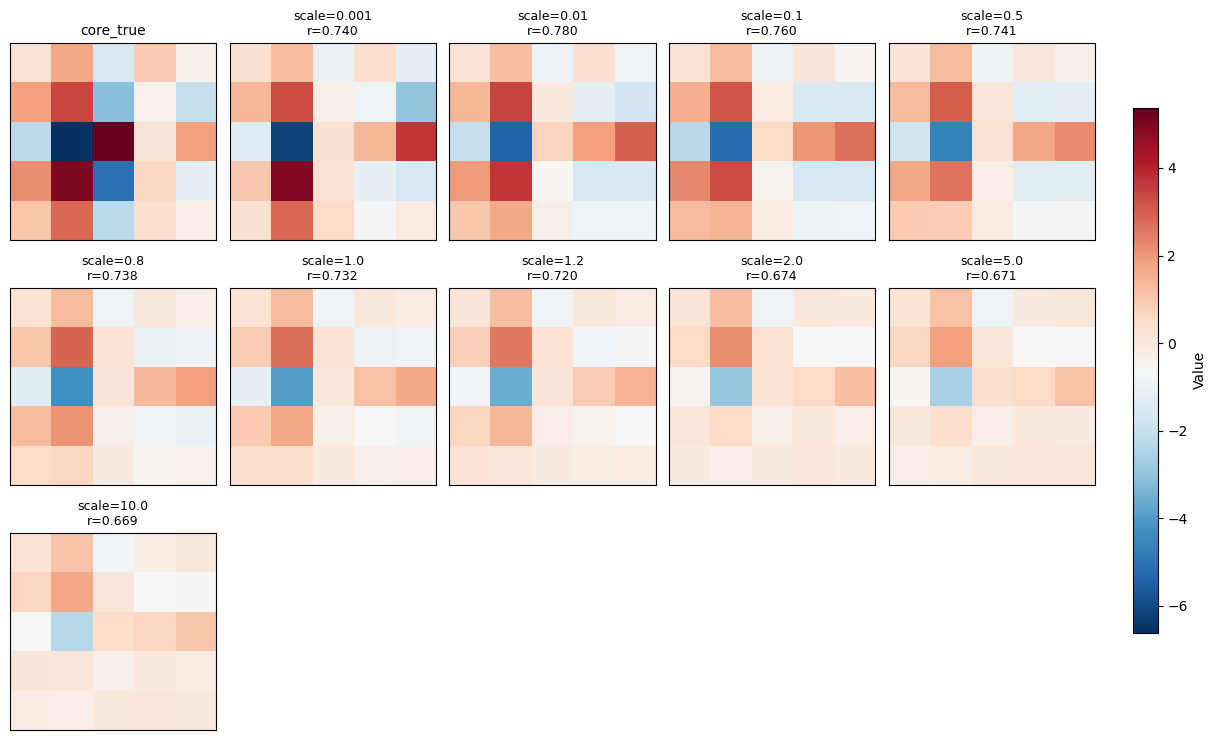

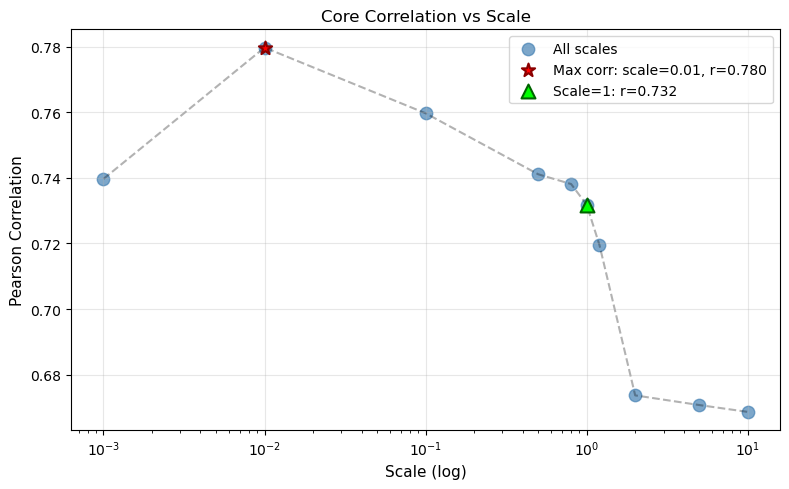

[np.float64(0.7397015774333917),
 np.float64(0.7797656327935948),
 np.float64(0.7597178796333481),
 np.float64(0.741108301258437),
 np.float64(0.7381316877305963),
 np.float64(0.73178352159118),
 np.float64(0.719516913780431),
 np.float64(0.673655258893507),
 np.float64(0.6707082581383484),
 np.float64(0.668617148776234)]

In [51]:
U_dyn = extract_dynamical_basis(X_obs, energy_threshold=0.98, min_k=5)
core_true = U_dyn.T @ A_true @ U_dyn

core_hat_list = []
# core_hat_list.append(U_dyn.T @ A_hat @ U_dyn)
for A_temp in A_hat_list:
    core_hat_temp  = U_dyn.T @ A_temp @ U_dyn
    core_hat_list.append(core_hat_temp)

plot_core_analysis(core_true, core_hat_list, scales, max_cols=5, figsize_per_subplot=(2.5, 2.5))

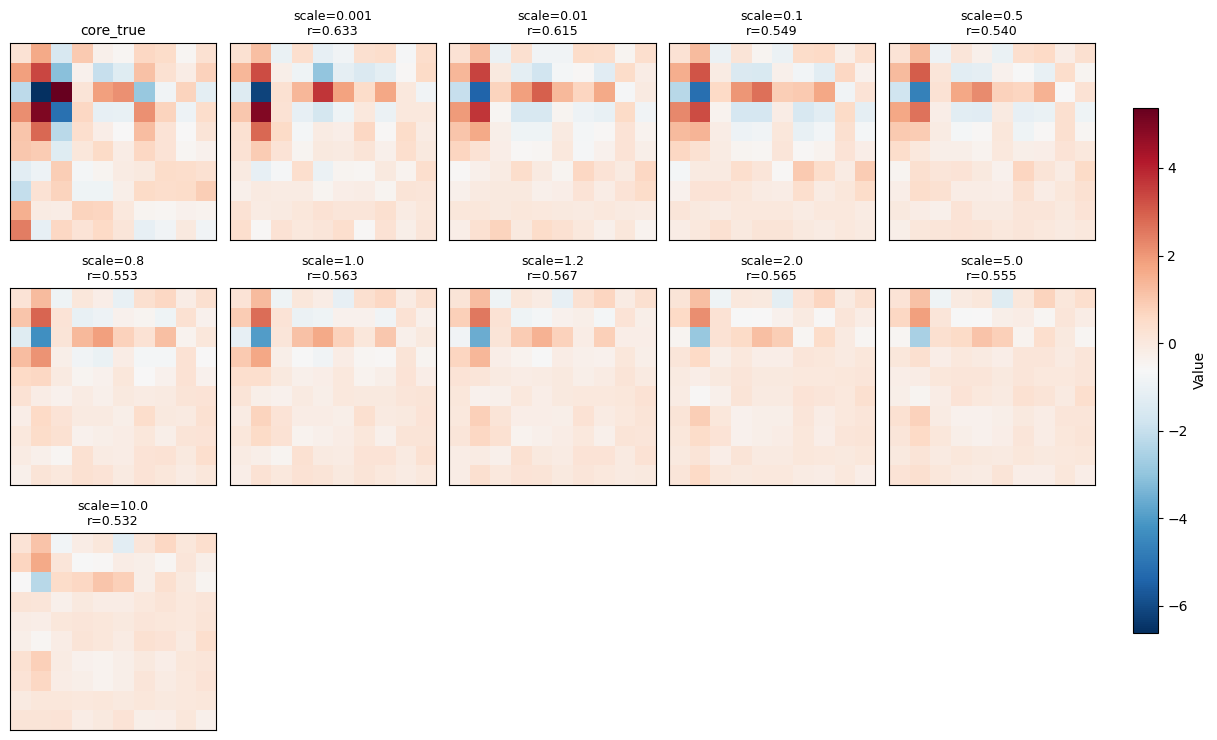

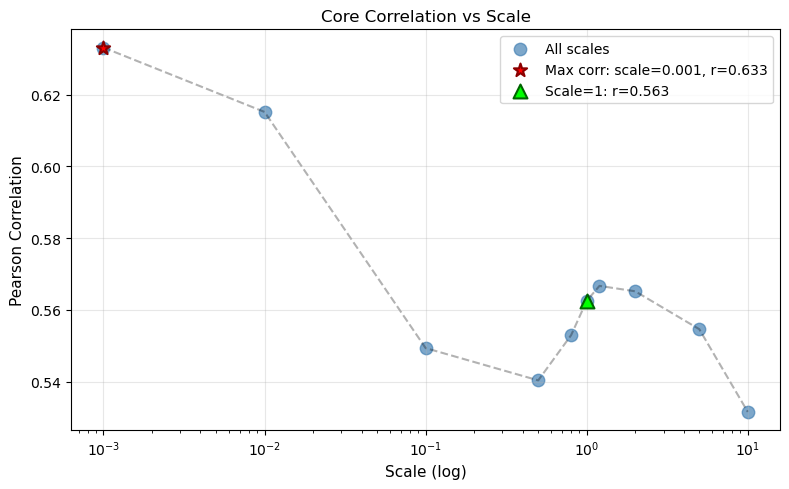

[np.float64(0.6331140714707841),
 np.float64(0.6151636872174949),
 np.float64(0.5493507761244955),
 np.float64(0.5403562499771793),
 np.float64(0.5529500266953373),
 np.float64(0.5625333840058708),
 np.float64(0.5666869638387374),
 np.float64(0.5651818109336262),
 np.float64(0.5546166249543047),
 np.float64(0.5315679864547129)]

In [40]:
U_dyn = extract_dynamical_basis(X_obs, energy_threshold=0.98, min_k=10)
core_true = U_dyn.T @ A_true @ U_dyn

core_hat_list = []
# core_hat_list.append(U_dyn.T @ A_hat @ U_dyn)
for A_temp in A_hat_list:
    core_hat_temp  = U_dyn.T @ A_temp @ U_dyn
    core_hat_list.append(core_hat_temp)

plot_core_analysis(core_true, core_hat_list, scales, max_cols=5, figsize_per_subplot=(2.5, 2.5))

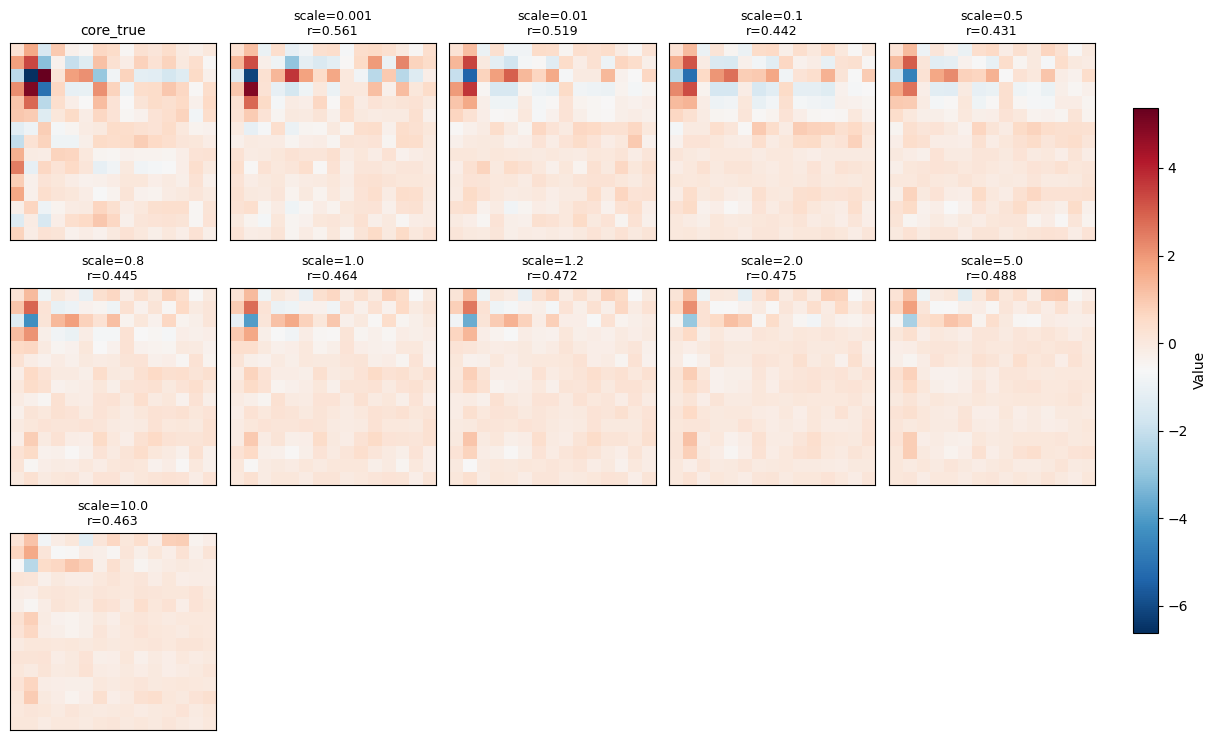

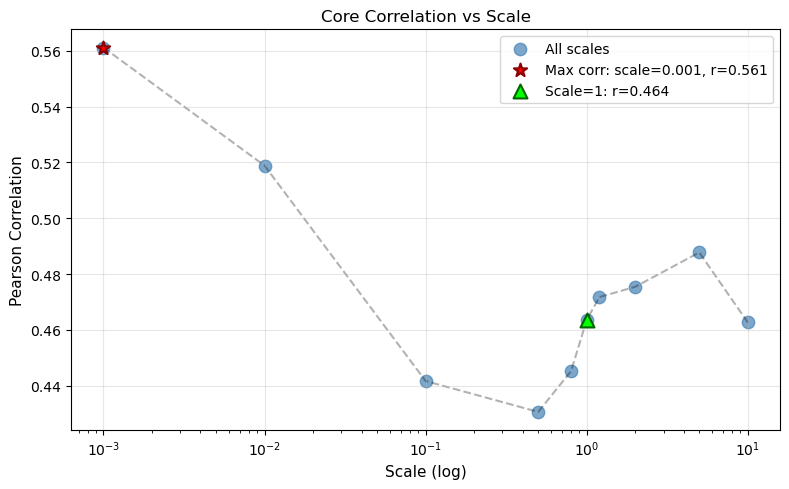

[np.float64(0.5612050569438424),
 np.float64(0.5188669216996152),
 np.float64(0.44161258694671945),
 np.float64(0.430549855372904),
 np.float64(0.44518967581517965),
 np.float64(0.4635743569140931),
 np.float64(0.4717371286533274),
 np.float64(0.47541506436296144),
 np.float64(0.48773639985194067),
 np.float64(0.4626414441797802)]

In [41]:
U_dyn = extract_dynamical_basis(X_obs, energy_threshold=0.98, min_k=15)
core_true = U_dyn.T @ A_true @ U_dyn

core_hat_list = []
# core_hat_list.append(U_dyn.T @ A_hat @ U_dyn)
for A_temp in A_hat_list:
    core_hat_temp  = U_dyn.T @ A_temp @ U_dyn
    core_hat_list.append(core_hat_temp)

plot_core_analysis(core_true, core_hat_list, scales, max_cols=5, figsize_per_subplot=(2.5, 2.5))

In [37]:
def compute_core_correlations(core_true, core_hat_list):
    """
    计算core_hat_list中每个矩阵与core_true的Pearson相关系数。
    """
    flat_true = core_true.flatten()
    correlations = []
    for core_hat in core_hat_list:
        corr = np.corrcoef(flat_true, core_hat.flatten())[0, 1]
        correlations.append(corr)
    return correlations


def plot_correlation_vs_scale_multi_k(correlations_dict, scales, figsize=(10, 6), 
                                       mark_max=True, mark_scale_one=True):
    """
    在同一张图中绘制不同k值下correlation与scale的关系。
    
    Parameters
    ----------
    correlations_dict : dict
        key: k值, value: 对应的correlations列表
        例如 {5: [0.9, 0.85, ...], 10: [0.95, 0.92, ...], ...}
    scales : list
        与correlations一一对应的scale值
    figsize : tuple
        图的大小
    mark_max : bool
        是否标记每条线的最大值点
    mark_scale_one : bool
        是否标记scale=1的点
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # 使用colormap生成不同颜色
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(correlations_dict)))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', 'h', '*']
    
    k_values = sorted(correlations_dict.keys())
    
    for i, k in enumerate(k_values):
        corrs = correlations_dict[k]
        color = colors[i]
        marker = markers[i % len(markers)]
        
        # 画折线
        ax.plot(scales, corrs, '-', color=color, marker=marker, markersize=6,
                label=f'k={k}', alpha=0.8, linewidth=1.5)
        
        # 标记最大值点
        if mark_max:
            max_idx = np.argmax(corrs)
            ax.scatter(scales[max_idx], corrs[max_idx], s=150, marker='*',
                      c=[color], edgecolors='black', linewidths=1, zorder=10)
        
        # 标记scale=1的点
        if mark_scale_one and 1.0 in scales:
            idx_one = scales.index(1.0)
            ax.scatter(scales[idx_one], corrs[idx_one], s=100, marker='D',
                      facecolors='none', edgecolors=color, linewidths=2, zorder=10)
    
    ax.set_xscale('log')
    ax.set_xlabel('Scale (log)', fontsize=12)
    ax.set_ylabel('Pearson Correlation', fontsize=12)
    ax.set_title('Core Correlation vs Scale (different k)', fontsize=13)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # 添加图例说明
    if mark_max or mark_scale_one:
        legend_text = []
        if mark_max:
            legend_text.append('★ = max correlation')
        if mark_scale_one:
            legend_text.append('◇ = scale=1')
        ax.annotate('\n'.join(legend_text), xy=(0.02, 0.02), xycoords='axes fraction',
                   fontsize=9, color='gray', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

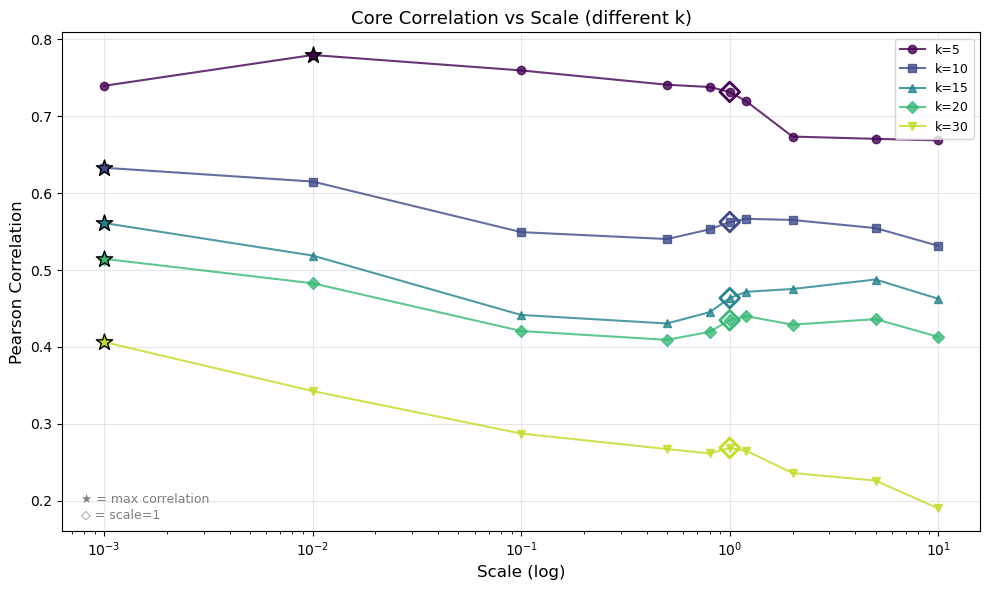

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Core Correlation vs Scale (different k)'}, xlabel='Scale (log)', ylabel='Pearson Correlation'>)

In [38]:
k_list = [5, 10, 15, 20, 30]
correlations_dict = {}

for k in k_list:
    U_dyn = extract_dynamical_basis(X_obs, energy_threshold=0.98, min_k=k)
    core_true = U_dyn.T @ A_true @ U_dyn
    core_hat_list = [U_dyn.T @ A_temp @ U_dyn for A_temp in A_hat_list]
    
    # 计算并存储
    correlations_dict[k] = compute_core_correlations(core_true, core_hat_list)

# 绘制多折线图
plot_correlation_vs_scale_multi_k(correlations_dict, scales)

In [95]:
# analyze_core_evolution_scales(core_true, core_hat_list, scales, max_cols=4)

Chosen core_hat scale: 1.0
--- Core Structure Analysis ---
Global Correlation: 0.2686
Top 20% Interaction Correlation: 0.4655
Symmetric Part (Flow) Correlation: 0.2950
Skew Part (Cycle) Correlation:     0.2376
------------------------------


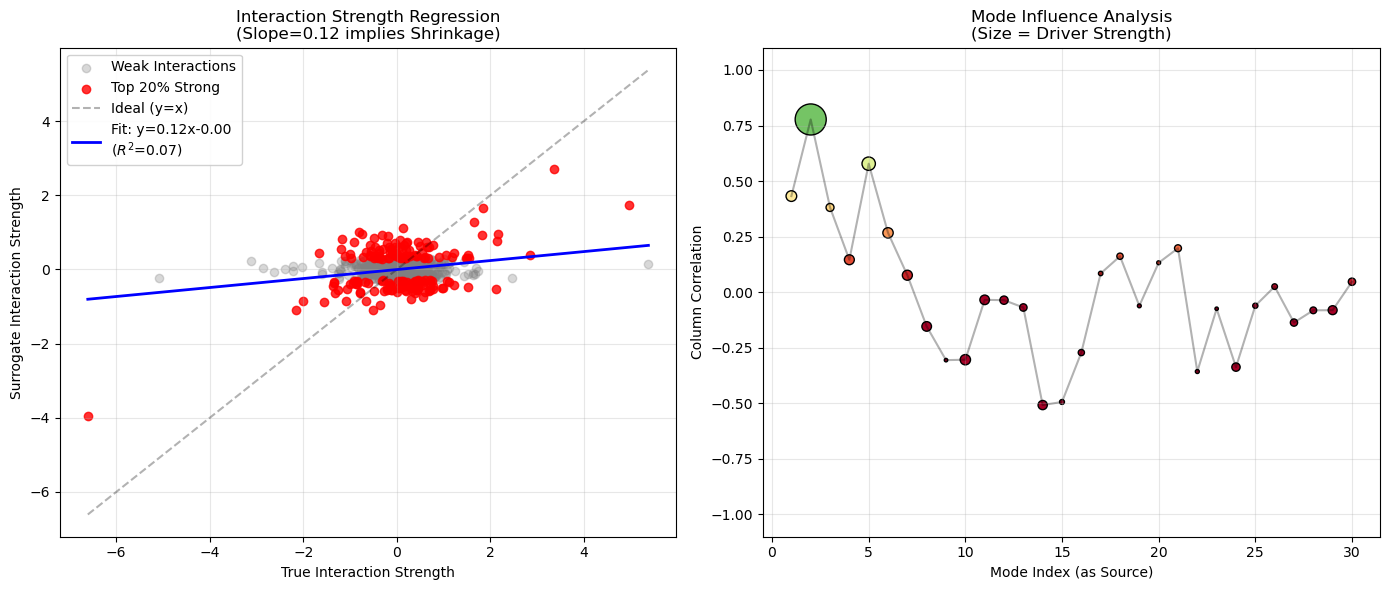

In [39]:
chosen_core_hat_index = 5
print(f'Chosen core_hat scale: {scales[chosen_core_hat_index]}')
core_hat = copy.deepcopy(core_hat_list[5])

top_percentile=20
flat_t = core_true.flatten()
flat_h = core_hat.flatten()


corr_global = np.corrcoef(flat_t, flat_h)[0, 1]
threshold = np.percentile(np.abs(core_hat), 100 - top_percentile)
is_sig = np.abs(flat_h) >= threshold

if np.sum(is_sig) > 1:
    corr_sparse = np.corrcoef(flat_t[is_sig], flat_h[is_sig])[0, 1]
else:
    corr_sparse = 0.0
    

def get_sym_skew(M):
    return (M + M.T)/2, (M - M.T)/2

t_sym, t_skew = get_sym_skew(core_true)
h_sym, h_skew = get_sym_skew(core_hat)

corr_sym = np.corrcoef(t_sym.flatten(), h_sym.flatten())[0, 1]
corr_skew = np.corrcoef(t_skew.flatten(), h_skew.flatten())[0, 1]

print(f"--- Core Structure Analysis ---")
print(f"Global Correlation: {corr_global:.4f}")
print(f"Top {top_percentile}% Interaction Correlation: {corr_sparse:.4f}")
# if corr_sparse > corr_global + 0.1:
#     print(">> The dynamic is driven by some strong interactions")
print(f"Symmetric Part (Flow) Correlation: {corr_sym:.4f}")
print(f"Skew Part (Cycle) Correlation:     {corr_skew:.4f}")
print("-" * 30)

slope, intercept, r_value, p_value, std_err = stats.linregress(flat_t, flat_h)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax = axes[0]
ax.scatter(flat_t[~is_sig], flat_h[~is_sig], c='gray', alpha=0.3, label='Weak Interactions')
ax.scatter(flat_t[is_sig], flat_h[is_sig], c='red', alpha=0.8, label=f'Top {top_percentile}% Strong')

lims = [np.min([flat_t, flat_h]), np.max([flat_t, flat_h])]
ax.plot(lims, lims, 'k--', alpha=0.3, label='Ideal (y=x)')

x_fit = np.linspace(min(flat_t), max(flat_t), 100)
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, 'b-', linewidth=2, label=f'Fit: y={slope:.2f}x{intercept:+.2f}\n($R^2$={r_value**2:.2f})')

ax.set_xlabel("True Interaction Strength")
ax.set_ylabel("Surrogate Interaction Strength")
ax.set_title(f"Interaction Strength Regression\n(Slope={slope:.2f} implies Shrinkage)")
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)


ax = axes[1]
k = core_true.shape[0]
col_corrs = []
col_energies = []

for j in range(k):
    c_t = core_true[:, j]
    c_h = core_hat[:, j]
    cc = np.corrcoef(c_t, c_h)[0, 1]
    col_corrs.append(cc)
    col_energies.append(np.sum(c_h**2))
    
ax.scatter(range(1, k+1), col_corrs, s=np.array(col_energies)/np.max(col_energies)*500, 
                c=col_corrs, cmap='RdYlGn', vmin=0, vmax=1, edgecolors='k')
ax.plot(range(1, k+1), col_corrs, 'k-', alpha=0.3)

ax.set_xlabel("Mode Index (as Source)")
ax.set_ylabel("Column Correlation")
ax.set_title("Mode Influence Analysis\n(Size = Driver Strength)")
ax.set_ylim(-1.1, 1.1)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [98]:
col_energies

[np.float64(3.170081968972623),
 np.float64(27.72977213022098),
 np.float64(0.8976664841747806),
 np.float64(2.669233459078203),
 np.float64(4.218311246833759)]

<font color = black size = 5>Compare dynamics in generated real space, A_generated from \[Core_true, Core_hat\]</font>

In [43]:
def generate_networks_from_core(Core, U_dyn, N, noise_scale=10.0):
    """
    反向投影实验：从动力学核心 (Core) 生成全新的网络矩阵。
    
    参数:
    -------
    Core : (k, k) 动力学核心矩阵 (可以是 core_true 或 core_hat)
    U_dyn : (N, k) 动力学子空间基底 (必须是正交归一的)
    N : int 节点数
    noise_scale : float 隐形噪声的强度
    
    返回:
    -------
    generated_nets : dict {'Pure': A_pure, 'Ghost': A_ghost}
    """
    
    # 1. 生成极简骨架 (The Pure Skeleton)
    # 公式: A = U * C * U.T
    # 这是一个 Rank-k 的矩阵
    A_pure = U_dyn @ Core @ U_dyn.T
    
    # 2. 生成隐形噪声 (The Null-Space Ghost)
    # 我们需要一个矩阵 G，使得 U.T @ G @ U = 0
    # 方法：生成随机矩阵 R，然后减去它在 U 上的投影
    # G = R - U @ (U.T @ R @ U) @ U.T
    # 这样 U.T @ G @ U 就等于 (U.T R U) - (U.T U)(U.T R U)(U.T U) = C_R - I*C_R*I = 0
    
    R = np.random.randn(N, N) * noise_scale
    projection_of_R = U_dyn.T @ R @ U_dyn
    R_component_in_U = U_dyn @ projection_of_R @ U_dyn.T
    
    # G 完全位于 U 的正交补空间中 (Null Space w.r.t U)
    G = R - R_component_in_U
    
    # 构造伪装网络
    A_ghost = A_pure + G
    
    # 3. 物理约束处理 (可选)
    # 真实网络通常非负，或者是某种特定范围。
    # 这里我们做简单的绝对值处理，或者保持原样看数学性质
    # 为了严谨的动力学测试，我们先保持原样，但在模拟时要注意模型是否接受负值
    # 如果是 LV 模型，A通常代表相互作用，可以为负（竞争）或正（互利）。
    
    return {
        'Pure': A_pure,
        'Ghost': A_ghost,
        'Noise_G': G
    }

In [44]:
def enforce_structure_constraints(A_generated, A_reference):
    """
    将生成的稠密网络 (A_pure) 强制整形，使其规模和稀疏度与参考网络 (A_true) 一致。
    
    步骤:
    1. 计算参考网络的稀疏度 (Sparsity)。
    2. 对 A_generated 进行硬阈值截断 (Hard Thresholding)，保留相同数量的强边。
    3. (可选) 最小二乘重缩放 (Rescaling)，确保投影能量一致。
    """
    N = A_reference.shape[0]
    
    # 1. 分析参考网络结构
    # 计算非零边数量 (假设绝对值 > 1e-5 算一条边)
    n_edges_true = np.sum(np.abs(A_reference) > 1e-5)
    sparsity = n_edges_true / (N * N)
    
    print(f"[Constraint] Target Edges: {n_edges_true} (Sparsity: {sparsity:.1%})")
    
    # 2. 对生成的网络进行截断
    # 将矩阵展平，找到第 k 大的值作为阈值
    flat_gen = np.abs(A_generated).flatten()
    # 排序
    flat_gen_sorted = np.sort(flat_gen)
    # 阈值索引 (倒数第 n_edges_true 个)
    threshold_idx = max(0, len(flat_gen) - n_edges_true)
    threshold = flat_gen_sorted[threshold_idx]
    
    # 执行截断
    mask = np.abs(A_generated) >= threshold
    A_structured = np.zeros_like(A_generated)
    A_structured[mask] = A_generated[mask]
    
    # 3. 能量重缩放 (Rescaling)
    # 截断后能量损失了，为了保证动力学依然强劲，需要把剩下的边放大
    # 目标：让 A_structured 在 U 空间的投影尽量接近 A_generated 的投影
    # 简单估计：匹配 Frobenius 范数 (总能量)
    norm_gen = np.linalg.norm(A_generated)
    norm_struct = np.linalg.norm(A_structured)
    
    if norm_struct > 1e-9:
        scale_factor = norm_gen / norm_struct
        A_structured *= scale_factor
        print(f"[Constraint] Energy lost due to truncation. Rescaling by {scale_factor:.2f}x")
    
    return A_structured

In [52]:
# 1. 成原始的 Pure 网络 (稠密)
core_hat_best = core_hat_list[5]
gen_nets = generate_networks_from_core(core_hat_best, U_dyn, N, noise_scale=0)
A_pure = gen_nets['Pure']

# 2. 施加结构约束 (稀疏化)
A_restored = enforce_structure_constraints(A_pure, A_true)

[Constraint] Target Edges: 2494 (Sparsity: 7.4%)
[Constraint] Energy lost due to truncation. Rescaling by 1.22x


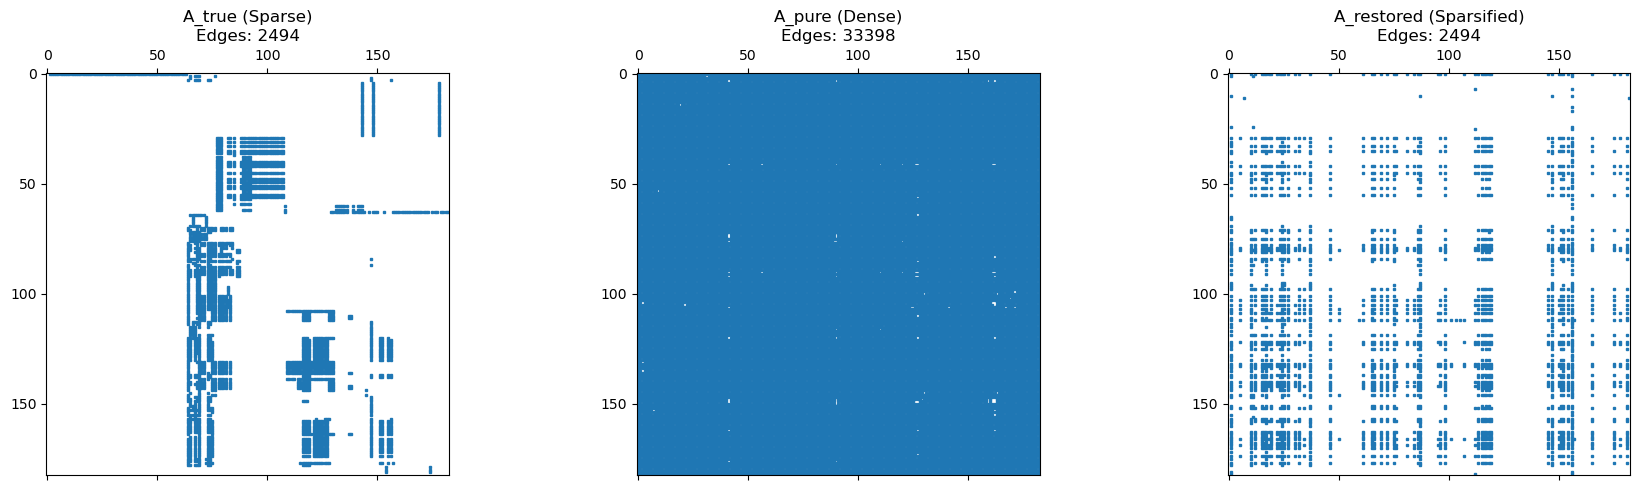

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# A_true
axes[0].spy(np.abs(A_true) > 1e-5, markersize=2)
axes[0].set_title(f"A_true (Sparse)\nEdges: {np.sum(np.abs(A_true)>1e-5)}")

# A_pure (Dense)
# spy 图会是全黑的
axes[1].spy(np.abs(A_pure) > 1e-5, markersize=2)
axes[1].set_title(f"A_pure (Dense)\nEdges: {np.sum(np.abs(A_pure)>1e-5)}")

# A_restored (Sparse again)
axes[2].spy(np.abs(A_restored) > 1e-5, markersize=2)
axes[2].set_title(f"A_restored (Sparsified)\nEdges: {np.sum(np.abs(A_restored)>1e-5)}")

plt.tight_layout()
plt.show()

In [59]:
def compare_prediction_errors_v6(X_true, pred_dict, t_split, dt=0.1, title=None):
    """
    升级版误差对比图 (v6 - Scale 适配版)：
    1. 智能解析 'rho=...' 或 'Scale ...x' 中的数值用于排序和着色。
    2. 所有线条统一从色谱取色 (深蓝 -> 浅蓝/红)。
    3. Auto/Base 曲线不加粗，仅使用【点划线】区分。
    """
    
    # 1. 准备真值
    X_ref = X_true[t_split:]
    if len(X_ref) == 0: return
    T_future = len(X_ref)
    time_horizon = np.arange(T_future) * dt
    
    # 2. 解析并排序数据
    sorted_items = []
    all_values = []
    
    for label, X_pred in pred_dict.items():
        # 核心升级：尝试多种正则模式提取数值
        # 模式 A: Scale 0.1x
        match_scale = re.search(r"Scale\s*([\d\.eE\-\+]+)x?", label, re.IGNORECASE)
        # 模式 B: rho=0.01
        match_rho = re.search(r"rho=([\d\.eE\-\+]+)", label, re.IGNORECASE)
        
        if match_scale:
            val = float(match_scale.group(1))
            val_type = 'Scale'
        elif match_rho:
            val = float(match_rho.group(1))
            val_type = 'Rho'
        else:
            val = 0.0 # 没找到数值，默认排最前
            val_type = 'Unknown'
            
        # 判定是否为 Auto/Base (包含 'auto' 或者 Scale=1.0)
        # 如果是 Scale 实验，通常 1.0 就是基准
        is_auto = "auto" in label.lower() or (val_type == 'Scale' and abs(val - 1.0) < 1e-6)
        
        sorted_items.append({
            'val': val,
            'label': label,
            'data': X_pred,
            'is_auto': is_auto
        })
        
        if val > 0:
            all_values.append(val)
    
    # 按数值从小到大排序
    sorted_items.sort(key=lambda x: x['val'])
    
    # 3. 颜色映射
    if len(all_values) > 0:
        min_v, max_v = min(all_values), max(all_values)
        # 使用 jet 色谱 (蓝->红)
        norm = mcolors.LogNorm(vmin=min_v, vmax=max_v)
        cmap = plt.get_cmap('jet')
    else:
        norm = None
        cmap = None

    # 4. 绘图
    fig, ax = plt.subplots(figsize=(12, 7))
    
    stats_report = []
    
    print("-" * 65)
    print(f"{'Label':<40} | {'MAE':<10} | {'Value':<10}")
    print("-" * 65)
    
    for item in sorted_items:
        X_pred = item['data']
        label = item['label']
        is_auto = item['is_auto']
        val = item['val']
        
        # 数据对齐
        X_p = X_pred[t_split:]
        if len(X_p) < T_future:
            curr_X_ref = X_ref[:len(X_p)]
            curr_time = time_horizon[:len(X_p)]
        else:
            curr_X_ref = X_ref
            X_p = X_p[:T_future]
            curr_time = time_horizon
            
        # 计算误差
        abs_diff = np.abs(curr_X_ref - X_p)
        epsilon_t = np.mean(abs_diff, axis=1)
        epsilon_bar = np.mean(epsilon_t)
        
        stats_report.append((label, epsilon_bar))
        
        # --- 样式逻辑 ---
        # 1. 颜色: 基于数值
        if cmap and norm and val > 0:
            c = cmap(norm(val))
        else:
            c = 'gray'
            
        # 2. 线型: Auto 用点划线，其他实线
        if is_auto:
            ls = '-.'       # 点划线
            lw = 2.0        # 略微粗一点点 (2.0 vs 1.5) 以保证点划线清晰，但不突兀
            zorder = 100    # 依然置顶
            plot_label = f"★ {label}" # 加星号
            style_desc = "Dash-dot (Auto)"
        else:
            ls = '-'        # 实线
            lw = 1.5
            zorder = 10
            plot_label = label
            style_desc = "Solid"
            
        print(f"{label:<40} | {epsilon_bar:.6f}   | {style_desc}")
            
        ax.plot(curr_time, epsilon_t, 
                color=c, linewidth=lw, linestyle=ls, alpha=0.8, zorder=zorder,
                label=f"{plot_label} (MAE={epsilon_bar:.4f})")

    # 5. 装饰
    ax.set_xlabel(r"Prediction Time Horizon $\tilde{t}$", fontsize=12)
    ax.set_ylabel(r"MAE $\epsilon(\tilde{t})$", fontsize=12)
    
    title_str = title if title else "Sensitivity Analysis: Prediction Error vs. Parameter Scale"
    ax.set_title(title_str, fontsize=14)
    
    # 图例放在外侧
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=9)
    
    ax.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # 最佳模型
    if stats_report:
        best_model = sorted(stats_report, key=lambda x: x[1])[0]
        print("-" * 65)
        print(f"Lowest Error Achieved by: {best_model[0]}")

Simulating Restored Network...


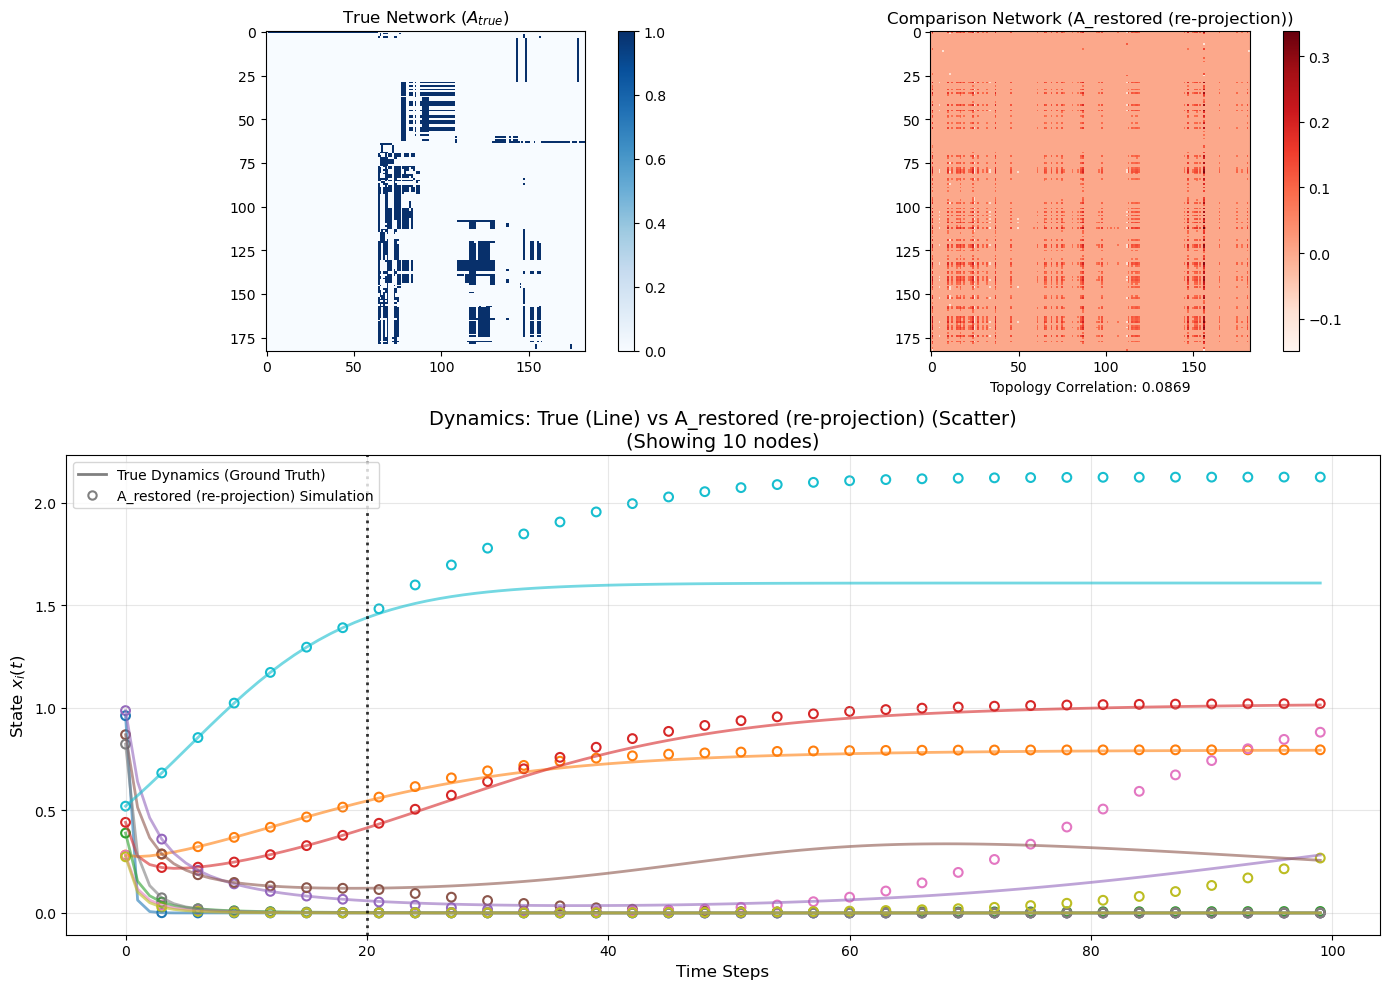

In [67]:
print("Simulating Restored Network...")
X_restored = model.simulate(A_restored, T_steps=len(X_obs)-T_train_steps, init_state=X_obs[T_train_steps])
X_restored_full = np.vstack([X_train, X_restored])
# X_pure = model.simulate(A_pure, T_steps=len(X_obs)-T_train_steps, init_state=X_obs[T_train_steps])
# X_pure_full = np.vstack([X_train, X_pure])


plot_network_and_dynamics_comparison(
    A_true=A_true, 
    A_compare=A_restored, 
    X_true=X_obs, 
    X_compare=X_restored_full, 
    T_train_steps=T_train_steps,
    num_plot_nodes=10, 
    name_compare=f"A_restored (re-projection)"
)

# # 画图
# compare_prediction_errors_v6(X_obs, {
#     "Original A_true": X_obs[T_train_steps:],
#     "A_pure (Dense)": X_pure,       # 之前算的
#     "A_restored (Sparse)": X_restored # 现在算的
# }, T_train_steps)

Simulating Restored Network...


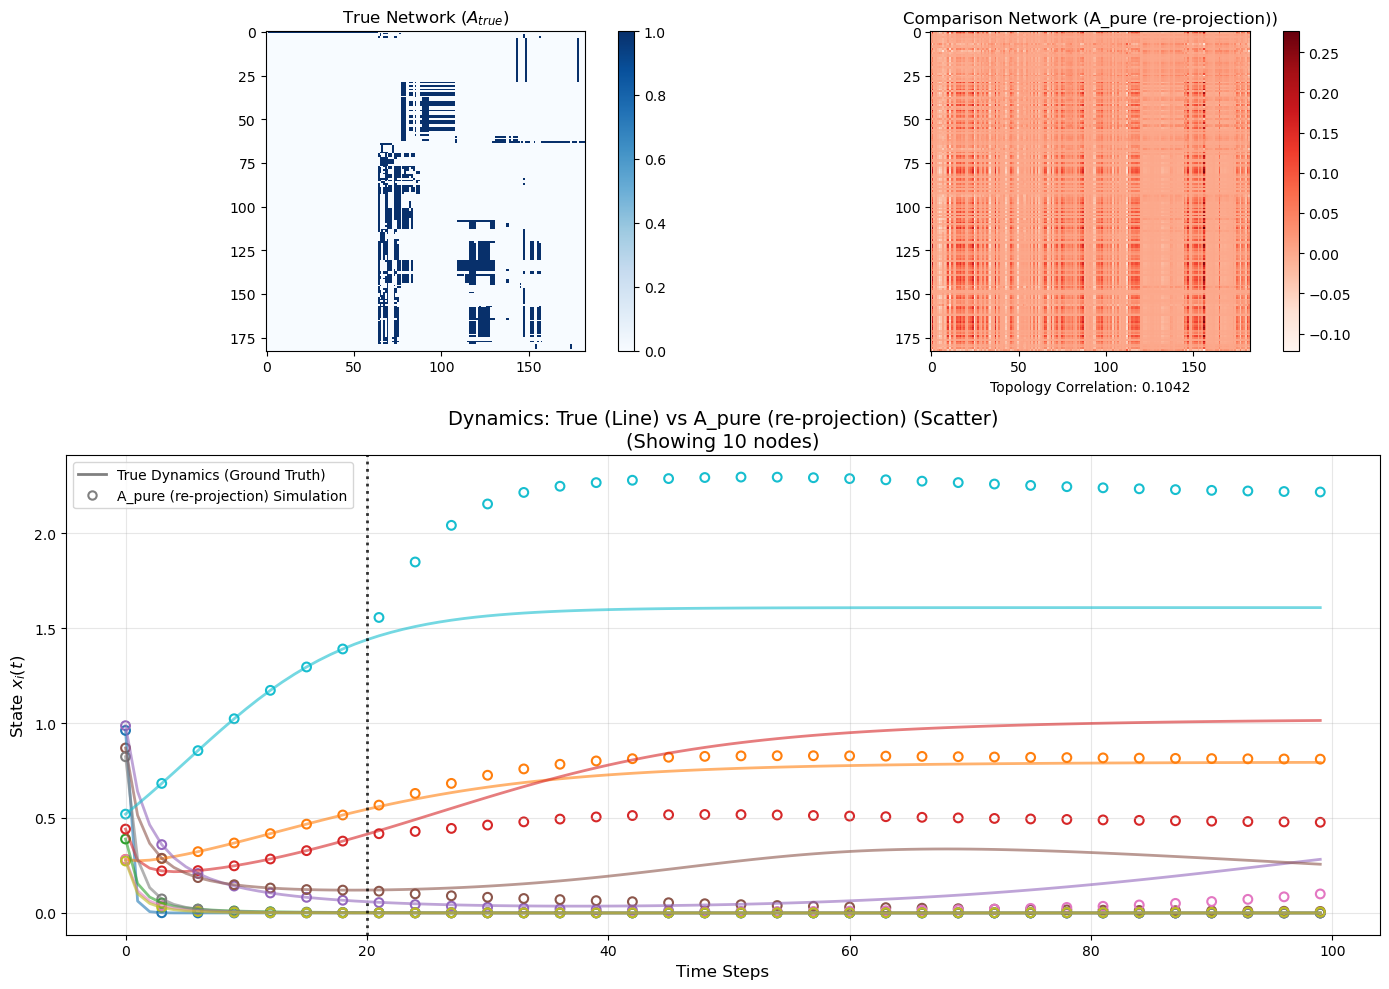

In [68]:
print("Simulating Restored Network...")
# X_restored = model.simulate(A_restored, T_steps=len(X_obs)-T_train_steps, init_state=X_obs[T_train_steps])
# X_restored_full = np.vstack([X_train, X_restored])
X_pure = model.simulate(A_pure, T_steps=len(X_obs)-T_train_steps, init_state=X_obs[T_train_steps])
X_pure_full = np.vstack([X_train, X_pure])


plot_network_and_dynamics_comparison(
    A_true=A_true, 
    A_compare=A_pure, 
    X_true=X_obs, 
    X_compare=X_pure_full, 
    T_train_steps=T_train_steps,
    num_plot_nodes=10, 
    name_compare=f"A_pure (re-projection)"
)

# # 画图
# compare_prediction_errors_v6(X_obs, {
#     "Original A_true": X_obs[T_train_steps:],
#     "A_pure (Dense)": X_pure,       # 之前算的
#     "A_restored (Sparse)": X_restored # 现在算的
# }, T_train_steps)

In [69]:
def enforce_structure_mixing(A_generated, A_ref1, A_ref2, w1=1.0, w2=0.0):
    """
    结构混合整形函数：将生成的稠密网络 (A_pure) 按照两个参考网络的加权结构进行稀疏化。
    
    参数:
    -------
    A_generated : np.array
        反向投影生成的稠密网络 (待整形)。
    A_ref1 : np.array (通常是 A_true)
        参考网络 1。
    A_ref2 : np.array (通常是 A_hat)
        参考网络 2。
    w1, w2 : float
        混合权重。
        - (1.0, 0.0) -> 完全模仿 Ref1 的稀疏结构。
        - (0.0, 1.0) -> 完全模仿 Ref2 的稀疏结构。
        - (0.5, 0.5) -> 取两者的并集/平均重要性。
        - (1.2, -0.2)-> 强化 Ref1 特征，减弱 Ref2 特征 (差分放大)。
        
    返回:
    -------
    A_structured : np.array
        整形后的网络。
    """
    
    # 1. 计算目标稀疏度 (Target Sparsity)
    # 逻辑：我们希望结果的边数大约等于 Ref1 和 Ref2 边数的加权平均
    # 或者简单起见，以主导权重方 (w绝对值较大者) 的边数为准，这里我们采用"加权边数"
    n_edges_1 = np.sum(np.abs(A_ref1) > 1e-10)
    n_edges_2 = np.sum(np.abs(A_ref2) > 1e-10)
    
    # 归一化权重用于计算目标边数 (避免负数导致边数为负)
    total_w = abs(w1) + abs(w2) + 1e-10
    target_edge_count = int((abs(w1) * n_edges_1 + abs(w2) * n_edges_2) / total_w)
    
    # 2. 构建"重要性地图" (Importance Map)
    # 我们不直接混合 A 的值，而是混合 A 的绝对值(结构强度)
    # 这决定了"保留哪些位置"
    Importance = w1 * np.abs(A_ref1) + w2 * np.abs(A_ref2)
    
    # *关键处理*：如果 w 为负，可能导致 Importance 出现负值。
    # 负的重要性意味着"我们要刻意避开这些边"。
    # 但为了排序方便，我们关注 Importance 值较大的位置。
    
    # 3. 确定掩码 (Mask)
    # 策略：选择 Importance 矩阵中数值最大的前 target_edge_count 个位置
    flat_imp = Importance.flatten()
    # argsort 从小到大排，取最后 k 个即为最大的 k 个
    # 注意：如果 Importance 有负值，负得越厉害排越前，会被丢弃，符合逻辑
    indices = np.argsort(flat_imp) 
    top_k_indices = indices[-target_edge_count:]
    
    mask = np.zeros_like(A_generated, dtype=bool)
    # 将一维索引转回二维
    rows, cols = np.unravel_index(top_k_indices, A_generated.shape)
    mask[rows, cols] = True
    
    # 4. 应用掩码并重缩放 (Apply & Rescale)
    A_structured = np.zeros_like(A_generated)
    
    # 只把 A_generated (动力学核心生成的值) 填入选定的位置
    # 这意味着：值来自于 Core，位置来自于 Ref1/Ref2 的混合
    A_structured[mask] = A_generated[mask]
    
    # 能量补偿 (保持动力学强度)
    norm_gen = np.linalg.norm(A_generated)
    norm_struct = np.linalg.norm(A_structured)
    
    if norm_struct > 1e-9:
        scale_factor = norm_gen / norm_struct
        A_structured *= scale_factor
        # print(f"Rescaling factor: {scale_factor:.2f}")
        
    return A_structured

In [80]:
def analyze_multi_mode_drivers(metrics, num_modes=5, top_k=15):
    """
    分析前 n 个模式 (Modes) 的关键驱动节点及其拓扑性质。
    
    参数:
    metrics : dict, 包含 'Vt', 'S', 'topology' 的数据包
    num_modes : int, 分析前多少个模式 (默认 5)
    top_k : int, 每个模式展示前多少个节点
    
    返回:
    df_all : pd.DataFrame, 包含所有模式关键节点的完整数据表
    """
    # 基础数据提取
    Vt = metrics['Vt']
    S = metrics['S']
    degrees = metrics['topology']['in_degrees']
    network_name = metrics['name']
    
    # 限制模式数量不超过实际秩
    num_modes = min(num_modes, len(S))
    
    # 数据容器
    all_data = []
    
    # ==========================================
    # 1. 循环提取每个 Mode 的数据
    # ==========================================
    for m in range(num_modes):
        v_vec = Vt[m, :]
        sigma = S[m]
        
        # 排序：按绝对值大小寻找贡献最大的节点
        sorted_indices = np.argsort(np.abs(v_vec))[::-1]
        top_indices = sorted_indices[:top_k]
        
        mode_energy = sigma**2
        vec_energy = np.sum(v_vec**2) # 应该是 1.0
        
        for rank, idx in enumerate(top_indices):
            val = v_vec[idx]
            deg = degrees[idx]
            
            # 计算度百分位
            pct = (np.sum(degrees < deg) / len(degrees)) * 100
            
            all_data.append({
                "Mode": f"Mode {m+1}",
                "Sigma": sigma,
                "Node ID": idx,
                "Coefficient": val,
                "Abs Coeff": np.abs(val),
                "Sign": "Positive" if val > 0 else "Negative",
                "Degree": int(deg),
                "Degree %Tile": pct,
                "Rank in Mode": rank + 1
            })
            
    df_all = pd.DataFrame(all_data)
    
    # ==========================================
    # 可视化 A: 每个 Mode 的驱动节点 (Subplots)
    # ==========================================
    # 动态调整画布高度
    fig, axes = plt.subplots(num_modes, 1, figsize=(12, 3 * num_modes), sharex=False)
    if num_modes == 1: axes = [axes]
    
    fig.suptitle(f"Top {top_k} Drivers for First {num_modes} Modes\nNetwork: {network_name}", y=1.005, fontsize=16)
    
    for m, ax in enumerate(axes):
        mode_label = f"Mode {m+1}"
        subset = df_all[df_all["Mode"] == mode_label]
        sigma_val = subset["Sigma"].iloc[0]
        
        # 绘制条形图
        sns.barplot(x="Node ID", y="Coefficient", hue="Sign", data=subset,
                    palette={"Positive": "crimson", "Negative": "dodgerblue"},
                    dodge=False, ax=ax, order=subset["Node ID"]) # 保持排序顺序
        
        # 装饰
        ax.set_title(f"{mode_label} (Singular Value $\sigma_{m+1} = {sigma_val:.2f}$)", fontsize=13, pad=5)
        ax.set_xlabel("")
        ax.set_ylabel("Driver Score ($v_{ki}$)")
        ax.axhline(0, color='black', lw=0.8)
        ax.grid(axis='y', linestyle='--', alpha=0.3)
        ax.legend(loc='upper right', fontsize=8, title=None)
        
        # 在柱子上标注度数 (Degree)
        # 这能让你直接看到：这个柱子虽然高，但它的度数是多少？
        for p, deg in zip(ax.patches, subset["Degree"]):
            height = p.get_height()
            # 自动调整标注位置 (正数在上方，负数在下方)
            offset = 5 if height > 0 else -15
            ax.annotate(f"k={deg}", 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha = 'center', va = 'center', 
                        xytext = (0, offset), 
                        textcoords = 'offset points',
                        fontsize=9, color='black', fontweight='bold')

    plt.tight_layout()
    plt.show()
    
    # ==========================================
    # 可视化 B: 驱动节点在度分布中的位置 (Boxplot)
    # ==========================================
    # 这个图回答：Mode 1 的驱动者是 Hub 吗？Mode 2 呢？
    plt.figure(figsize=(10, 6))
    
    # 1. 画全网度分布背景 (灰色小提琴或箱线图)
    # 为了对比，我们在背景里画一条全网平均度的线
    avg_deg = np.mean(degrees)
    plt.axhline(avg_deg, color='gray', linestyle='--', label=f'Network Avg Degree ({avg_deg:.1f})')
    
    # 2. 画不同 Mode 的驱动节点的度分布
    sns.stripplot(x="Mode", y="Degree", data=df_all, 
                  jitter=True, size=8, hue="Sign", 
                  palette={"Positive": "crimson", "Negative": "dodgerblue"}, alpha=0.8)
    
    # 叠加一个箱线图看统计趋势
    sns.boxplot(x="Mode", y="Degree", data=df_all, color='white', width=0.3, showfliers=False, boxprops={'alpha': 0.3})

    plt.yscale('log') # 度分布通常跨度大，用对数轴更清晰
    plt.title("Are Drivers Hubs? Degree Distribution of Top Drivers per Mode", fontsize=14)
    plt.ylabel("Node Degree (Log Scale)")
    plt.xlabel("Interaction Mode")
    plt.grid(axis='y', which='both', linestyle=':', alpha=0.5)
    plt.legend(title="Interaction Sign")
    
    plt.tight_layout()
    plt.show()
    
    return df_all

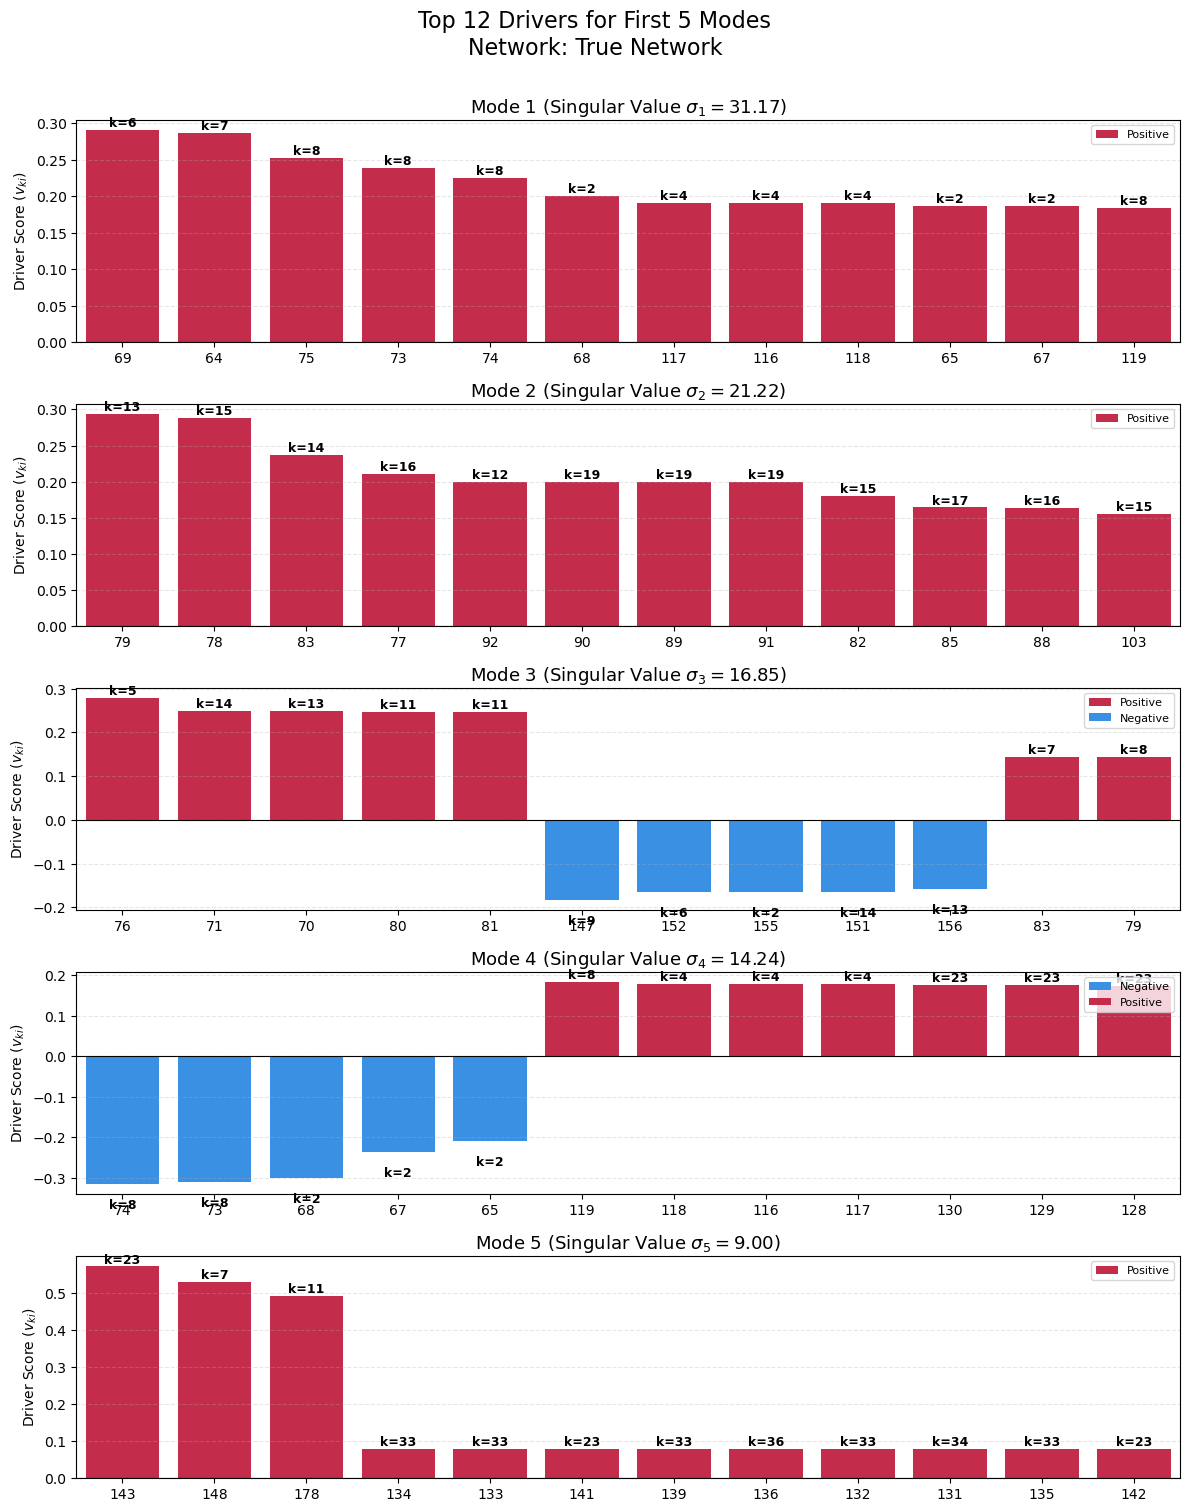

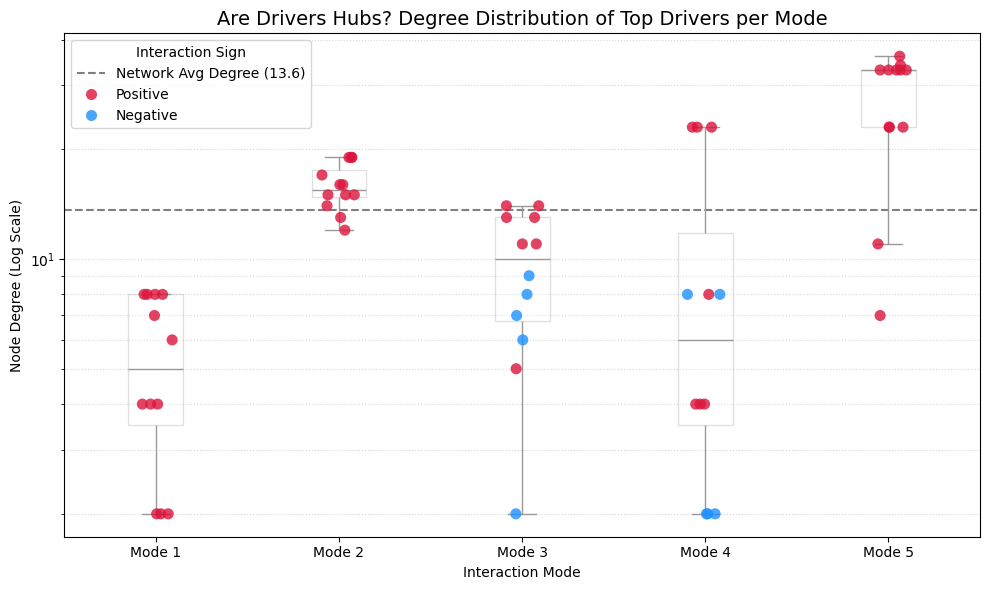

In [81]:
df_modes_true = analyze_multi_mode_drivers(all_metrics[0], num_modes=5, top_k=12)

In [82]:
df_modes_true

Mode      Sigma  Node ID  Coefficient  Abs Coeff      Sign  Degree  \
0   Mode 1  31.170636       69     0.290535   0.290535  Positive       6   
1   Mode 1  31.170636       64     0.287204   0.287204  Positive       7   
2   Mode 1  31.170636       75     0.252613   0.252613  Positive       8   
3   Mode 1  31.170636       73     0.238468   0.238468  Positive       8   
4   Mode 1  31.170636       74     0.224822   0.224822  Positive       8   
5   Mode 1  31.170636       68     0.200179   0.200179  Positive       2   
6   Mode 1  31.170636      117     0.191007   0.191007  Positive       4   
7   Mode 1  31.170636      116     0.191007   0.191007  Positive       4   
8   Mode 1  31.170636      118     0.191007   0.191007  Positive       4   
9   Mode 1  31.170636       65     0.186953   0.186953  Positive       2   
10  Mode 1  31.170636       67     0.186285   0.186285  Positive       2   
11  Mode 1  31.170636      119     0.184392   0.184392  Positive       8   
12  Mode 2  21.222028       79     0.293338   0.293338  Positive      13   
13  Mode 2  21.222028       78     0.288034   0.288034  Positive      15   
14  Mode 2  21.222028       83     0.236905   0.236905  Positive      14   
15  Mode 2  21.222028       77     0.209934   0.209934  Positive      16   
16  Mode 2  21.222028       92     0.199248   0.199248  Positive      12   
17  Mode 2  21.222028       90     0.199248   0.199248  Positive      19   
18  Mode 2  21.222028       89     0.199248   0.199248  Positive      19   
19  Mode 2  21.222028       91     0.199248   0.199248  Positive      19   
20  Mode 2  21.222028       82     0.180547   0.180547  Positive      15   
21  Mode 2  21.222028       85     0.164202   0.164202  Positive      17   
22  Mode 2  21.222028       88     0.163837   0.163837  Positive      16   
23  Mode 2  21.222028      103     0.155328   0.155328  Positive      15   
24  Mode 3  16.849542       76     0.278936   0.278936  Positive       5   
25  Mode 3  16.849542       71     0.249208   0.249208  Positive      14   
26  Mode 3  16.849542       70     0.249208   0.249208  Positive      13   
27  Mode 3  16.849542       80     0.246847   0.246847  Positive      11   
28  Mode 3  16.849542       81     0.246847   0.246847  Positive      11   
29  Mode 3  16.849542      147    -0.183013   0.183013  Negative       7   
30  Mode 3  16.849542      152    -0.164168   0.164168  Negative       8   
31  Mode 3  16.849542      155    -0.164168   0.164168  Negative       9   
32  Mode 3  16.849542      151    -0.164168   0.164168  Negative       6   
33  Mode 3  16.849542      156    -0.158848   0.158848  Negative       2   
34  Mode 3  16.849542       83     0.144044   0.144044  Positive      14   
35  Mode 3  16.849542       79     0.143087   0.143087  Positive      13   
36  Mode 4  14.236568       74    -0.314921   0.314921  Negative       8   
37  Mode 4  14.236568       73    -0.311003   0.311003  Negative       8   
38  Mode 4  14.236568       68    -0.300864   0.300864  Negative       2   
39  Mode 4  14.236568       67    -0.235607   0.235607  Negative       2   
40  Mode 4  14.236568       65    -0.209910   0.209910  Negative       2   
41  Mode 4  14.236568      119     0.183015   0.183015  Positive       8   
42  Mode 4  14.236568      118     0.178115   0.178115  Positive       4   
43  Mode 4  14.236568      116     0.178115   0.178115  Positive       4   
44  Mode 4  14.236568      117     0.178115   0.178115  Positive       4   
45  Mode 4  14.236568      130     0.174300   0.174300  Positive      23   
46  Mode 4  14.236568      129     0.174300   0.174300  Positive      23   
47  Mode 4  14.236568      128     0.172070   0.172070  Positive      23   
48  Mode 5   9.000047      143     0.570607   0.570607  Positive      23   
49  Mode 5   9.000047      148     0.529686   0.529686  Positive       7   
50  Mode 5   9.000047      178     0.491194   0.491194  Positive      11   
51  Mode 5   9.000047      134     0.079412   0.079412

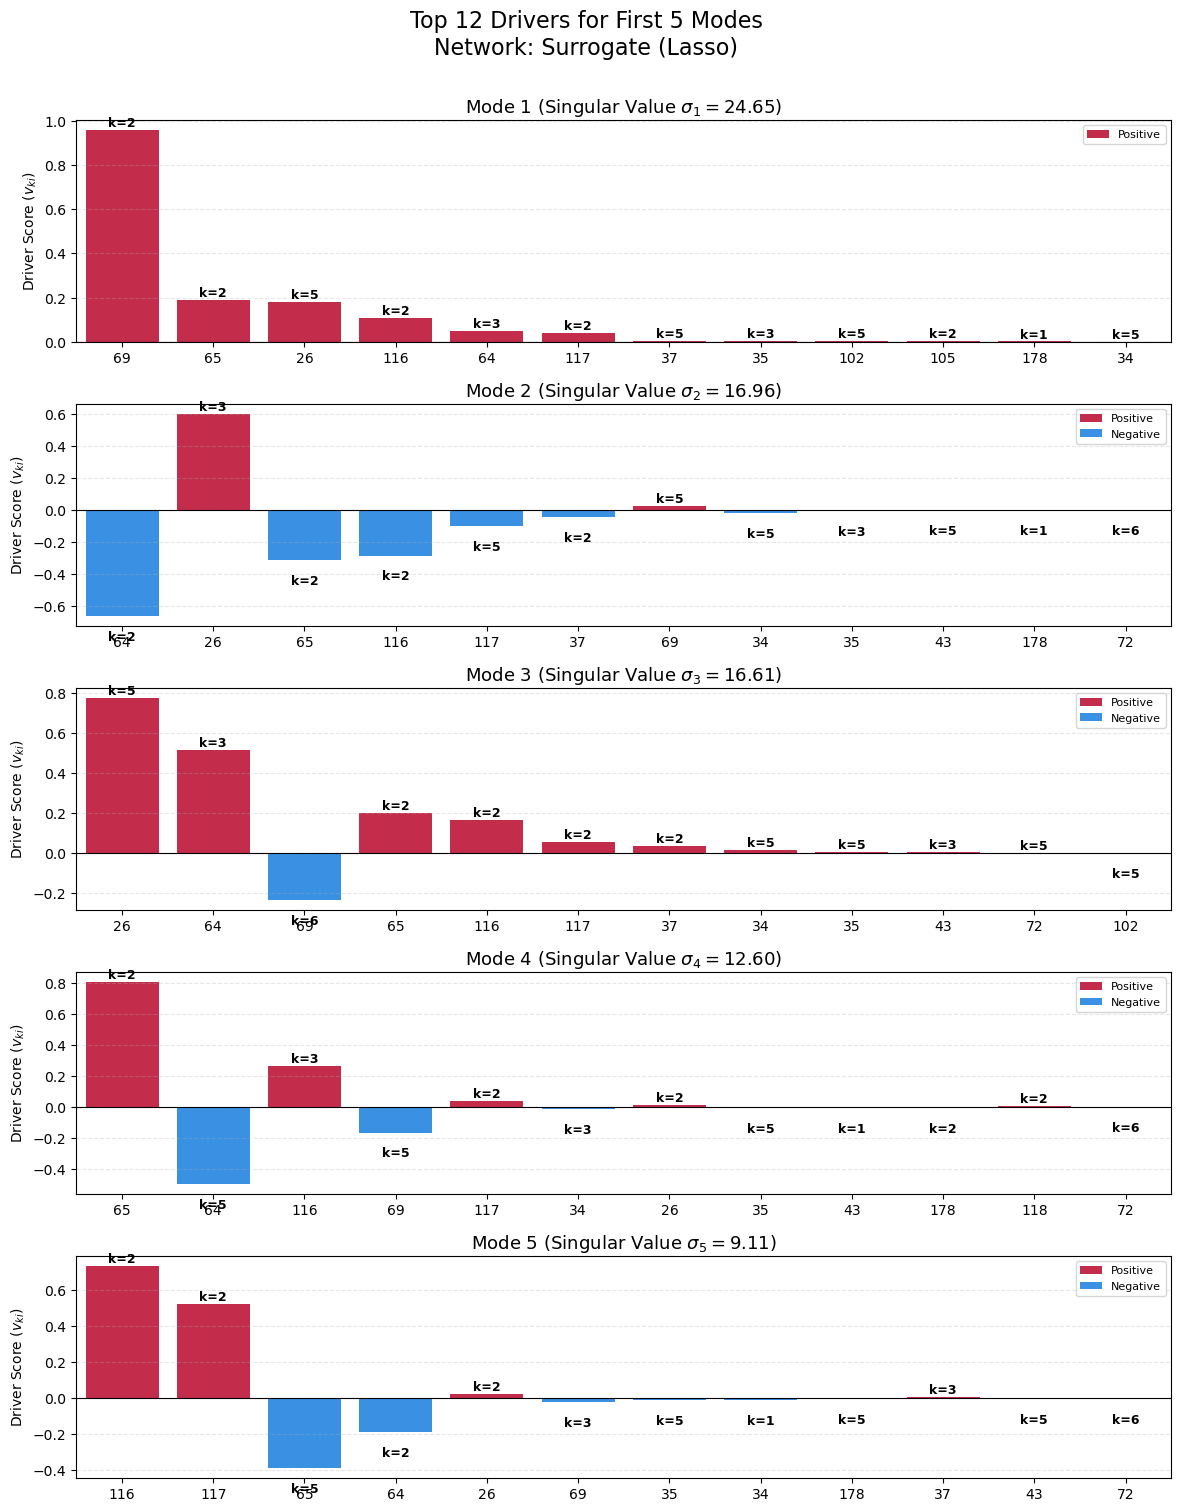

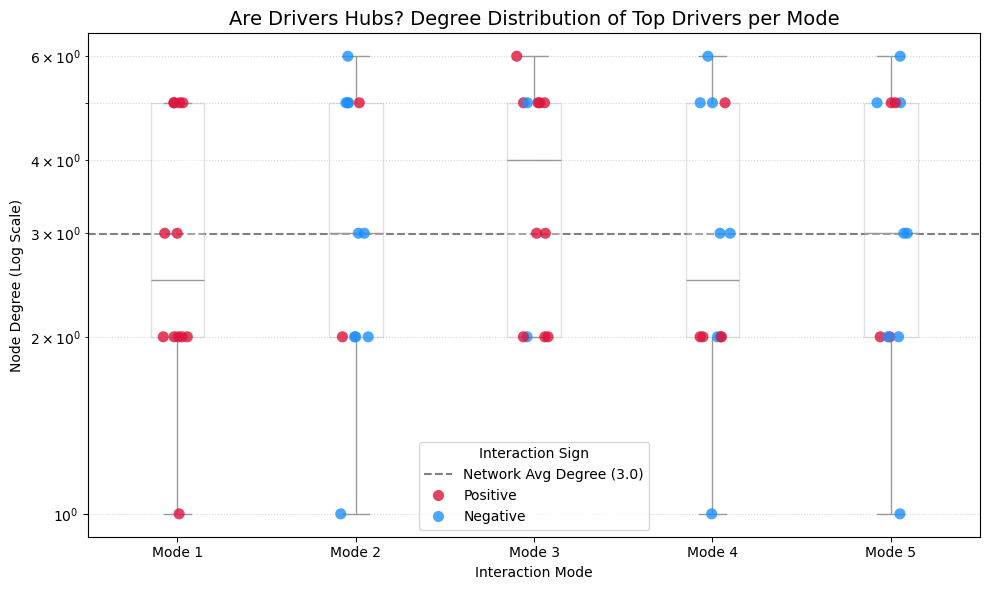

In [83]:
df_modes_hat = analyze_multi_mode_drivers(all_metrics[1], num_modes=5, top_k=12)

In [85]:
df_modes_hat

Mode      Sigma  Node ID  Coefficient  Abs Coeff      Sign  Degree  \
0   Mode 1  24.649140       69     0.957066   0.957066  Positive       2   
1   Mode 1  24.649140       65     0.189082   0.189082  Positive       2   
2   Mode 1  24.649140       26     0.179912   0.179912  Positive       5   
3   Mode 1  24.649140      116     0.106974   0.106974  Positive       2   
4   Mode 1  24.649140       64     0.051556   0.051556  Positive       3   
5   Mode 1  24.649140      117     0.041743   0.041743  Positive       2   
6   Mode 1  24.649140       37     0.004256   0.004256  Positive       5   
7   Mode 1  24.649140       35     0.003944   0.003944  Positive       3   
8   Mode 1  24.649140      102     0.002961   0.002961  Positive       5   
9   Mode 1  24.649140      105     0.002674   0.002674  Positive       2   
10  Mode 1  24.649140      178     0.002151   0.002151  Positive       1   
11  Mode 1  24.649140       34     0.001378   0.001378  Positive       5   
12  Mode 2  16.958203       64    -0.664979   0.664979  Negative       3   
13  Mode 2  16.958203       26     0.601302   0.601302  Positive       5   
14  Mode 2  16.958203       65    -0.316666   0.316666  Negative       2   
15  Mode 2  16.958203      116    -0.286640   0.286640  Negative       2   
16  Mode 2  16.958203      117    -0.103216   0.103216  Negative       2   
17  Mode 2  16.958203       37    -0.046746   0.046746  Negative       5   
18  Mode 2  16.958203       69     0.022168   0.022168  Positive       2   
19  Mode 2  16.958203       34    -0.019773   0.019773  Negative       5   
20  Mode 2  16.958203       35    -0.006650   0.006650  Negative       3   
21  Mode 2  16.958203       43    -0.004507   0.004507  Negative       5   
22  Mode 2  16.958203      178    -0.002331   0.002331  Negative       1   
23  Mode 2  16.958203       72    -0.001987   0.001987  Negative       6   
24  Mode 3  16.607924       26     0.778018   0.778018  Positive       5   
25  Mode 3  16.607924       64     0.515883   0.515883  Positive       3   
26  Mode 3  16.607924       69    -0.235170   0.235170  Negative       2   
27  Mode 3  16.607924       65     0.201148   0.201148  Positive       2   
28  Mode 3  16.607924      116     0.167416   0.167416  Positive       2   
29  Mode 3  16.607924      117     0.056847   0.056847  Positive       2   
30  Mode 3  16.607924       37     0.035483   0.035483  Positive       5   
31  Mode 3  16.607924       34     0.015433   0.015433  Positive       5   
32  Mode 3  16.607924       35     0.003505   0.003505  Positive       3   
33  Mode 3  16.607924       43     0.003479   0.003479  Positive       5   
34  Mode 3  16.607924       72     0.001076   0.001076  Positive       6   
35  Mode 3  16.607924      102    -0.001035   0.001035  Negative       5   
36  Mode 4  12.599711       65     0.806987   0.806987  Positive       2   
37  Mode 4  12.599711       64    -0.498602   0.498602  Negative       3   
38  Mode 4  12.599711      116     0.265498   0.265498  Positive       2   
39  Mode 4  12.599711       69    -0.166192   0.166192  Negative       2   
40  Mode 4  12.599711      117     0.039644   0.039644  Positive       2   
41  Mode 4  12.599711       34    -0.012208   0.012208  Negative       5   
42  Mode 4  12.599711       26     0.012208   0.012208  Positive       5   
43  Mode 4  12.599711       35    -0.006798   0.006798  Negative       3   
44  Mode 4  12.599711       43    -0.006484   0.006484  Negative       5   
45  Mode 4  12.599711      178    -0.005640   0.005640  Negative       1   
46  Mode 4  12.599711      118     0.005263   0.005263  Positive       2   
47  Mode 4  12.599711       72    -0.004179   0.004179  Negative       6   
48  Mode 5   9.111030      116     0.732758   0.732758  Positive       2   
49  Mode 5   9.111030      117     0.523208   0.523208  Positive       2   
50  Mode 5   9.111030       65    -0.389520   0.389520  Negative       2   
51  Mode 5   9.111030       64    -0.190248   0.190248

In [93]:
def plot_graph_from_adj(A):
    A = np.array(A)
    G = nx.from_numpy_array(A)

    plt.figure(figsize=(8, 8))  # 图大一点
    pos = nx.spring_layout(G, k=1.2, iterations=300)  # 更松散、布局更好

    nx.draw(
        G,
        pos,
        with_labels=False,
        node_size=30,   # 更小的节点
        font_size=10
    )

    plt.show()

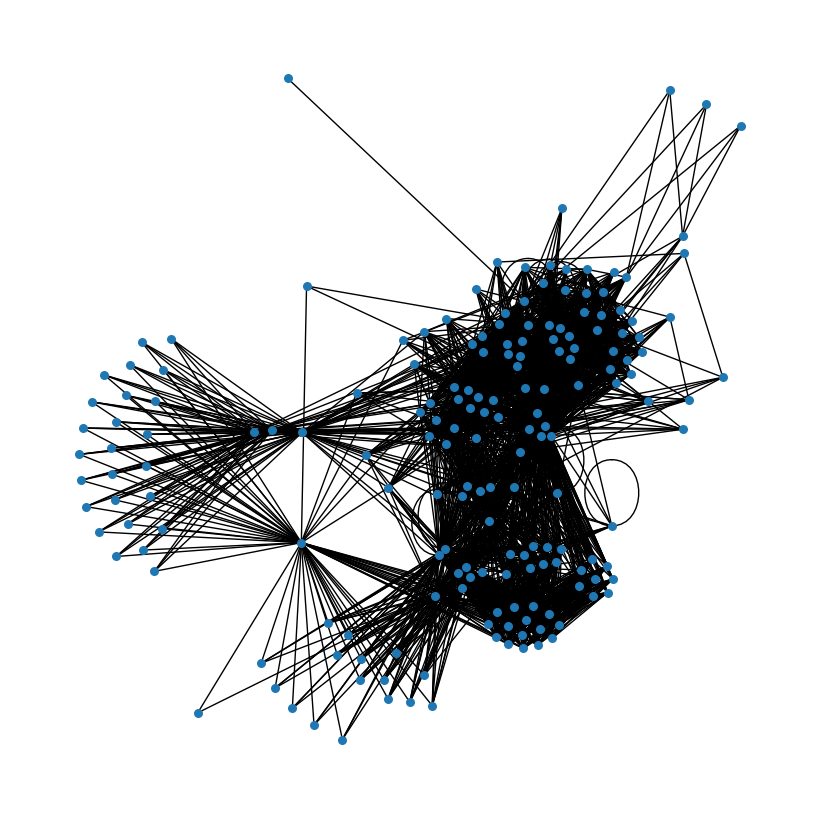

In [98]:
plot_graph_from_adj(A_true)

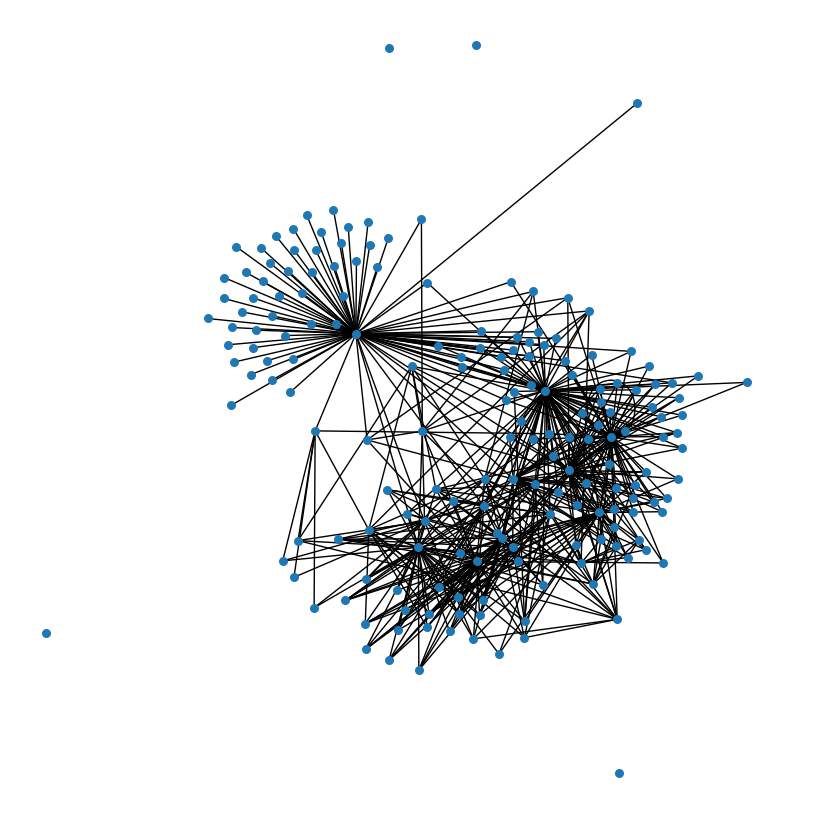

In [94]:
plot_graph_from_adj(A_hat)

In [104]:
def project_matrix_subspace(target_matrix, basis_matrix, k=10):
    """
    【投影法】利用 basis_matrix 定义的 k 维子空间，对 target_matrix 进行滤波。
    
    物理含义:
    强制 target_matrix 的能量流动只能发生在 basis_matrix 允许的 "管道" (模式) 里。
    
    参数:
    -------
    target_matrix : np.array
        被操作的矩阵 (如 A_true)。
    basis_matrix : np.array
        定义方向/模式的矩阵 (如 A_hat)。
    k : int
        保留的模式数量 (即 rank)。
        
    返回:
    -------
    A_proj : np.array
        投影后的矩阵 (非负)。
    """
    # 1. 提取基底 (Stage)
    # 这里的 U 和 Vt 定义了合法的"流入"和"流出"方向
    U, _, Vt = svd(basis_matrix, full_matrices=False)
    
    # 截取前 k 个模式
    # U_k: (N, k), Vt_k: (k, N)
    U_k = U[:, :k]
    Vt_k = Vt[:k, :]
    
    # 2. 投影运算 (Projection)
    # 公式: A_proj = P_U * A_target * P_V
    # 其中 P_U = U U.T, P_V = V.T V (注意 Vt 已经是转置后的)
    
    # Step A: 将 target 映射到 k 维特征空间
    # 计算 target 在这个子空间里的"投影分量"
    # latent_core shape: (k, k)
    latent_core = U_k.T @ target_matrix @ Vt_k.T
    
    # Step B: 重构回 N 维物理空间
    A_proj = U_k @ latent_core @ Vt_k
    
    # 3. 物理约束
    # 投影会产生微小的数学噪声(负值)，需归零
    A_proj = np.maximum(A_proj, 0)
    
    print(f"[Projection] Subspace Rank: {k}")
    print(f"  - Original Edges: {np.count_nonzero(target_matrix)}")
    print(f"  - Projected Edges: {np.count_nonzero(A_proj)} (Usually dense)")
    
    return A_proj

In [110]:
A_true_proj_on_hat = project_matrix_subspace(A_true, A_hat, k=10)
A_true_proj_on_hat

[Projection] Subspace Rank: 10
  - Original Edges: 2494
  - Projected Edges: 5591 (Usually dense)


array([[8.96125705e-18, 0.00000000e+00, 1.99617327e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.95524222e-18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.18573684e-18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 4.10158849e-18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.04530565e-18, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [111]:
print("Predicting future dynamics on A_true_proj_on_hat...")
T_pred_steps = T_total_steps - T_train_steps
X_true_proj_on_hat_future_pred = model.simulate(A_true_proj_on_hat, T_steps=T_pred_steps, init_state=x0_pred)
X_true_proj_on_hat_full_pred = np.vstack([X_train, X_true_proj_on_hat_future_pred])
print("A_true_proj_on_hat simulation finish")

Predicting future dynamics on A_true_proj_on_hat...
A_true_proj_on_hat simulation finish


In [40]:
def reconstruct_network_generic(X, model, val_ratio=0.2, n_alphas=20, threshold=0.01):
    """(同之前定义的重构函数)"""
    T, N = X.shape
    dt = model.dt
    X_t = X[:-1]
    X_tp1 = X[1:]
    t_len = len(X_t)
    
    # 1. 构建回归目标 Y 和特征 Phi
    deriv_approx = (X_tp1 - X_t) / dt
    f_term = model.f(X_t)
    Y_target = deriv_approx - f_term
    Phi_features = model.get_interaction_matrix(X_t)
    
    # 2. 划分数据
    n_train = int(t_len * (1 - val_ratio))
    Y_train, Y_val = Y_target[:n_train], Y_target[n_train:]
    Phi_train, Phi_val = Phi_features[:n_train], Phi_features[n_train:]
    
    A_hat = np.zeros((N, N))
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i in range(N):
            y_tr = Y_train[:, i]
            Phi_tr = Phi_train[:, i, :]
            y_v = Y_val[:, i]
            Phi_v = Phi_val[:, i, :]
            
            # 启发式 Rho
            dot = Phi_tr.T @ y_tr
            rho_max = np.max(np.abs(dot)) / n_train if n_train > 0 else 1.0
            if rho_max < 1e-9: rho_max = 1e-3
            alphas = np.logspace(np.log10(1e-4*rho_max), np.log10(rho_max), n_alphas)
            
            best_mse = np.inf
            best_alpha = alphas[0]
            
            # CV
            for alpha in alphas:
                lasso = Lasso(alpha=alpha, fit_intercept=False, positive=True, max_iter=2000)
                lasso.fit(Phi_tr, y_tr)
                coef = lasso.coef_.copy()
                coef[np.abs(coef) < threshold] = 0
                if np.sum(np.abs(coef)) == 0: mse = np.mean(y_v**2)
                else: mse = mean_squared_error(y_v, Phi_v @ coef)
                
                if mse < best_mse:
                    best_mse = mse
                    best_alpha = alpha
            
            # Final Fit
            lasso_fin = Lasso(alpha=best_alpha, fit_intercept=False, positive=True, max_iter=5000)
            lasso_fin.fit(Phi_features[:, i, :], Y_target[:, i])
            final_coef = lasso_fin.coef_
            final_coef[np.abs(final_coef) < threshold] = 0
            A_hat[i, :] = final_coef
            
    return A_hat

In [42]:
# 3. 【Ground Truth 模拟】在真实网络 A_true 上运行
print(f"1. Running Ground Truth simulation on A_true (Total steps: {T_total_steps})...")
# 随机初始状态
x0_true = np.random.uniform(0.1, 1.0, N)
X_obs = model.simulate(A_true, T_steps=T_total_steps, init_state=x0_true)

# 4. 【数据切分】
# 取前 50 步作为训练数据 (Observation Phase)
X_train = X_obs[:T_train_steps] 
# 取第 50 步作为预测的起点 (Initial Condition for Prediction)
x0_pred = X_obs[T_train_steps]   # 这是 t=50 时刻的状态
# 取剩余部分作为真值对比 (Ground Truth for Validation)
X_future_true = X_obs[T_train_steps:] 

# 5. 【网络重构】利用前 50 步构建 A_hat
print(f"2. Reconstructing surrogate network using first {T_train_steps} steps...")
# 注意：这里我们直接把 model 传进去，利用已知的 f 和 g
A_hat = reconstruct_network_generic(X_train, model, threshold=0.01)

# 6. 【动力学预测】在 A_hat 上运行，起点设为 X_obs[50]
print("3. Predicting future dynamics on A_hat...")
# 计算需要预测多少步
T_pred_steps = T_total_steps - T_train_steps

# *** 关键点 ***：调用 simulate，传入 A_hat 和 x0_pred
X_future_pred = model.simulate(A_hat, T_steps=T_pred_steps, init_state=x0_pred)

# 拼接预测轨迹用于画图 (把前50步观测 + 后150步预测连起来)
X_full_pred = np.vstack([X_train, X_future_pred])

1. Running Ground Truth simulation on A_true (Total steps: 100)...
2. Reconstructing surrogate network using first 20 steps...
3. Predicting future dynamics on A_hat...


C:\Users\liu.xuanc\AppData\Local\Temp\ipykernel_31448\1637347558.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')(np.linspace(0, 1, num_plot_nodes))


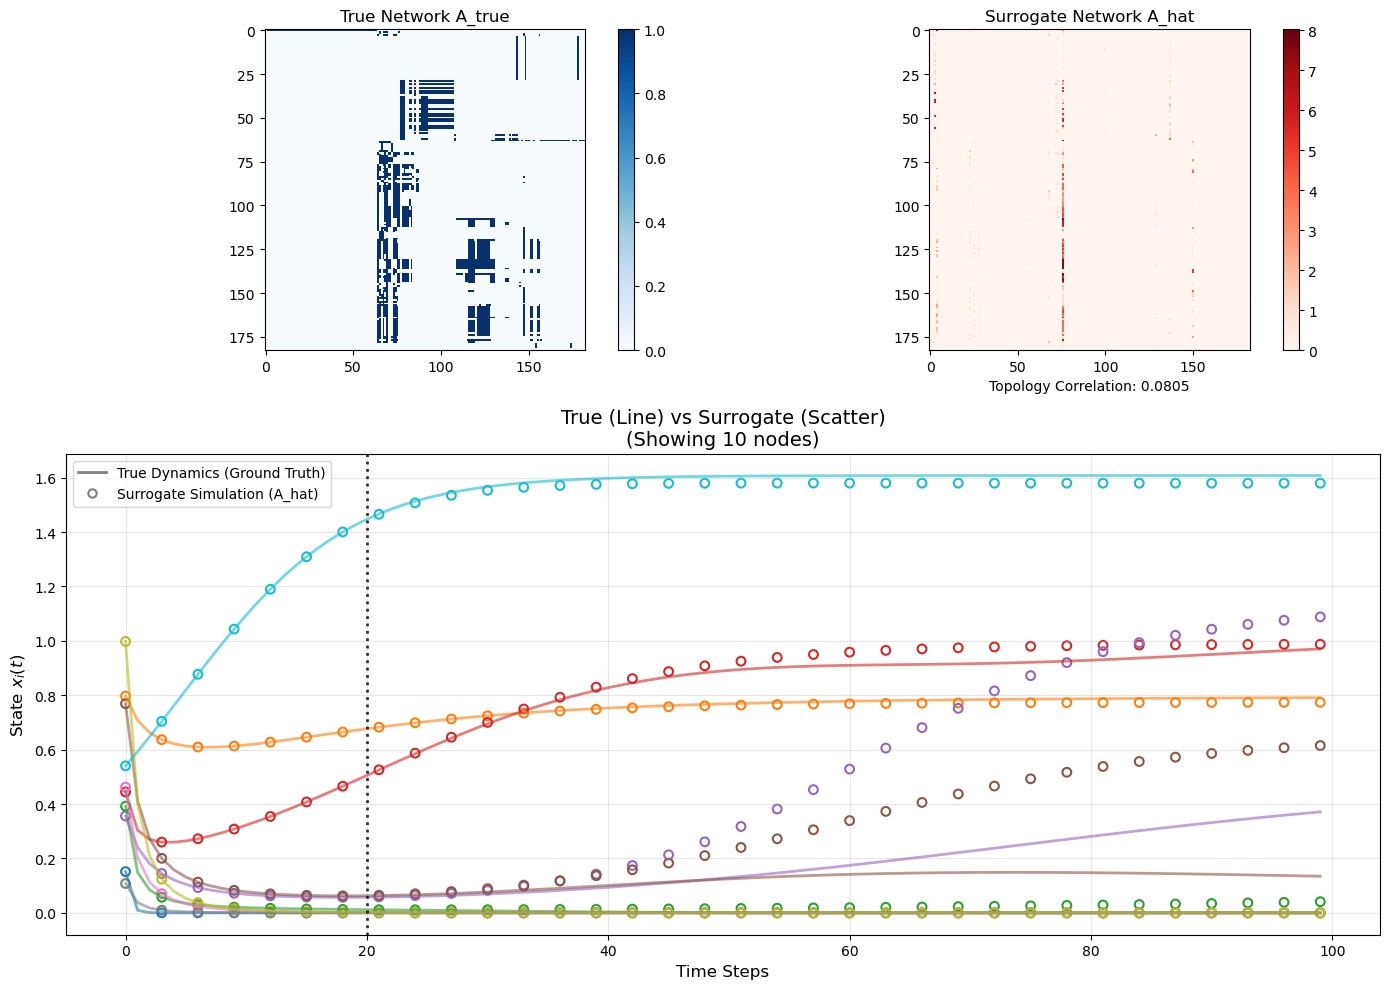

In [46]:
# Figure
fig = plt.figure(figsize=(14, 10))
grid = plt.GridSpec(2, 2, height_ratios=[1, 1.5])

# --- 图 1: 网络拓扑对比 (保持不变) ---
ax1 = fig.add_subplot(grid[0, 0])
cax1 = ax1.imshow(A_true, cmap='Blues', interpolation='nearest')
ax1.set_title("True Network A_true")
fig.colorbar(cax1, ax=ax1)

ax2 = fig.add_subplot(grid[0, 1])
cax2 = ax2.imshow(A_hat, cmap='Reds', interpolation='nearest')
ax2.set_title("Surrogate Network A_hat")
fig.colorbar(cax2, ax=ax2)

# 计算拓扑相关性
flatten_true = A_true.flatten()
flatten_hat = A_hat.flatten()
corr = np.corrcoef(flatten_true, flatten_hat)[0, 1]
ax2.set_xlabel(f"Topology Correlation: {corr:.4f}")

# --- 图 2: 动力学轨迹对比 (核心修改) ---
ax3 = fig.add_subplot(grid[1, :])

# 1. 【自定义设置】: 在这里修改你想要画的节点数量
num_plot_nodes = 10   # Uumber of nodes being plotted
scatter_interval = 3 # Time steps for plotting each nodes

# 自动选择节点和颜色
if num_plot_nodes > N: num_plot_nodes = N
# 均匀选择节点索引
nodes_to_plot = np.linspace(0, N-1, num_plot_nodes, dtype=int)
# 生成颜色映射 (使用 'tab10', 'jet', 'viridis' 等)
colors = cm.get_cmap('tab10')(np.linspace(0, 1, num_plot_nodes))

time_steps = np.arange(T_total_steps)

for idx, node_idx in enumerate(nodes_to_plot):
    color = colors[idx]
    
    # A. 绘制真实轨迹 (实线)
    # alpha=0.6 让线条稍微透明一点，突显上面的散点
    ax3.plot(time_steps, X_obs[:, node_idx], 
             color=color, linestyle='-', linewidth=2, alpha=0.6,
             label=f'Node {node_idx} (True)')
    
    # B. 绘制 Surrogate 轨迹 (散点)
    # 使用切片 [::scatter_interval] 进行稀疏化，防止点太密成线
    sparse_indices = np.arange(0, T_total_steps, scatter_interval)
    
    ax3.scatter(time_steps[sparse_indices], X_full_pred[sparse_indices, node_idx], 
                edgecolors=color,    # 边框颜色与实线一致
                facecolors='none',   # 内部透明 (空心圆)
                marker='o',          # 圆圈形状
                s=40,                # 点的大小
                linewidth=1.5,       # 边框粗细
                label=f'Node {node_idx} (Surrogate)' if idx == 0 else None) 
                # label 仅加一次，避免图例太长

# 添加训练/预测分界线
ax3.axvline(x=T_train_steps, color='k', linestyle=':', linewidth=2, alpha=0.8)
# ax3.text(T_train_steps + 2, np.max(X_obs)*0.95, 'Prediction Start', fontsize=12, fontweight='bold')

ax3.set_title(f"True (Line) vs Surrogate (Scatter)\n(Showing {num_plot_nodes} nodes)", fontsize=14)
ax3.set_xlabel("Time Steps", fontsize=12)
ax3.set_ylabel("State $x_i(t)$", fontsize=12)

# 优化图例：只显示一次 True 和 Surrogate 的代表，而不是每个节点都显示两遍
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray', lw=2, linestyle='-'),
                Line2D([0], [0], color='gray', marker='o', linestyle='None', 
                       markerfacecolor='none', markeredgewidth=1.5)]
ax3.legend(custom_lines, ['True Dynamics (Ground Truth)', 'Surrogate Simulation (A_hat)'], 
           loc='upper left', fontsize=10)

ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\liu.xuanc\AppData\Local\Temp\ipykernel_19420\1268715552.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')(np.linspace(0, 1, num_plot_nodes))


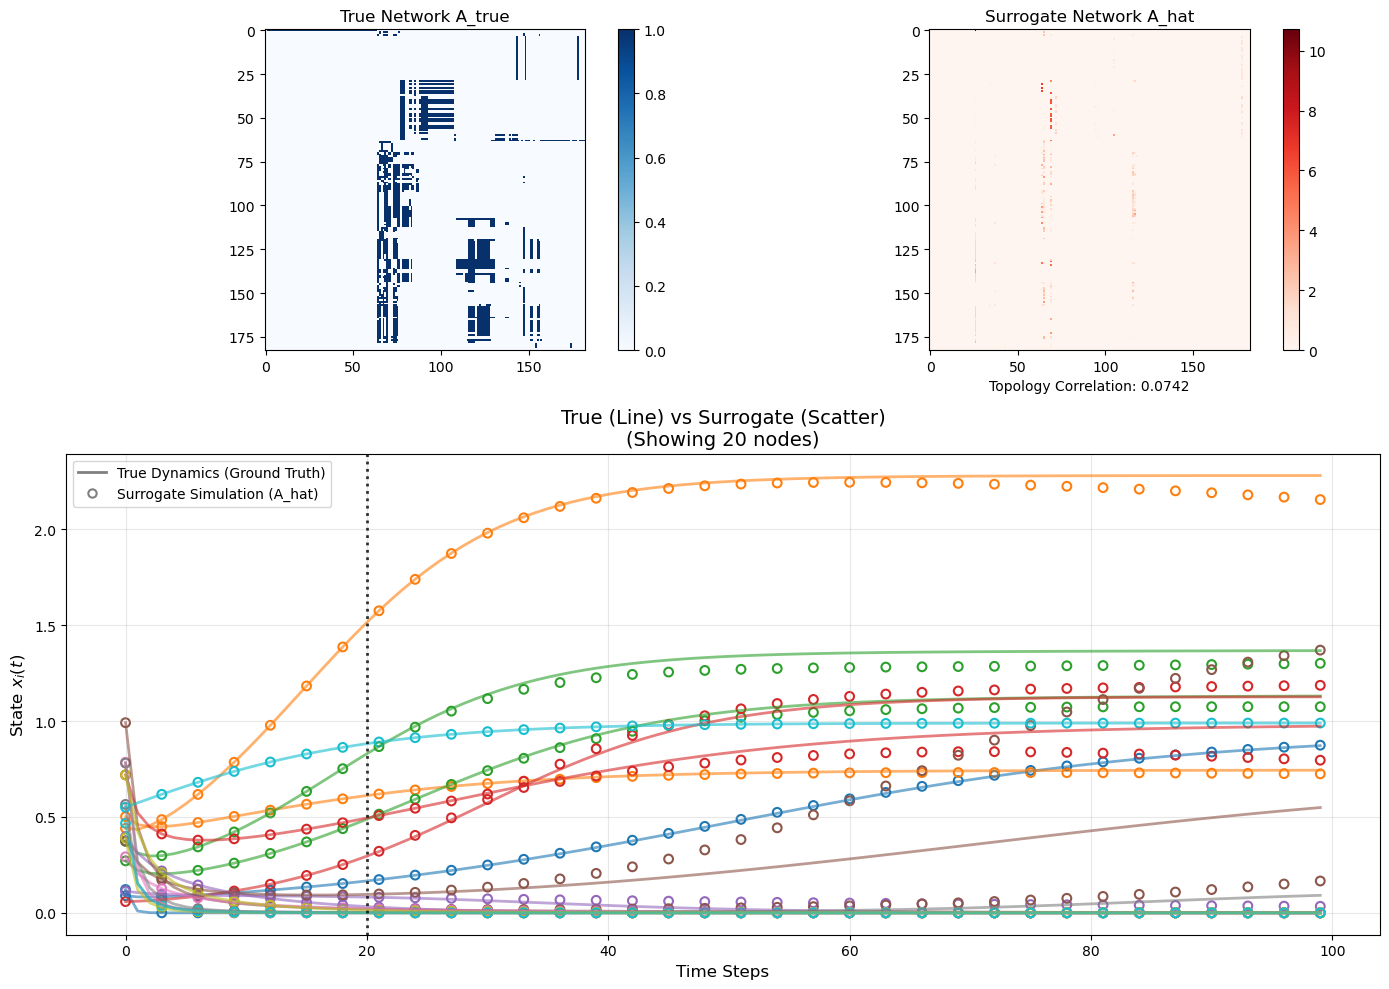

In [14]:
# Figure
fig = plt.figure(figsize=(14, 10))
grid = plt.GridSpec(2, 2, height_ratios=[1, 1.5])

# --- 图 1: 网络拓扑对比 (保持不变) ---
ax1 = fig.add_subplot(grid[0, 0])
cax1 = ax1.imshow(A_true, cmap='Blues', interpolation='nearest')
ax1.set_title("True Network A_true")
fig.colorbar(cax1, ax=ax1)

ax2 = fig.add_subplot(grid[0, 1])
cax2 = ax2.imshow(A_hat, cmap='Reds', interpolation='nearest')
ax2.set_title("Surrogate Network A_hat")
fig.colorbar(cax2, ax=ax2)

# 计算拓扑相关性
flatten_true = A_true.flatten()
flatten_hat = A_hat.flatten()
corr = np.corrcoef(flatten_true, flatten_hat)[0, 1]
ax2.set_xlabel(f"Topology Correlation: {corr:.4f}")

# --- 图 2: 动力学轨迹对比 (核心修改) ---
ax3 = fig.add_subplot(grid[1, :])

# 1. 【自定义设置】: 在这里修改你想要画的节点数量
num_plot_nodes = 20   # Uumber of nodes being plotted
scatter_interval = 3 # Time steps for plotting each nodes

# 自动选择节点和颜色
if num_plot_nodes > N: num_plot_nodes = N
# 均匀选择节点索引
nodes_to_plot = np.linspace(0, N-1, num_plot_nodes, dtype=int)
# 生成颜色映射 (使用 'tab10', 'jet', 'viridis' 等)
colors = cm.get_cmap('tab10')(np.linspace(0, 1, num_plot_nodes))

time_steps = np.arange(T_total_steps)

for idx, node_idx in enumerate(nodes_to_plot):
    color = colors[idx]
    
    # A. 绘制真实轨迹 (实线)
    # alpha=0.6 让线条稍微透明一点，突显上面的散点
    ax3.plot(time_steps, X_obs[:, node_idx], 
             color=color, linestyle='-', linewidth=2, alpha=0.6,
             label=f'Node {node_idx} (True)')
    
    # B. 绘制 Surrogate 轨迹 (散点)
    # 使用切片 [::scatter_interval] 进行稀疏化，防止点太密成线
    sparse_indices = np.arange(0, T_total_steps, scatter_interval)
    
    ax3.scatter(time_steps[sparse_indices], X_full_pred[sparse_indices, node_idx], 
                edgecolors=color,    # 边框颜色与实线一致
                facecolors='none',   # 内部透明 (空心圆)
                marker='o',          # 圆圈形状
                s=40,                # 点的大小
                linewidth=1.5,       # 边框粗细
                label=f'Node {node_idx} (Surrogate)' if idx == 0 else None) 
                # label 仅加一次，避免图例太长

# 添加训练/预测分界线
ax3.axvline(x=T_train_steps, color='k', linestyle=':', linewidth=2, alpha=0.8)
# ax3.text(T_train_steps + 2, np.max(X_obs)*0.95, 'Prediction Start', fontsize=12, fontweight='bold')

ax3.set_title(f"True (Line) vs Surrogate (Scatter)\n(Showing {num_plot_nodes} nodes)", fontsize=14)
ax3.set_xlabel("Time Steps", fontsize=12)
ax3.set_ylabel("State $x_i(t)$", fontsize=12)

# 优化图例：只显示一次 True 和 Surrogate 的代表，而不是每个节点都显示两遍
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray', lw=2, linestyle='-'),
                Line2D([0], [0], color='gray', marker='o', linestyle='None', 
                       markerfacecolor='none', markeredgewidth=1.5)]
ax3.legend(custom_lines, ['True Dynamics (Ground Truth)', 'Surrogate Simulation (A_hat)'], 
           loc='upper left', fontsize=10)

ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [107]:
def filter_network_by_nodes(target_matrix, basis_matrix, k_modes=10, top_x_per_mode=15, neighbor_strategy='induced'):
    """
    【筛选法】根据 basis_matrix 的主导模式筛选 target_matrix 中的关键节点。
    
    参数:
    -------
    target_matrix : np.array
        被操作的矩阵 (如 A_true)。
    basis_matrix : np.array
        用于识别关键节点的参考矩阵 (如 A_hat)。
    k_modes : int
        考虑前多少个 Sigma 对应的模式。
    top_x_per_mode : int
        每个模式中选出多少个贡献最大的节点。
    neighbor_strategy : str
        'induced' : (严格) 只保留被选节点**之间**的连边。
                    这是测试"富人俱乐部"是否能独立驱动动力学。
        'ego'     : (您的原始设想) 保留被选节点及其**所有邻居**的连边。
                    这保留了更多信息，但也引入了更多"非骨架"噪音。
        
    返回:
    -------
    A_filtered : np.array
        筛选后的矩阵 (其余位置置 0，维度保持 N x N 不变)。
    """
    N = target_matrix.shape[0]
    
    # 1. 识别关键节点 (Key Drivers)
    # 使用 basis_matrix 的 Vt (发送端/Source) 来识别
    _, _, Vt = svd(basis_matrix, full_matrices=False)
    
    selected_nodes = set()
    
    # 遍历前 k 个模式
    for i in range(k_modes):
        v_vec = Vt[i, :]
        # 找出绝对值最大的索引
        top_indices = np.argsort(np.abs(v_vec))[::-1][:top_x_per_mode]
        selected_nodes.update(top_indices)
        
    selected_nodes = list(selected_nodes)
    num_selected = len(selected_nodes)
    
    # 2. 构建掩膜 (Mask)
    mask = np.zeros((N, N), dtype=bool)
    
    if neighbor_strategy == 'induced':
        # 策略 A: 仅保留核心节点内部的连接 (Sub-graph)
        # Mask[i, j] = True 仅当 i 和 j 都在 selected_nodes 里
        # 利用网格索引快速构建
        grid_idx = np.ix_(selected_nodes, selected_nodes)
        mask[grid_idx] = True
        
    elif neighbor_strategy == 'ego':
        # 策略 B: 保留核心节点及其所有邻居 (Ego-graph)
        # Mask[i, j] = True 只要 i 或 j 有一个是核心节点
        # 这意味着保留了核心节点的所有入边和出边
        for node in selected_nodes:
            mask[node, :] = True # 保留该节点的出边
            mask[:, node] = True # 保留该节点的入边
            
    else:
        raise ValueError("Strategy must be 'induced' or 'ego'")
        
    # 3. 应用筛选
    A_filtered = target_matrix * mask
    
    print(f"[Selection] Strategy: {neighbor_strategy}")
    print(f"  - Modes Considered: {k_modes}, Top-X per mode: {top_x_per_mode}")
    print(f"  - Unique Nodes Selected: {num_selected}/{N} ({num_selected/N:.1%})")
    print(f"  - Edges Retained: {np.count_nonzero(A_filtered)} / {np.count_nonzero(target_matrix)}")
    
    return A_filtered

In [25]:
def calculate_ccdf(degrees):
    """
    辅助函数：计算互补累积分布 P(D >= k)
    """
    degrees = np.sort(degrees)
    n = len(degrees)
    # y轴：从 1 降到 1/n
    y = np.arange(n, 0, -1) / n
    return degrees, y

def plot_topology_comparison(metrics_list, figsize=(10, 6)):
    """
    专门用于对比拓扑结构（度分布）的绘图函数。
    
    输入:
    metrics_list : 包含 'topology' 数据的字典列表 (由 get_comprehensive_metrics 生成)
                   metrics_list[0] 默认为 True Network
    """
    # 基础设置
    n_matrices = len(metrics_list)
    if n_matrices < 2:
        print("At least two networks")
        return

    mt = metrics_list[0]      # Ground Truth
    m_hats = metrics_list[1:] # Surrogates
    
    color_true = 'navy'
    colors = [color_true] + [cm.tab10(i+1) for i in range(len(m_hats))]
    
    # 创建画布
    fig, ax = plt.subplots(figsize=figsize)

    # Surrogate Networks
    deg_t, prob_t = calculate_ccdf(mt['topology']['in_degrees'])
    
    # 使用 'step' 绘图，where='post' 是标准的生存分析/CCDF 画法
    ax.step(deg_t, prob_t, where='post', 
            color=colors[0], lw=3, alpha=0.9, 
            label=f"{mt['name']} (Edges: {mt['topology']['num_edges']})")
    
    # Surrogate Networks
    for idx, mh in enumerate(m_hats):
        deg_h, prob_h = calculate_ccdf(mh['topology']['in_degrees'])
        
        # 使用虚线或点线区分
        ax.step(deg_h, prob_h, where='post', 
                color=colors[idx+1], lw=2, linestyle='--', alpha=0.8,
                label=f"{mh['name']} (Edges: {mh['topology']['num_edges']})")
        
        # KS Statistic
    
    # --------------------------------------------------------
    # 图表美化
    # --------------------------------------------------------
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel("Degree ($k$)", fontsize=12)
    ax.set_ylabel("CCDF $P(K \geq k)$", fontsize=12)
    ax.set_title("Topology Comparison: Degree Distribution", fontsize=14, fontweight='bold')
    
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.legend(fontsize=10, loc='lower left') 
    
    plt.tight_layout()
    plt.show()

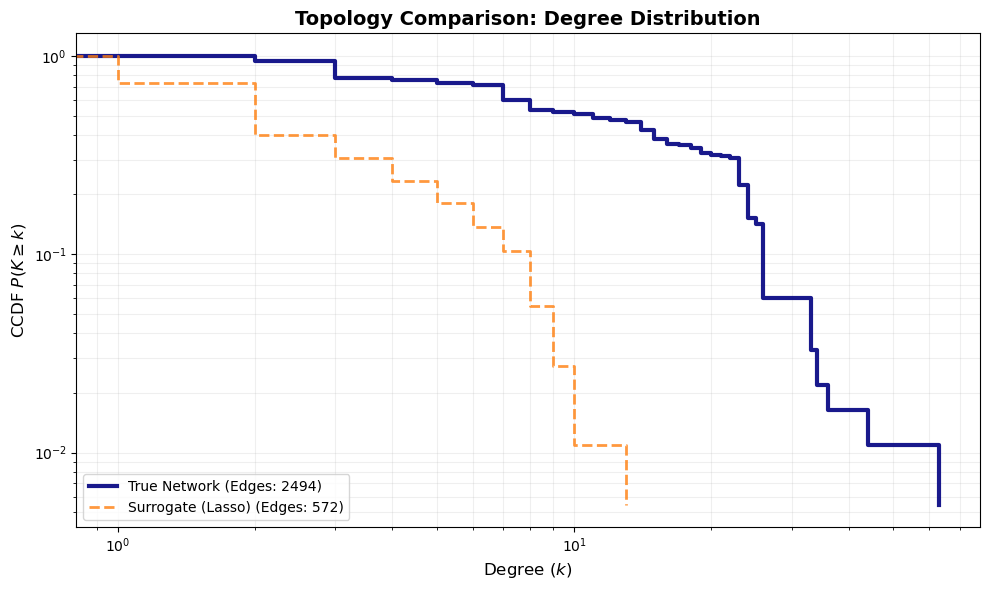

In [29]:
plot_topology_comparison(all_metrics, figsize=(10, 6))

In [17]:
def calculate_topology_auc(A_true, A_hat, mask_diagonal=True):
    # 1. 数据预处理
    if mask_diagonal:
        # 获取非对角线元素的索引
        N = A_true.shape[0]
        mask = ~np.eye(N, dtype=bool)
        
        # 只提取非对角线元素
        flat_true = A_true[mask]
        flat_hat = A_hat[mask]
    else:
        # 展平整个矩阵
        flat_true = A_true.flatten()
        flat_hat = A_hat.flatten()
        
    # 2. 构建二分类标签 (y_true)
    # 论文指出："If there is a directed link... then a_ij > 0, otherwise a_ij = 0" [cite: 635]
    # 且 AUC 是衡量 "Topological similarity" [cite: 1001]，即只看有没有边。
    y_true = (flat_true > 0).astype(int)
    
    # 3. 准备预测分数 (y_score)
    # A_hat 的权重值充当“存在边的概率或置信度”
    y_scores = flat_hat
    
    # 4. 计算 AUC
    # roc_auc_score 会自动处理所有可能的阈值 epsilon
    try:
        auc_val = roc_auc_score(y_true, y_scores)
    except ValueError:
        # 如果 y_true 全是 0 或 全是 1（例如空网络或全连接网络），AUC 无法定义
        print("警告: A_true 中只有一类标签（全有边或全无边），无法计算 AUC。")
        return 0.5
        
    return auc_val

In [18]:
auc = calculate_topology_auc(A_true, A_hat)
print(f"AUC: {auc:.4f}")

AUC: 0.4995


In [132]:
def plot_network_diff(A_true, A_hat, threshold=0.0):
    """
    绘制 A_true 和 A_hat 之间差异的网络图：
    - green: 两者都有
    - red:   只在 A_true
    - blue:  只在 A_hat
    """

    # ---- Step 1: 二值化邻接矩阵 ----
    A1 = (A_true > threshold).astype(int)
    A2 = (A_hat > threshold).astype(int)

    n = A1.shape[0]

    # ---- Step 2: 求三类边 ----
    edges_true = set(zip(*np.where(A1 == 1)))
    edges_hat  = set(zip(*np.where(A2 == 1)))

    edges_common = edges_true & edges_hat
    edges_only_true = edges_true - edges_hat
    edges_only_hat  = edges_hat - edges_true

    # ---- Step 3: 构建图 ----
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(edges_common)
    G.add_edges_from(edges_only_true)
    G.add_edges_from(edges_only_hat)

    # ---- Step 4: 节点位置 ----
    pos = nx.spring_layout(G, seed=0)

    # ---- Step 5: 绘图 ----
    plt.figure(figsize=(10, 10))

    # 节点（更小）
    nx.draw_networkx_nodes(
        G, pos,
        node_size=40,
        node_color="lightgrey"
    )

    # 仅 A_true 边（红色）
    nx.draw_networkx_edges(
        G, pos,
        edgelist=list(edges_only_true),
        width=0.8, edge_color="#d62728", alpha=0.4
    )

    # 仅 A_hat 边（蓝色）
    nx.draw_networkx_edges(
        G, pos,
        edgelist=list(edges_only_hat),
        width=0.8, edge_color="#1f77b4", alpha=0.4
    )

    # 共同边（绿色，变细）
    nx.draw_networkx_edges(
        G, pos,
        edgelist=list(edges_common),
        width=0.8, edge_color="#2ca02c"
    )

    # 不显示节点标签
    # nx.draw_networkx_labels(G, pos)

    # 图例
    plt.scatter([], [], color="#d62728", label="Only in A_true")
    plt.scatter([], [], color="#1f77b4", label="Only in A_hat")
    plt.scatter([], [], color="#2ca02c", label="Common")
    plt.legend()

    plt.title("Difference Between A_true and A_hat")
    plt.axis("off")
    plt.show()

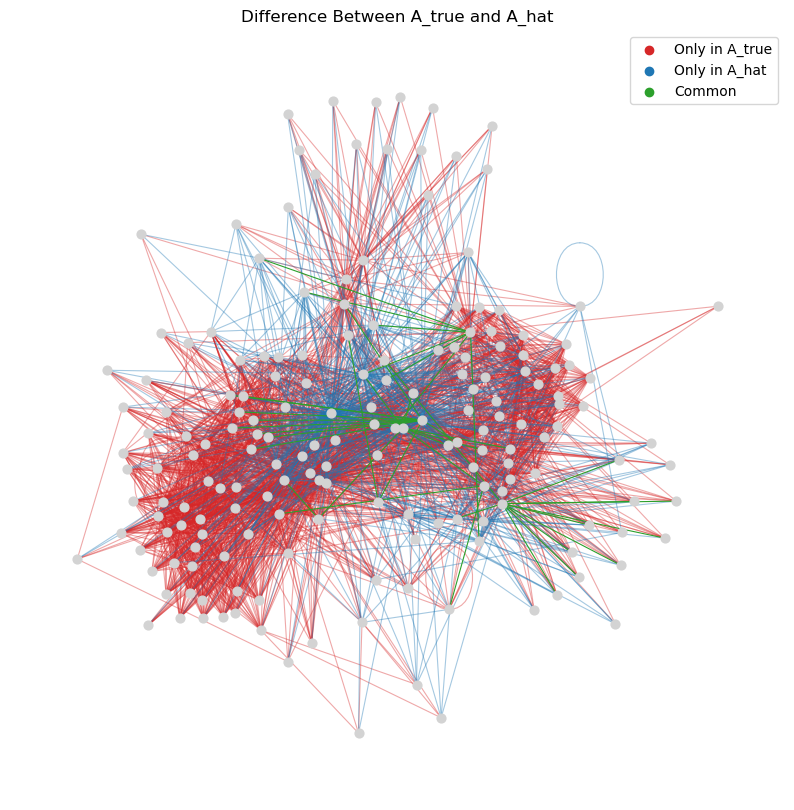

In [133]:
plot_network_diff(A_true, A_hat)

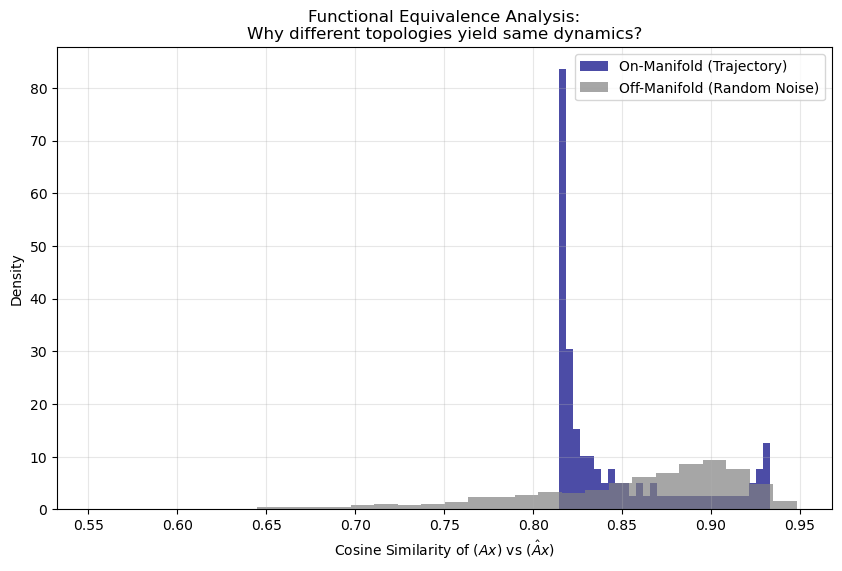

平均相似度 (On-Manifold): 0.8458
平均相似度 (Off-Manifold): 0.8539


In [136]:
def analyze_functional_equivalence(A_true, A_hat, X_obs, num_random=1000):
    """
    分析 A_true 和 A_hat 在 '动力学流形上' 和 '流形外' 的等效性。
    """
    N = A_true.shape[0]
    
    # 1. 在流形上 (On-Manifold): 使用观测到的真实轨迹 X_obs
    # 计算 A * x
    # 注意：X_obs 是 (T, N)，我们需要 (N, T) 来做矩阵乘法 A @ x
    states_manifold = X_obs.T 
    action_true_m = A_true @ states_manifold
    action_hat_m  = A_hat @ states_manifold
    
    # 计算每一时刻的余弦相似度
    # (N, T) -> 对每一列计算相似度
    sim_manifold = []
    for t in range(action_true_m.shape[1]):
        v1 = action_true_m[:, t].reshape(1, -1)
        v2 = action_hat_m[:, t].reshape(1, -1)
        sim = cosine_similarity(v1, v2)[0, 0]
        sim_manifold.append(sim)
        
    # 2. 在流形外 (Off-Manifold): 使用完全随机的状态
    # 模拟随机状态 (例如均匀分布或高斯分布，范围与真实状态一致)
    x_min, x_max = np.min(X_obs), np.max(X_obs)
    states_random = np.random.uniform(x_min, x_max, (N, num_random))
    
    action_true_r = A_true @ states_random
    action_hat_r  = A_hat @ states_random
    
    sim_random = []
    for i in range(num_random):
        v1 = action_true_r[:, i].reshape(1, -1)
        v2 = action_hat_r[:, i].reshape(1, -1)
        sim = cosine_similarity(v1, v2)[0, 0]
        sim_random.append(sim)
        
    # 3. 绘图
    plt.figure(figsize=(10, 6))
    plt.hist(sim_manifold, bins=30, alpha=0.7, label='On-Manifold (Trajectory)', color='navy', density=True)
    plt.hist(sim_random, bins=30, alpha=0.7, label='Off-Manifold (Random Noise)', color='gray', density=True)
    
    plt.xlabel("Cosine Similarity of $(Ax)$ vs $(\hat{A}x)$")
    plt.ylabel("Density")
    plt.title("Functional Equivalence Analysis:\nWhy different topologies yield same dynamics?")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"平均相似度 (On-Manifold): {np.mean(sim_manifold):.4f}")
    print(f"平均相似度 (Off-Manifold): {np.mean(sim_random):.4f}")

# 运行分析
analyze_functional_equivalence(A_true, A_hat, X_obs)

In [140]:
N = A_true.shape[0]
num_random = 1000

# 1. 在流形上 (On-Manifold): 使用观测到的真实轨迹 X_obs
# 计算 A * x
# 注意：X_obs 是 (T, N)，我们需要 (N, T) 来做矩阵乘法 A @ x
states_manifold = X_obs.T 
action_true_m = A_true @ states_manifold
action_hat_m  = A_hat @ states_manifold

# 计算每一时刻的余弦相似度
# (N, T) -> 对每一列计算相似度
sim_manifold = []
for t in range(action_true_m.shape[1]):
    v1 = action_true_m[:, t].reshape(1, -1)
    v2 = action_hat_m[:, t].reshape(1, -1)
    sim = cosine_similarity(v1, v2)[0, 0]
    sim_manifold.append(sim)
    
# 2. 在流形外 (Off-Manifold): 使用完全随机的状态
# 模拟随机状态 (例如均匀分布或高斯分布，范围与真实状态一致)
x_min, x_max = np.min(X_obs), np.max(X_obs)
states_random = np.random.uniform(x_min, x_max, (N, num_random))

action_true_r = A_true @ states_random
action_hat_r  = A_hat @ states_random

sim_random = []
for i in range(num_random):
    v1 = action_true_r[:, i].reshape(1, -1)
    v2 = action_hat_r[:, i].reshape(1, -1)
    sim = cosine_similarity(v1, v2)[0, 0]
    sim_random.append(sim)

<font size = 5 color = black>From the Ranks to more networks</font>

In [38]:
def generate_rdpg_network(A_backbone, k=None, seed=None):
    """
    方法 1: 随机点积图生成 (RDPG)
    保留骨架作为“连接概率”，重新采样生成具体的边。
    
    参数:
    A_backbone: np.array, 骨架矩阵 (通常是 A_hat)
    k: int, 截断秩 (如果 A_backbone 已经是低秩的，可设为 None)
    
    返回:
    A_new: 重新采样生成的网络
    """
    if seed is not None:
        np.random.seed(seed)
        
    # 1. 提取低秩骨架 L (期望矩阵 <W>)
    U, S, Vt = svd(A_backbone, full_matrices=False)
    if k is None:
        k = len(S)
    
    # 重构期望矩阵 P (概率矩阵)
    # 取绝对值或 ReLU 确保非负 (作为概率/强度期望)
    P = np.abs(U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :])
    
    # 归一化概率 (防止数值超过 1，如果是加权网络，这里 P 代表期望权重)
    # 对于加权网络，我们假设 A_new ~ Poisson(P) 或 A_new ~ Normal(P, noise)
    # 这里使用泊松采样来模拟离散的连接事件，保持期望值为 P
    A_new = np.random.poisson(P).astype(float)
    
    # 或者：如果只想生成二值拓扑，再赋予平均权重
    # prob_matrix = np.clip(P, 0, 1)
    # A_binary = np.random.binomial(1, prob_matrix)
    # A_new = A_binary * np.mean(A_backbone[A_backbone>0])
    
    return A_new

In [39]:
def generate_configuration_model(A_origin, swaps=10, seed=None):
    """
    方法 2: 加权构型模型 (保持强度重连)
    保留每个节点的入度/出度强度，但随机打乱连接结构。
    
    参数:
    swaps: int, 每个边平均交换次数 (建议 > 10)
    """
    if seed is not None:
        np.random.seed(seed)
        
    A_new = A_origin.copy()
    N = A_new.shape[0]
    
    # 获取所有非零边的索引
    # rows, cols = np.nonzero(A_new) # 如果是稀疏矩阵
    # 这里假设是稠密矩阵，为了效率，我们进行随机交换操作
    
    # Maslov-Sneppen 算法的加权变体 (保持 Strength)
    # 随机选取两个边 (i, j) 和 (u, v)，交换权重 -> (i, v) 和 (u, j)
    # 注意：对于有向加权图，这保留了 i 的出度和 j 的入度
    
    num_swaps = int(swaps * N * N) # 总交换次数
    
    for _ in range(num_swaps):
        # 随机选四个节点
        i, u = np.random.randint(0, N, 2)
        j, v = np.random.randint(0, N, 2)
        
        # 确保不重合 (简单起见，重合跳过)
        if i == u or j == v:
            continue
            
        # 交换权重: w_ij, w_uv -> w_iv, w_uj
        # 这种交换保持了:
        # i 的出度总和不变 (w_ij + w_iv -> w_iv + w_ij)
        # j 的入度总和不变 (w_ij + w_uj -> w_uj + w_ij)
        
        w1 = A_new[i, j]
        w2 = A_new[u, v]
        
        A_new[i, j] = w2
        A_new[u, v] = w1
        
        # 注意：这实际上是交换了边的“终点”
        
    return A_new

In [40]:
def generate_rotated_subspace(A_backbone, k=None, seed=None):
    """
    方法 3: 子空间随机旋转
    保持奇异值(S)不变，随机旋转奇异向量(U, V)。
    生成具有完全相同代数性质(秩、谱)但拓扑不同的网络。
    """
    if seed is not None:
        np.random.seed(seed)
        
    U, S, Vt = svd(A_backbone, full_matrices=False)
    if k is None:
        k = len(S)
        
    # 1. 生成随机正交矩阵 Q (k x k)
    H = np.random.randn(k, k)
    Q, _ = np.linalg.qr(H) # QR分解得到正交矩阵
    
    # 2. 旋转向量
    # A_new = (U Q) * S * (V Q)^T
    # 这相当于在 latent space 中旋转了坐标轴
    U_rot = U[:, :k] @ Q
    Vt_rot = Q.T @ Vt[:k, :]
    
    # 3. 重构
    A_new = U_rot @ np.diag(S[:k]) @ Vt_rot
    
    # 物理约束：取绝对值以避免旋转产生的负权重 (视具体动力学要求而定)
    return np.abs(A_new)

In [41]:
def generate_noise_perturbed(A_backbone, noise_level=0.1, seed=None):
    """
    方法 4: 噪声注入
    在骨架基础上添加随机噪声矩阵 R。
    W = <W> + R
    """
    if seed is not None:
        np.random.seed(seed)
        
    N = A_backbone.shape[0]
    
    # 生成噪声矩阵 R
    # 假设噪声服从均值为0的高斯分布
    # 噪声强度相对于骨架的平均强度
    avg_strength = np.mean(np.abs(A_backbone))
    sigma = noise_level * avg_strength
    
    R = np.random.normal(0, sigma, (N, N))
    
    # 叠加
    A_new = A_backbone + R
    
    # 物理约束：通常不允许负权重 (例如传播率不能为负)
    A_new = np.maximum(A_new, 0)
    
    return A_new

In [96]:
def generate_isospectral_random_network(A_backbone, seed=None):
    """
    生成等谱随机网络：
    保留 A_backbone 的奇异值谱 (代数骨架)，但完全随机化其奇异向量 (几何结构)。
    
    这用于测试：如果两个网络具有完全相同的“复杂度”和“能量”，
    但连接结构毫无关系，动力学是否相似？
    """
    if seed is not None:
        np.random.seed(seed)
    
    N = A_backbone.shape[0]
    
    # 1. 提取代数骨架 (S)
    # 不需要计算 U, Vt，只取 S
    S = svd(A_backbone, compute_uv=False)
    
    # 2. 生成完全随机的几何结构 (Random U, Random V)
    # 使用 QR 分解生成均匀分布的随机正交矩阵 (Haar measure)
    H1 = np.random.randn(N, N)
    Q_U, _ = qr(H1)
    
    H2 = np.random.randn(N, N)
    Q_V, _ = qr(H2)
    
    # 3. 组装网络
    # A_new 拥有和 A_backbone 完全相同的奇异值谱
    A_iso = Q_U @ np.diag(S) @ Q_V.T
    
    # 4. 物理约束处理
    # 随机旋转必然产生负值。对于生物/物理网络，通常取绝对值保留强度。
    # 注意：取绝对值会轻微改变谱，但这是保持物理意义的最小代价。
    return np.abs(A_iso)

In [51]:
k_eff = 7

A_rdpg = generate_rdpg_network(A_hat, k=k_eff, seed=42)
# A_config = generate_configuration_model(A_true, swaps=20, seed=42) # Based on A_true degree
A_rot = generate_rotated_subspace(A_hat, k=k_eff, seed=42)
# A_noise = generate_noise_perturbed(A_hat, noise_level=0.2, seed=42)

In [99]:
A_isospec = generate_isospectral_random_network(A_hat, seed=42)

In [101]:
auc = calculate_topology_auc(A_true, A_rdpg)
print(f"AUC A_rdpg: {auc:.4f}")
auc = calculate_topology_auc(A_true, A_rot)
print(f"AUC A_rot: {auc:.4f}")
auc = calculate_topology_auc(A_true, A_isospec)
print(f"AUC A_isospec: {auc:.4f}")

AUC A_rdpg: 0.5008
AUC A_rot: 0.4499
AUC A_isospec: 0.5078


In [61]:
print("Predicting future dynamics on A_rdpg...")
T_pred_steps = T_total_steps - T_train_steps
X_future_pred_rdpg = model.simulate(A_rdpg, T_steps=T_pred_steps, init_state=x0_pred)
X_full_pred_rdpg = np.vstack([X_train, X_future_pred_rdpg])
print("A_rdpg simulation finish")

print("Predicting future dynamics on A_rot...")
T_pred_steps = T_total_steps - T_train_steps
X_future_pred_rot = model.simulate(A_rot, T_steps=T_pred_steps, init_state=x0_pred)
X_full_pred_rot = np.vstack([X_train, X_future_pred_rot])
print("A_rot simulation finish")

Predicting future dynamics on A_rdpg...
A_rdpg simulation finish
Predicting future dynamics on A_rot...
A_rot simulation finish


In [102]:
print("Predicting future dynamics on A_isospec...")
T_pred_steps = T_total_steps - T_train_steps
X_future_pred_isospec = model.simulate(A_isospec, T_steps=T_pred_steps, init_state=x0_pred)
X_full_pred_isospec = np.vstack([X_train, X_future_pred_isospec])
print("A_isospec simulation finish")

Predicting future dynamics on A_isospec...
A_isospec simulation finish
